# Import

In [2]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.4f}'.format
import pandas_ta as ta
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime

%matplotlib inline

In [3]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

### setststsettet

# Declare global variable:
    

In [4]:
log_return_masking = ['LogReturn_1bar','LogReturn_3bar','LogReturn_10bar','LogReturn_20bar']
pip_return_masking = ['PipReturn_1bar','PipReturn_3bar','PipReturn_5bar','PipReturn_10bar',
                      'PipReturn_15bar','PipReturn_20bar']

# Functions

####  Generate pivotID Function

In [5]:
def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0
    
    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.low[l]>df1.low[i]):
            pividlow=0
        if(df1.high[l]<df1.high[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0

def RSIpivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0

    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.RSI[l]>df1.RSI[i]):
            pividlow=0
        if(df1.RSI[l]<df1.RSI[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0 
    
def MACDpivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0

    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.MACD[l]>df1.MACD[i]):
            pividlow=0
        if(df1.MACD[l]<df1.MACD[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0 

#### Generate pointPosition to graph Function

In [6]:
def pointpos(x):
    if x['pivot']==1:
        return x['low']-1e-4
    elif x['pivot']==2:
        return x['high']+1e-4
    else:
        return np.nan

def RSIpointpos(x):
    if x['RSIpivot']==1:
        return x['RSI']-1e-4
    elif x['RSIpivot']==2:
        return x['RSI']+1e-4
    else:
        return np.nan
    
def MACDpointpos(x):
    if x['MACDpivot']==1:
        return x['MACD']-1e-4
    elif x['MACDpivot']==2:
        return x['MACD']+1e-4
    else:
        return np.nan

#### Generate price slope for each bar

In [7]:
def slopeGenerate(df, x, nbackcandles):
    backcandles=nbackcandles 
    candleid = int(x.name)

    closp = np.array([])
    xxclos = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        closp = np.append(closp, df.iloc[i].close)
        xxclos = np.append(xxclos, i)

    slclos, interclos = np.polyfit(xxclos, closp,1)
    
    return slclos

#### Generate divergence signal Function

In [8]:
# RSi ------------------
def divsignalRSI(df, x, nbackcandles):
    backcandles=nbackcandles 
    candleid = int(x.name)

    maxim = np.array([])
    minim = np.array([])
    xxmin = np.array([])
    xxmax = np.array([])

    maximRSI = np.array([])
    minimRSI = np.array([])
    xxminRSI = np.array([])
    xxmaxRSI = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].low)
            xxmin = np.append(xxmin, i) #could be i instead df.iloc[i].name
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].high)
            xxmax = np.append(xxmax, i) # df.iloc[i].name
        if df.iloc[i].RSIpivot == 1:
            minimRSI = np.append(minimRSI, df.iloc[i].RSI)
            xxminRSI = np.append(xxminRSI, df.iloc[i].name)
        if df.iloc[i].RSIpivot == 2:
            maximRSI = np.append(maximRSI, df.iloc[i].RSI)
            xxmaxRSI = np.append(xxmaxRSI, df.iloc[i].name)

    if maxim.size<2 or minim.size<2 or maximRSI.size<2 or minimRSI.size<2:
        return 0
    
    slmin, intercmin = np.polyfit(xxmin, minim,1)
    slmax, intercmax = np.polyfit(xxmax, maxim,1)
    slminRSI, intercminRSI = np.polyfit(xxminRSI, minimRSI,1)
    slmaxRSI, intercmaxRSI = np.polyfit(xxmaxRSI, maximRSI,1)
    
    
    if slmin > 1e-4 and slmax > 1e-4 and slmaxRSI <-0.1:
        return 1
    elif slmin < -1e-4 and slmax < -1e-4 and slminRSI > 0.1:
        return 2
    else:
        return 0
# MACD---------------------------------
    
def divsignalMACD(df, x, nbackcandles):
    backcandles=nbackcandles 
    candleid = int(x.name)

    maxim = np.array([])
    minim = np.array([])
    xxmin = np.array([])
    xxmax = np.array([])

    maximMACD = np.array([])
    minimMACD = np.array([])
    xxminMACD = np.array([])
    xxmaxMACD = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].low)
            xxmin = np.append(xxmin, i) #could be i instead df.iloc[i].name
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].high)
            xxmax = np.append(xxmax, i) # df.iloc[i].name
        if df.iloc[i].MACDpivot == 1:
            minimMACD = np.append(minimMACD, df.iloc[i].MACD)
            xxminMACD = np.append(xxminMACD, df.iloc[i].name)
        if df.iloc[i].MACDpivot == 2:
            maximMACD = np.append(maximMACD, df.iloc[i].MACD)
            xxmaxMACD = np.append(xxmaxMACD, df.iloc[i].name)

    if maxim.size<2 or minim.size<2 or maximMACD.size<2 or minimMACD.size<2:
        return 0
    
    slmin, intercmin = np.polyfit(xxmin, minim,1)
    slmax, intercmax = np.polyfit(xxmax, maxim,1)
    slminMACD, intercminMACD = np.polyfit(xxminMACD, minimMACD,1)
    slmaxMACD, intercmaxMACD = np.polyfit(xxmaxMACD, maximMACD,1)
    
    
    if slmin > 1e-4 and slmax > 1e-4 and slmaxMACD <-0.1:
        return 1
    elif slmin < -1e-4 and slmax < -1e-4 and slminMACD > 0.1:
        return 2
    else:
        return 0

#### Generate div signal 2 (without slopes of piv point) Function

##### MACD

In [9]:
def divsignal2MACD(df, x, nbackcandles, startRange):
    backcandles=nbackcandles 
    candleid = int(x.name)

    closp = np.array([])
    xxclos = np.array([])
    
    maxim = np.array([])
    minim = np.array([])
    xxmin = np.array([])
    xxmax = np.array([])

    maximMACD = np.array([])
    minimMACD = np.array([])
    xxminMACD = np.array([])
    xxmaxMACD = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        closp = np.append(closp, df.iloc[i].close)
        xxclos = np.append(xxclos, i)
        
    for i in range(candleid-backcandles-startRange, candleid+1 - startRange):
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].low)
            xxmin = np.append(xxmin, i) #could be i instead df.iloc[i].name
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].high)
            xxmax = np.append(xxmax, i) # df.iloc[i].name
        if df.iloc[i].MACDpivot == 1:
            minimMACD = np.append(minimMACD, df.iloc[i].MACD)
            xxminMACD = np.append(xxminMACD, df.iloc[i].name)
        if df.iloc[i].MACDpivot == 2:
            maximMACD = np.append(maximMACD, df.iloc[i].MACD)
            xxmaxMACD = np.append(xxmaxMACD, df.iloc[i].name)

    slclos, interclos = np.polyfit(xxclos, closp,1)
    
    if slclos > 1e-4 and (maximMACD.size<2 or maxim.size<2):
        return 0
    if slclos < -1e-4 and (minimMACD.size<2 or minim.size<2):
        return 0
# signal decisions here !!!
    if (slclos > 1e-4):
        if maximMACD[-1]<maximMACD[-2] and maxim[-1]>maxim[-2]:
            return 1
    elif (slclos < -1e-4):
        if minimMACD[-1]>minimMACD[-2] and minim[-1]<minim[-2]:
            return 2
    else:
        return 0

##### RSI

In [10]:
def divsignal2RSI(df, x, nbackcandles):
    backcandles=nbackcandles 
    candleid = int(x.name)

    closp = np.array([])
    xxclos = np.array([])
    
    maxim = np.array([])
    minim = np.array([])
    xxmin = np.array([])
    xxmax = np.array([])

    maximRSI = np.array([])
    minimRSI = np.array([])
    xxminRSI = np.array([])
    xxmaxRSI = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        closp = np.append(closp, df.iloc[i].close)
        xxclos = np.append(xxclos, i)
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].low)
            xxmin = np.append(xxmin, i) #could be i instead df.iloc[i].name
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].high)
            xxmax = np.append(xxmax, i) # df.iloc[i].name
        if df.iloc[i].RSIpivot == 1:
            minimRSI = np.append(minimRSI, df.iloc[i].RSI)
            xxminRSI = np.append(xxminRSI, df.iloc[i].name)
        if df.iloc[i].RSIpivot == 2:
            maximRSI = np.append(maximRSI, df.iloc[i].RSI)
            xxmaxRSI = np.append(xxmaxRSI, df.iloc[i].name)

    slclos, interclos = np.polyfit(xxclos, closp,1)
    
    if slclos > 1e-4 and (maximRSI.size<2 or maxim.size<2):
        return 0
    if slclos < -1e-4 and (minimRSI.size<2 or minim.size<2):
        return 0
# signal decisions here !!!
    if slclos > 1e-4:
        if maximRSI[-1]<maximRSI[-2] and maxim[-1]>maxim[-2]:
            return 1
    elif slclos < -1e-4:
        if minimRSI[-1]>minimRSI[-2] and minim[-1]<minim[-2]:
            return 2
    else:
        return 0

#### Generate div signal 3 (without slopes of anything) Function

##### MACD

In [11]:
def divsignal3MACD(df, x, nbackcandles,thresholdRSI_up,thresholdRSI_down ):
    backcandles=nbackcandles 
    candleid = int(x.name)
 
    maxim = np.array([])
    minim = np.array([])
    # xxmin = np.array([])
    # xxmax = np.array([])

    maximMACD = np.array([])
    minimMACD = np.array([])
    # xxminMACD = np.array([])
    # xxmaxMACD = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].low)
            # xxmin = np.append(xxmin, i) #could be i instead df.iloc[i].name
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].high)
            # xxmax = np.append(xxmax, i) # df.iloc[i].name
        if df.iloc[i].MACDpivot == 1:
            minimMACD = np.append(minimMACD, df.iloc[i].MACD)
            # xxminMACD = np.append(xxminMACD, df.iloc[i].name)
        if df.iloc[i].MACDpivot == 2:
            maximMACD = np.append(maximMACD, df.iloc[i].MACD)
            # xxmaxMACD = np.append(xxmaxMACD, df.iloc[i].name)
   
    if minimMACD.size< 2 or minim.size<2:
        return 0
    if maximMACD.size< 2 or maxim.size<2:
        return 0
# signal decisions here !!!
    if x.RSI > thresholdRSI_up:
        if maximMACD[-1]<maximMACD[-2] and maxim[-1]>maxim[-2]:
            return 1
    elif x.RSI < thresholdRSI_down:
        if minimMACD[-1]>minimMACD[-2] and minim[-1]<minim[-2]:
            return 2
    else:
        return 0

#### Eliminate consecutive trades function

In [12]:
def elimConsTrades(df, elim_return_type = pip_return_masking):
    '''
    return_type = 'log' or 'pip'
    elim_return_type = pip_return_masking or log_return_masking
    '''
    
    df =  df.reset_index()
    
    for i in df['index'][:-2].index:
        if df['index'][i+1] == (df['index'][i] +1):
            df['index'][i+1] = 0
        if df['index'][i+2] == (df['index'][i] +2):
            df['index'][i+2] = 0
                      
    elim_stat_df = df[df['index']!= 0][elim_return_type].describe().T
    elim_stat_df['Sharpe ratio'] = elim_stat_df['mean']/elim_stat_df['std']
    elim_stat_df['Count x Sharpe'] = elim_stat_df['count']*elim_stat_df['Sharpe ratio']        
      
    elim_result_df = df[df['index']!= 0]

    return elim_result_df, elim_stat_df

#### falsebreak_wDiv_test(): ===> False_break_test Functions

In [264]:
# ver 2
def falsebreak_wDiv_test(dfpl,side, fwdCandle, div_indi = "MACD", falsebreak_bar = 0, 
                         ATR_surpass = 0, ATR_commpare_range = 0, div_signal = 'divSignal2MACD',
                         elim_cons_trade = False, return_type = pip_return_masking):
    '''
    side: 'buy' or 'sell'
    Test false break signal on divergence
    
    div_indi : indicator used for divergence signal.
    
    ATR_surpass: distance between high of break bar and currHigh as multipler of ATR
    
    falsebreak_bar: number of bars after false break considered to be signal
    
    fwdCandle: num of candles to add to Pivot before considered currHigh/Low
    
    div_signal: type of divergence signal: divSignalMACD, divSignal2MACD, divSignal3MACD, vv..
    
    elim_cons_trade: eliminate consecutive trades, one trade per time
    
    return_type = pip_return_masking or log_return_masking
    '''
    dfpl['CurrLow'] = 0
    dfpl['CurrHigh'] = 0
    fwdCandle = fwdCandle
    for i in dfpl['pivot'].index:
        if dfpl['pivot'][i] == 1:
            dfpl['CurrLow'][i+fwdCandle:] = dfpl.iloc[i].low
        elif dfpl['pivot'][i] == 2:
            dfpl['CurrHigh'][i+fwdCandle:] = dfpl.iloc[i].high
    dfpl[f'maxHi{fwdCandle}bar'] = dfpl.high.rolling(fwdCandle).max()
    dfpl[f'maxLo{fwdCandle}bar'] = dfpl.low.rolling(fwdCandle).min()

            
    # ----Sell side------------------
        
    if side == "sell":    
        
        false_break_masking_0bar =  (dfpl.high > dfpl.CurrHigh) & (
                                    dfpl.close < dfpl.CurrHigh) & (
                                    dfpl.close > dfpl.EMA20) & (
                                    # dfpl.close < dfpl.open) & (
                                    dfpl.high == dfpl[f'maxHi{fwdCandle}bar']) & (
                                    # abs(dfpl.high - dfpl.close) > abs(dfpl.close - dfpl.open)) & (
                                    # dfpl.close < dfpl.open) & (
                                    abs(dfpl.high - dfpl.low) >= ATR_commpare_range*dfpl['ATR']) & (
                                    
                                    dfpl.high.shift(periods = 1) < dfpl.CurrHigh) & (
                                    dfpl.HiLowRange.shift(periods = 1) < dfpl.HiLowRange) & (
                                    # dfpl.close.shift(periods = 1) < dfpl.CurrHigh) & (
                                    # dfpl.open.shift(periods = 1) < dfpl.CurrHigh) & (
            
                                    dfpl.high.shift(periods = 2) < dfpl.CurrHigh) & (
                                    dfpl.HiLowRange.shift(periods = 2) < dfpl.HiLowRange) & (
                                    # dfpl.close.shift(periods = 2) < dfpl.CurrHigh) & (
                                    # dfpl.open.shift(periods = 2) < dfpl.CurrHigh) & (
                                    # dfpl.close.shift(periods = 3) < dfpl.CurrHigh) & (
                                    # dfpl.close < dfpl.open.shift(periods = 1)) & (
            
                                    abs(dfpl.high-dfpl.CurrHigh) >= ATR_surpass * dfpl['ATR'])
                                    # abs(dfpl.high - dfpl.close) > abs(dfpl.open - dfpl.close))  & (
        
        false_break_masking_1bar =  (dfpl.open > dfpl.CurrHigh) & (
                                    dfpl.close < dfpl.CurrHigh) & (
                                    
                                    dfpl.close < dfpl.HiLowRange.shift(periods = 1)/2) & (
                                    dfpl.open.shift(periods = 1) <dfpl.CurrHigh) & (
                                    dfpl.close.shift(periods = 1) >dfpl.CurrHigh) & (            
                                    
            
                                    dfpl.high.shift(periods = 2) < dfpl.CurrHigh) & (
                                    # dfpl.close.shift(periods = 2) < dfpl.CurrHigh) & (
                                    # dfpl.open.shift(periods = 2) < dfpl.CurrHigh) & (
            
                                    dfpl.high.shift(periods = 3) < dfpl.CurrHigh) & ( 
                                    # dfpl.close.shift(periods = 3) < dfpl.CurrHigh) & (
                                    # dfpl.open.shift(periods = 3) < dfpl.CurrHigh) 
                                    # dfpl.close.shift(periods = 4) < dfpl.CurrHigh)
                                    abs(dfpl.high.shift(periods = 1)-dfpl.CurrHigh) >= ATR_surpass * dfpl['ATR']) 

        
        if falsebreak_bar == 0:
            false_break_masking = false_break_masking_0bar
        elif falsebreak_bar == 1:
            false_break_masking = false_break_masking_1bar 
        elif falsebreak_bar == 100:
            false_break_masking = false_break_masking_0bar | false_break_masking_1bar
        else :
            warnings.warn("Warning : maximum falsebreak_bar is currrently <= 2 ")
            
        if div_signal == 'No':
            masking =  false_break_masking
        else:
            divSignal_masking  = dfpl[div_signal] == 1
            masking = divSignal_masking & false_break_masking        
               
        
        #  -------------reuslt----------------------
        
        result_dfpl = dfpl[masking]        
        stat_df = result_dfpl[return_type].describe().T
        stat_df['Sharpe ratio'] = stat_df['mean']/stat_df['std']
        stat_df['Count x Sharpe'] = stat_df['count']*stat_df['Sharpe ratio']
        
    # ----Buy side------------------

    elif side == 'buy':
           
        false_break_masking_0bar =  (dfpl.low < dfpl.CurrLow) & (
                                    dfpl.close > dfpl.CurrLow) & (
                                    dfpl.close < dfpl.EMA20) & (
                                    
                                    # dfpl.close > dfpl.open) & (
                                    dfpl.low == dfpl[f'maxLo{fwdCandle}bar']) & (
                                    # abs(dfpl.low - dfpl.close) > abs(dfpl.close - dfpl.open)) & (
                                    # dfpl.close > dfpl.open) & (
                                    abs(dfpl.high - dfpl.low) >= ATR_commpare_range*dfpl['ATR']) & (
            
                                    dfpl.low.shift(periods = 1) > dfpl.CurrLow) & (
                                    dfpl.HiLowRange.shift(periods = 1) < dfpl.HiLowRange) & (
                                    # dfpl.close.shift(periods = 1) > dfpl.CurrLow) & (
                                    # dfpl.open.shift(periods = 1) > dfpl.CurrLow) & (
            
                                    dfpl.low.shift(periods = 2) > dfpl.CurrLow) & (
                                    dfpl.HiLowRange.shift(periods = 2) < dfpl.HiLowRange) & (
                                    # dfpl.close.shift(periods = 2) > dfpl.CurrLow) & (
                                    # dfpl.open.shift(periods = 2) > dfpl.CurrLow) & (
                                    # dfpl.close.shift(periods = 3) > dfpl.CurrLow) & (
                                    # dfpl.close > dfpl.open.shift(periods = 1)) & (
            
                                    abs(dfpl.low - dfpl.CurrLow) >= ATR_surpass * dfpl['ATR']) 
                                    # abs(dfpl.low - dfpl.close) > abs(dfpl.open - dfpl.close))& (
                                    
                    
        false_break_masking_1bar = (dfpl.open < dfpl.CurrLow) & (
                                    dfpl.close > dfpl.CurrLow) & (
            
                                    dfpl.close > dfpl.open.shift(periods = 1)) & (                      
                                    dfpl.open.shift(periods = 1) > dfpl.CurrLow) & (
                                    dfpl.close.shift(periods = 1) < dfpl.CurrLow) & (
                                    dfpl.close > dfpl.HiLowRange.shift(periods = 1)/2) & (
            
                                    dfpl.low.shift(periods = 2) > dfpl.CurrLow) & (
                                    # dfpl.close.shift(periods = 2) > dfpl.CurrLow) & (
                                    # dfpl.open.shift(periods = 2) > dfpl.CurrLow) & (
                            
                                    dfpl.low.shift(periods = 3) > dfpl.CurrLow) & (
                                    # dfpl.close.shift(periods = 3) > dfpl.CurrLow) & (
                                    # dfpl.open.shift(periods = 3) > dfpl.CurrLow) & (
            
                                    # dfpl.close.shift(periods = 4) > dfpl.CurrLow) & (
                                    abs(dfpl.low.shift(periods = 1) - dfpl.CurrLow) >= ATR_surpass * dfpl['ATR'])
        
        if falsebreak_bar == 0:
            false_break_masking = false_break_masking_0bar
        elif falsebreak_bar == 1:
            false_break_masking = false_break_masking_1bar 
        elif falsebreak_bar == 100:
            false_break_masking = false_break_masking_0bar | false_break_masking_1bar
        else :
            warnings.warn("Warning : maximum falsebreak_bar is currrently <= 2 ")  
            
        if div_signal == "No":
            masking =  false_break_masking
        else:
            divSignal_masking  = dfpl[div_signal] == 2
            masking = divSignal_masking & false_break_masking   
        
        #-------------reuslt----------------------

        result_dfpl = dfpl[masking] # result_df of the test         
        stat_df = result_dfpl[return_type].describe().T
        stat_df['Sharpe ratio'] = stat_df['mean']/stat_df['std']
        stat_df['Count x Sharpe'] = stat_df['count']*stat_df['Sharpe ratio'] # stat df of the test
        
#         -------eliminate consecutive trades------------
        
    print ( f'result of {side} falsebreak with falsebreak bar = {falsebreak_bar},\n, ATR_Surpass = {ATR_surpass}, div_signal = {div_signal}, elim_cons_trade = {elim_cons_trade},return_type = {return_type} ')
    
    if elim_cons_trade:        
        elim_result_df, elim_stat_df = elimConsTrades(result_dfpl, elim_return_type = return_type)
        return  elim_result_df, elim_stat_df
    else:          
        return result_dfpl, stat_df
        
    
    

In [14]:
# ver 1
# def falsebreak_wDiv_test(dfpl, side = "sell", div_indi = "MACD", fwdCandle = 5, falsebreak_bar = 0, 
#                          ATR_surpass = 0, div_signal = 'divSignal2MACD',
#                          elim_cons_trade = False, return_type = pip_return_masking):
#     '''
#     side: 'buy' or 'sell'
#     Test false break signal on divergence
    
#     div_indi : indicator used for divergence signal.
    
#     ATR_surpass: distance between high of break bar and currHigh as multipler of ATR
    
#     falsebreak_bar: number of bars after false break considered to be signal
    
#     fwdCandle: num of candles to add to Pivot before considered currHigh/Low
    
#     div_signal: type of divergence signal: divSignalMACD, divSignal2MACD, divSignal3MACD, vv..
    
#     elim_cons_trade: eliminate consecutive trades, one trade per time
    
#     return_type = pip_return_masking or log_return_masking
#     '''
#     dfpl['CurrLow'] = 0
#     dfpl['CurrHigh'] = 0
#     fwdCandle = fwdCandle
#     for i in dfpl['pivot'].index:
#         if dfpl['pivot'][i] == 1:
#             dfpl['CurrLow'][i+fwdCandle:] = dfpl.iloc[i].low
#         elif dfpl['pivot'][i] == 2:
#             dfpl['CurrHigh'][i+fwdCandle:] = dfpl.iloc[i].high
            
#     # ----Sell side------------------
        
#     if side == "sell":
#         divSignal_masking  = dfpl[div_signal] == 1
        
#         false_break_masking_0bar =  (dfpl.high > dfpl.CurrHigh) & (
#             dfpl.close < dfpl.CurrHigh) & (
#             dfpl.close < dfpl.open) & (
#             abs(dfpl.high-dfpl.CurrHigh) >= ATR_surpass * dfpl['ATR'])
        
#         false_break_masking_1bar =  (dfpl.close < dfpl.CurrHigh) & (
#             dfpl.close < dfpl.open) & (
#             dfpl.close < dfpl.CurrHigh) & (
#             dfpl.open.shift(periods = 1) <dfpl.CurrHigh) & (
#             dfpl.high.shift(periods = 1) >dfpl.CurrHigh) & (
#             abs(dfpl.high.shift(periods = 1)-dfpl.CurrHigh) >= ATR_surpass * dfpl['ATR'])
        
#         if falsebreak_bar == 0:
#             false_break_masking = false_break_masking_0bar
#         elif falsebreak_bar == 1:
#              false_break_masking = false_break_masking_1bar | false_break_masking_0bar
#         else :
#             warnings.warn("Warning : maximum falsebreak_bar is currrently <= 2 ")   
       
#         masking = divSignal_masking & false_break_masking
        
#         #  -------------reuslt----------------------
        
#         result_dfpl = dfpl[masking]        
#         stat_df = result_dfpl[return_type].describe().T
#         stat_df['Sharpe ratio'] = stat_df['mean']/stat_df['std']
#         stat_df['Count x Sharpe'] = stat_df['count']*stat_df['Sharpe ratio']
        
#     # ----Buy side------------------

#     elif side == 'buy':
#         divSignal_masking  = dfpl[div_signal] == 2
        
#         false_break_masking_0bar =  (dfpl.low < dfpl.CurrLow) & (
#             dfpl.close > dfpl.CurrLow) & (
#             dfpl.close > dfpl.open) & (
#             abs(dfpl.low - dfpl.CurrLow) >= ATR_surpass * dfpl['ATR'])
            
        
#         false_break_masking_1bar =  (dfpl.close > dfpl.CurrLow) & (
#             dfpl.close > dfpl.open) & (
#             dfpl.close > dfpl.low) & (
#             dfpl.open.shift(periods = 1) > dfpl.CurrLow) & (
#             dfpl.low.shift(periods = 1) < dfpl.CurrLow) & (
#             abs(dfpl.low.shift(periods = 1) - dfpl.CurrLow) >= ATR_surpass * dfpl['ATR'])
        
#         if falsebreak_bar == 0:
#             false_break_masking = false_break_masking_0bar
#         elif falsebreak_bar == 1:
#             false_break_masking = false_break_masking_1bar | false_break_masking_0bar
#         else :
#             warnings.warn("Warning : maximum falsebreak_bar is currrently <= 2 ")  
       
#         masking = divSignal_masking & false_break_masking_0bar
        
#         #-------------reuslt----------------------

#         result_dfpl = dfpl[masking] # result_df of the test         
#         stat_df = result_dfpl[return_type].describe().T
#         stat_df['Sharpe ratio'] = stat_df['mean']/stat_df['std']
#         stat_df['Count x Sharpe'] = stat_df['count']*stat_df['Sharpe ratio'] # stat df of the test
        
# #         -------eliminate consecutive trades------------
        
#     print ( f'result of {side} falsebreak with falsebreak bar = {falsebreak_bar},\n, ATR_Surpass = {ATR_surpass}, div_signal = {div_signal}, elim_cons_trade = {elim_cons_trade},return_type = {return_type} ')
    
#     if elim_cons_trade:        
#         elim_result_df, elim_stat_df = elimConsTrades(result_dfpl, elim_return_type = return_type)
#         return  elim_result_df, elim_stat_df
#     else:          
#         return result_dfpl, stat_df
        

#### Plot function: ===> Plot_csPipReturn()

In [15]:
def Plot_csPipReturn(df, side, spread, return_bar, figsize = (10,6)):
    '''
    df: resulf_dataframe which already have signal
    return_bar:  return after signal xx bar. Value = 1,3,10,20 or "All"
    side: 'buy' or 'sell'
    spread: spread to deduced from return, noting spread is set according to pip_return x multiplier (trading_test class)
    '''
    vnames = [name for name in globals() if globals()[name] is df]
    fig, ax = plt.subplots(figsize = figsize)
    if side == 'sell':
        if return_bar == "All":
            for rtBar in (1,3,5,10,15,20):
                df[f'PipReturn_{rtBar}bar_cumsum'] = (df[f'PipReturn_{rtBar}bar'] + spread).cumsum()
                ax.plot(df.index, -df[f'PipReturn_{rtBar}bar_cumsum'], label = f' return {rtBar} bar')
        else:    
            df[f'PipReturn_{return_bar}bar_cumsum'] = (df[f'PipReturn_{return_bar}bar'] + spread).cumsum()
            ax.plot(df.index, -df[f'PipReturn_{return_bar}bar_cumsum'])
        
    elif side == 'buy' or side == 'All':
        if return_bar == "All":
            for rtBar in (1,3,5,10,15,20):
                df[f'PipReturn_{rtBar}bar_cumsum'] = (df[f'PipReturn_{rtBar}bar'] - spread).cumsum()
                ax.plot(df.index, df[f'PipReturn_{rtBar}bar_cumsum'],label = f' return {rtBar} bar')
        else:
            df[f'PipReturn_{return_bar}bar_cumsum'] = (df[f'PipReturn_{return_bar}bar'] - spread).cumsum()
            ax.plot(df.index, df[f'PipReturn_{return_bar}bar_cumsum'])
    
    if side == "All":
        ax.set_title(label = f' {vnames} Culmulative pip return after {return_bar} bars for both side, spread = {spread}, trades = {len(df)}', loc = 'center')
    else:
        ax.set_title(label = f' {vnames} Culmulative pip return after {return_bar} bars for {side} side, spread = {spread}, trades = {len(df)}', loc = 'center')
    ax.set_xlabel("Trades")
    ax.set_ylabel('Culmulative return')
#     patch1 = mpatches.Patch(color="blue", label=" Return 1 bar")
#     patch2 = mpatches.Patch(color="green", label="Return 3 bar")
#     patch3 = mpatches.Patch(color="red", label="Return 10 bar")
#     patch4 = mpatches.Patch(color="orange", label="Return 20 bar")

    plt.legend()
    plt.show()
        
        


#### GetStatAll() ==> Get stats for both buy and sell side of a result_df

In [16]:
def GetStatAll(resultAll_df):
    statAll_df = resultAll_df[pip_return_masking].describe().T
    statAll_df['Sharpe ratio'] = statAll_df['mean']/ statAll_df['std']
    statAll_df['Count x Sharpe'] = statAll_df['Sharpe ratio'] * statAll_df['count']
    return statAll_df

#### GetResultAll() ==> Get result_df for both side of trade

In [311]:
def GetResultAll(resultSell_df, resultBuy_df):
    resultSell_df_copy = resultSell_df.copy()
    resultSell_df_copy[pip_return_masking]  = resultSell_df_copy[pip_return_masking]*-1
    resultAll_df = pd.concat([resultBuy_df, resultSell_df_copy])
    try:
        resultAll_df = resultAll_df.sort_values(by = "gmt time")
    except :
        try:
            resultAll_df = resultAll_df.sort_values(by = "local time")
        except:
            resultAll_df = resultAll_df.sort_values(by = "time")
    resultAll_df = resultAll_df.reset_index(drop = True)
    
    return resultAll_df

## Class Trading test

### Main class

In [284]:
class TradingTest:
        
    def __init__(self, df, pipRetMulti, MACD = True, fastMACD = 3,
                 slowMACD = 10,signalMACD = 16, RSI = True, lengthRSI = 30, lengthATR = 20):
        '''
        pipRetMulti: Multiplier of pip return to get pip value. 10 for XAUUSD,
                        100 for JPY-based pairs, 10.000 for USD,GBP,EUR,AUD,NZD,CHF based pairs
        '''
        self.df = df.copy()
        self.df.columns = list(map(str.lower,list(self.df.columns)))
        self.pipRetMulti = pipRetMulti
        self.compare_range = 0
        
        self.df['LogReturn_1bar'] = np.log(self.df['close'].shift(periods = -1 )/self.df['close'])
        self.df['LogReturn_3bar'] = np.log(self.df['close'].shift(periods = -3 )/self.df['close'])
        self.df['LogReturn_10bar'] = np.log(self.df['close'].shift(periods = -10 )/self.df['close'])
        self.df['LogReturn_20bar'] = np.log(self.df['close'].shift(periods = -20)/self.df['close'])
        self.log_return_masking = ['LogReturn_1bar','LogReturn_3bar','LogReturn_10bar','LogReturn_20bar']
        
        self.df['PipReturn_1bar'] = (self.df['close'].shift(periods = -1 ) - self.df['close']) * self.pipRetMulti
        self.df['PipReturn_3bar'] = (self.df['close'].shift(periods = -3 ) - self.df['close']) * self.pipRetMulti
        self.df['PipReturn_5bar'] = (self.df['close'].shift(periods = -5 ) - self.df['close']) * self.pipRetMulti
        self.df['PipReturn_10bar'] = (self.df['close'].shift(periods = -10 ) - self.df['close']) * self.pipRetMulti
        self.df['PipReturn_15bar'] = (self.df['close'].shift(periods = -15 ) - self.df['close']) * self.pipRetMulti
        self.df['PipReturn_20bar'] = (self.df['close'].shift(periods = -20 ) - self.df['close']) * self.pipRetMulti
        self.pip_return_masking = [['LogReturn_1bar','LogReturn_3bar','LogReturn_5bar','LogReturn_10bar',
                                    'LogReturn_15bar','LogReturn_20bar']]
        
        self.df['EMA20'] =  self.df.ta.ema(length = 20)
        self.df['HiLowRange'] =  abs(self.df.high - self.df.low)
        self.df['OpenCloseRange'] =  abs(self.df.open - self.df.close)
        self.df['UpperWick'] = self.df.high - self.df.close
        self.df['LowerWick'] = self.df.close - self.df.low

        if MACD:
            self.df['MACD'] = self.df.ta.sma(length = fastMACD) - self.df.ta.sma(length = slowMACD)
        if RSI:
            self.df['RSI'] = df.ta.rsi(length=lengthRSI)
        self.df['ATR'] = self.df.ta.atr(length = lengthATR)

#   ---------------------------------------------------------------------------------------------------------
            
    def graph_Sample(self, startID, endID, MACD = True, RSI = False, 
                     slider = False, legend = False, width = 1100, height = 600,
                     pp= True, RSIpp = False, MACDpp = True,
                     CurrHigh = True, CurrLow = True):
        
        dfpl = self.df.iloc[startID:endID]
        
        fig = make_subplots(rows=3, cols=1, subplot_titles=("Price", "MACD", "RSI"),
                            row_heights = [0.6 ,0.2, 0.2],
                            vertical_spacing= 0.02,
                            shared_xaxes = True)
        fig.append_trace(go.Candlestick(x=dfpl.index,
                                        open=dfpl['open'],
                                        high=dfpl['high'],
                                        low=dfpl['low'], 
                                        close=dfpl['close']), row=1, col=1)
        
        fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'],mode="markers",
                        marker=dict(size=5, color="MediumPurple"),name="pivot", row=1, col=1)
        
        if CurrHigh:
            fig.add_scatter(x=dfpl.index, y=dfpl['CurrHigh'],mode="markers",
                            marker=dict(size=3, color="MediumPurple"),
                            name="CurrPivotHigh", row=1, col=1)
        if CurrLow:
            fig.add_scatter(x=dfpl.index, y=dfpl['CurrLow'],mode="markers",
                            marker=dict(size=3, color="mediumvioletred"),name="CurrPivotLow", row=1, col=1)
        if MACD:
            fig.append_trace(go.Scatter(x=dfpl.index,y=dfpl['MACD']),row=2, col=1)
            fig.add_scatter(x=dfpl.index, y=dfpl['MACDpointpos'],mode="markers",
                            marker=dict(size=4, color="MediumPurple"),name="pivot", row=2, col=1)
        if RSI:
            fig.append_trace(go.Scatter(x=dfpl.index,y=dfpl['RSI']),row=3, col=1)
            fig.add_scatter(x=dfpl.index, y=dfpl['RSIpointpos'], mode="markers",marker=dict(size=4, color="MediumPurple"),
                                name="pivot", row=3, col=1)
          
        fig.update_layout(xaxis_rangeslider_visible = slider, showlegend = legend, height = height, width = width, margin=dict(l=20,r=20,b=20,t=20,pad=2))
        return fig    
    
#   ---------------------------------------------------------------------------------------------------------

    def gen_pivot(self, startRange, endRange , MACD = True, RSI = False, pp= True, RSIpp = False, MACDpp = True):
        '''
        rangeStart: number of previous bars to compare
        rangeEnd: number of subseqence bars to compare
        
        return a dataframe with pivot point of price, macd, rsi columns
        
        '''
        self.df['pivot'] = self.df.apply(lambda x: pivotid(self.df, x.name, startRange, endRange), axis=1)
        if MACD: 
            self.df['MACDpivot'] = self.df.apply(lambda x: MACDpivotid(self.df, x.name, startRange, endRange), axis=1)
        if RSI:
            self.df['RSIpivot'] = self.df.apply(lambda x: RSIpivotid(self.df, x.name, startRange, endRange), axis=1)
            
        if pp:
            self.df['pointpos'] =  self.df.apply(lambda row: pointpos(row), axis=1)
        if RSIpp:
            self.df['RSIpointpos'] =  self.df.apply(lambda row: RSIpointpos(row), axis=1)
        if MACDpp:
            self.df['MACDpointpos'] =  self.df.apply(lambda row: MACDpointpos(row), axis=1)

        print (f'pivot point generated with comparative range of( {startRange}, {endRange} ) candle')
    
#   ---------------------------------------------------------------------------------------------------------

    def gen_divSignal1(self, nbackcandles, MACD = True, RSI = False):
        if MACD:
            self.df['divSignalMACD'] = self.df.apply(lambda row: divsignalMACD(self.df,row, nbackcandles), axis=1)
        if RSI:
            self.df['divSignalRSI'] = self.df.apply(lambda row: divsignalRSI(self.df, row, nbackcandles), axis=1)
        return self.df
    
#   ---------------------------------------------------------------------------------------------------------

    
    def gen_divSignal2(self, nbackcandles, startRange, MACD = True, RSI = False):
        # self.gen_pivot(startRange = startRange, endRange = startRange, MACD = MACD, MACDpp = MACD, RSI = RSI,RSIpp = RSI)
        self.compare_range = startRange
        if MACD:
            self.df['divSignal2MACD'] = self.df.apply(lambda row: divsignal2MACD(self.df,row,nbackcandles,startRange), axis=1)
        if RSI:
            self.df['divSignal2RSI'] = self.df.apply(lambda row: divsignal2RSI(self.df,row,nbackcandles,startRange), axis=1)
        print(f'divergence sigal generated with comparative range of( {startRange}, {startRange} ) candle') 

#   ---------------------------------------------------------------------------------------------------------
    
    def gen_divSignal3(self, nbackcandles,thresholdRSI_up,thresholdRSI_down):
        self.df['divSignal3MACD'] = self.df.apply(lambda row: divsignal3MACD(self.df,row,nbackcandles,thresholdRSI_up,thresholdRSI_down), axis=1)
        return self.df    
    
#   ---------------------------------------------------------------------------------------------------------

      
    
#   ---------------------------------------------------------------------------------------------------------

    def test_falseBreakSig2MACD(self,falsebreak_bar= 0,
                                ATR_surpass = 0,
                                ATR_commpare_range = 0,
                                fwdCandle = 0,
                                elim_cons_trade = True):
        
        fwdCandle = self.compare_range
        self.result_Sell, self.stats_Sell = falsebreak_wDiv_test(self.df, side = 'sell',
                                                                falsebreak_bar = falsebreak_bar,
                                                                ATR_surpass = ATR_surpass,
                                                                ATR_commpare_range = ATR_commpare_range,
                                                                fwdCandle = fwdCandle,
                                                                elim_cons_trade = elim_cons_trade
                                                                )
        self.result_Buy, self.stats_Buy = falsebreak_wDiv_test(self.df,side = 'buy',
                                                                falsebreak_bar = falsebreak_bar,
                                                                ATR_surpass = ATR_surpass,
                                                                ATR_commpare_range = ATR_commpare_range,
                                                                fwdCandle = fwdCandle,
                                                                elim_cons_trade = elim_cons_trade
                                                                )      
        self.result_All = GetResultAll(self.result_Sell,self.result_Buy)
        self.stats_All = GetStatAll(self.result_All)
        
        print('Sell stats')
        display(self.stats_Sell)
        
        print('Buy Stats')
        display(self.stats_Buy)
        
        print('All Stats')
        display(self.stats_All)
        
        display(self.plot_PipReturn())
#   ---------------------------------------------------------------------------------------------------------
 
    def plot_PipReturn(self, side = "All", spread = 2, return_bar = 'All'):
        '''
        side : 'All' or 'sell' or 'buy'
        spread : int 
        return_bar : int or 'All'
        
        '''
        if side == 'All':
            Plot_csPipReturn(self.result_All, side = side, spread = spread, return_bar = return_bar, figsize=(10, 6))
        elif side == 'sell':
            Plot_csPipReturn(self.result_Sell, side = side, spread = spread, return_bar = return_bar, figsize=(10, 6))
        elif side == 'buy':
            Plot_csPipReturn(self.result_Buy, side = side, spread = spread, return_bar = return_bar, figsize=(10, 6))
        



# Load data and codes

### VN30F1M

In [277]:
VM30F1_15M_2023 = pd.read_csv("D:Data/Stock/VN/Future/TDView_HNX_DLY_VN301!, 15, 20_23.csv")

In [278]:
VM30F1_15M_2023_test = TradingTest(VM30F1_15M_2023,pipRetMulti=1)

In [279]:
compare_range = 10

In [280]:
VM30F1_15M_2023_test.gen_pivot(10,10)

pivot point generated with comparative range of( 10, 10 ) candle


In [281]:
VM30F1_15M_2023_test.gen_divSignal2(100,10)

divergence sigal generated with comparative range of( 10, 10 ) candle


In [283]:
VM30F1_15M_2023_test.compare_range

10

In [286]:
VM30F1_15M_2023_test.test_falseBreakSig2MACD(ATR_surpass = 0.2)

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3784917464.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3784917464.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.2, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3784917464.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3784917464.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.2, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
Sell stats


count    mean     std     min     25%     50%    75%     max  \
PipReturn_1bar  3.0000  0.5667  3.1786 -1.7000 -1.2500 -0.8000 1.7000  4.2000   
PipReturn_3bar  3.0000  1.2333  1.9399 -1.0000  0.6000  2.2000 2.3500  2.5000   
PipReturn_5bar  3.0000 -1.0333  4.7014 -5.8000 -3.3500 -0.9000 1.3500  3.6000   
PipReturn_10bar 3.0000 -0.1667 10.3055 -9.8000 -5.6000 -1.4000 4.6500 10.7000   
PipReturn_15bar 3.0000  1.3333  8.8297 -5.1000 -3.7000 -2.3000 4.5500 11.4000   
PipReturn_20bar 3.0000  2.5000  9.7180 -3.7000 -3.1000 -2.5000 5.6000 13.7000   

                 Sharpe ratio  Count x Sharpe  
PipReturn_1bar         0.1783          0.5348  
PipReturn_3bar         0.6358          1.9073  
PipReturn_5bar        -0.2198         -0.6594  
PipReturn_10bar       -0.0162         -0.0485  
PipReturn_15bar        0.1510          0.4530  
PipReturn_20bar        0.2573          0.7718

Buy Stats


count    mean     std     min     25%     50%     75%  \
PipReturn_1bar  2.0000 -2.0000  8.4853 -8.0000 -5.0000 -2.0000  1.0000   
PipReturn_3bar  2.0000  5.0500  8.5560 -1.0000  2.0250  5.0500  8.0750   
PipReturn_5bar  2.0000  7.7000  0.4243  7.4000  7.5500  7.7000  7.8500   
PipReturn_10bar 2.0000 11.7500  3.4648  9.3000 10.5250 11.7500 12.9750   
PipReturn_15bar 2.0000 12.1000 10.3238  4.8000  8.4500 12.1000 15.7500   
PipReturn_20bar 2.0000 15.3000  8.7681  9.1000 12.2000 15.3000 18.4000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   4.0000       -0.2357         -0.4714  
PipReturn_3bar  11.1000        0.5902          1.1805  
PipReturn_5bar   8.0000       18.1491         36.2981  
PipReturn_10bar 14.2000        3.3912          6.7825  
PipReturn_15bar 19.4000        1.1721          2.3441  
PipReturn_20bar 21.5000        1.7450          3.4899

All Stats


count    mean     std      min     25%     50%    75%  \
PipReturn_1bar  5.0000 -1.1400  4.8650  -8.0000 -4.2000  0.8000 1.7000   
PipReturn_3bar  5.0000  1.2800  5.6592  -2.5000 -2.2000 -1.0000 1.0000   
PipReturn_5bar  5.0000  3.7000  4.9427  -3.6000  0.9000  5.8000 7.4000   
PipReturn_10bar 5.0000  4.8000  9.8161 -10.7000  1.4000  9.3000 9.8000   
PipReturn_15bar 5.0000  4.0400 10.9436 -11.4000  2.3000  4.8000 5.1000   
PipReturn_20bar 5.0000  4.6200 12.7080 -13.7000  2.5000  3.7000 9.1000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   4.0000       -0.2343         -1.1716  
PipReturn_3bar  11.1000        0.2262          1.1309  
PipReturn_5bar   8.0000        0.7486          3.7429  
PipReturn_10bar 14.2000        0.4890          2.4450  
PipReturn_15bar 19.4000        0.3692          1.8458  
PipReturn_20bar 21.5000        0.3636          1.8178

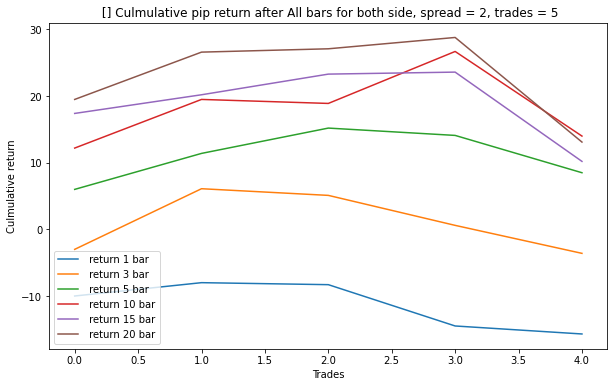

In [287]:
VM30F1_15M_2023_test.plot_PipReturn('All')

In [294]:
VM30F1_15M_2023_test.result_Sell

index                       time      open      high       low     close  \
0   3665  2021-09-10T10:45:00+07:00 1446.9000 1450.5000 1446.8000 1449.5000   
1   7019  2022-06-01T09:15:00+07:00 1324.2000 1331.4000 1323.5000 1328.7000   
2   8057  2022-08-16T13:30:00+07:00 1295.4000 1297.3000 1292.8000 1293.3000   

      basis     upper     lower  upper 2nd  ...    ATR  pivot  MACDpivot  \
0 1447.2000 1449.4322 1444.9678        NaN  ... 2.3475      0          0   
1 1319.9857 1329.4396 1310.5318        NaN  ... 3.8028      0          0   
2 1294.1857 1296.0540 1292.3174        NaN  ... 2.2437      0          0   

   pointpos  MACDpointpos  divSignal2MACD   CurrLow  CurrHigh  maxHi10bar  \
0       NaN           NaN          1.0000 1428.6000 1449.8000   1450.5000   
1       NaN           NaN          1.0000 1316.6000 1330.6000   1331.4000   
2       NaN           NaN          1.0000 1286.9000 1296.7000   1297.3000   

   maxLo10bar  
0   1445.1000  
1   1310.8000  
2   1291.5000  

[3 rows x 55 columns]

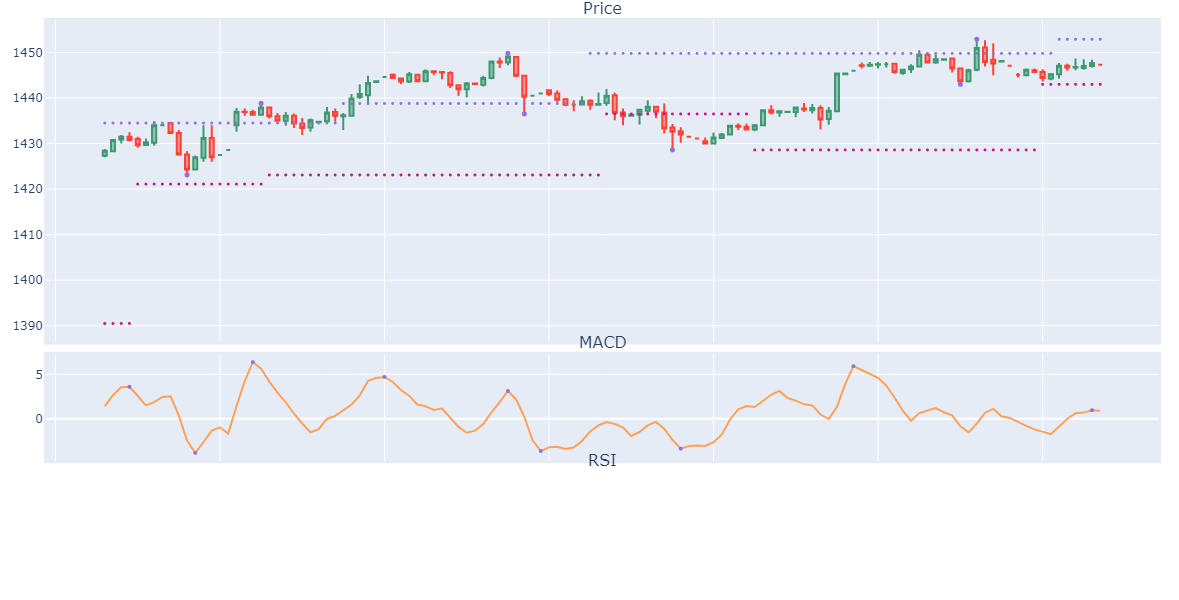

In [301]:
VM30F1_15M_2023_test.graph_Sample(3566,3688)

## XAUUSD

###  5 min

#### Trading view data- OANDA

In [251]:
XAU5M_1222_0223 = pd.read_csv("D:Data/Forex/XAUUSD/OANDA_XAUUSD, 5, 1222_0223 .csv")
XAU5M_1222_0223_test = TradingTest(XAU5M_1222_0223, pipRetMulti= 10)

In [252]:
compare_range = 10

In [253]:
XAU5M_1222_0223_test.gen_pivot(compare_range,compare_range)

pivot point generated with comparative range of( 10, 10 ) candle


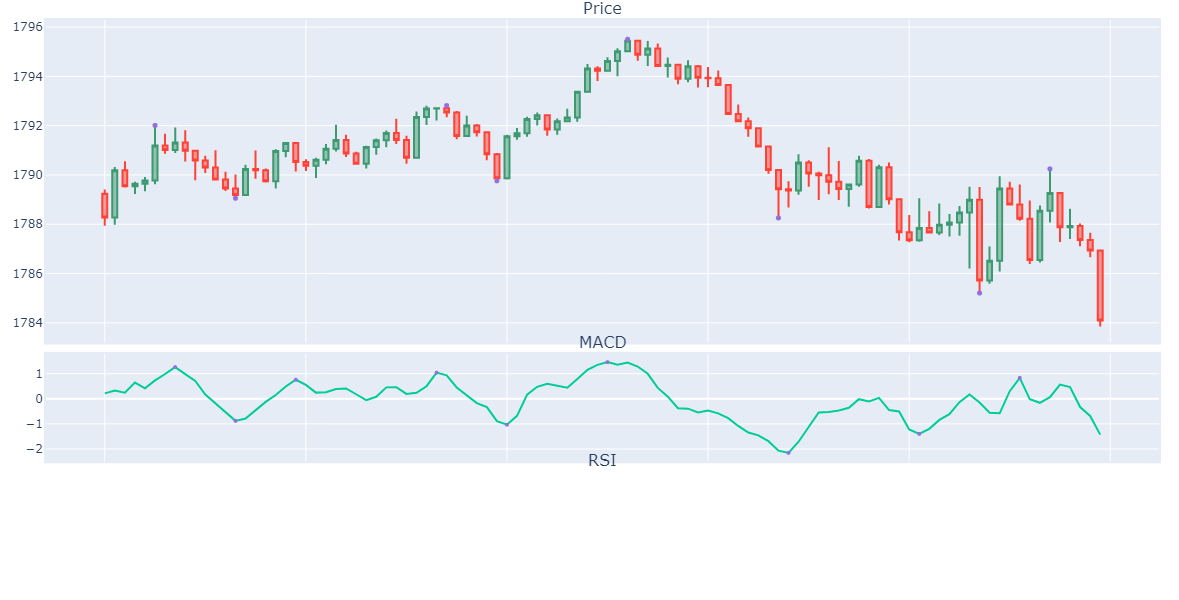

In [255]:
XAU5M_1222_0223_test.graph_Sample(100,200,CurrHigh = False, CurrLow= False)

In [31]:
XAU5M_1222_0223_test.gen_divSignal2(compare_range*10, compare_range)

divergence sigal generated with comparative range of( 10, 10 ) candle


In [371]:
XAU5M_1222_0223_resultS, XAU5M_1222_0223_statS = falsebreak_wDiv_test(XAU5M_1222_0223_test.df,
                                                                side = 'sell', elim_cons_trade = True,
                                                                falsebreak_bar= 0, ATR_surpass= 0.3,
                                                                ATR_commpare_range=0, fwdCandle=10
                                                                )
XAU5M_1222_0223_resultB, XAU5M_1222_0223_statB = falsebreak_wDiv_test(XAU5M_1222_0223_test.df,
                                                                side = 'buy', elim_cons_trade = True , 
                                                                falsebreak_bar= 0, ATR_surpass= 0.3,
                                                                ATR_commpare_range=0,fwdCandle=10
                                                                )
XAU5M_1222_0223_resultAll = GetResultAll(XAU5M_1222_0223_resultS,XAU5M_1222_0223_resultB)
XAU5M_1222_0223_statAll = GetStatAll(XAU5M_1222_0223_resultAll)
print('Sell stats')
display(XAU5M_1222_0223_statS)
print('Buy Stats')
display(XAU5M_1222_0223_statB)
print('All Stats')
display(XAU5M_1222_0223_statAll)

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: 'divSignal2MACD'

In [174]:
XAU5M_1222_0223_resultS

index                       time      open      high       low     close  \
0   1957  2022-12-21T08:05:00+07:00 1818.2650 1819.7200 1818.1600 1819.3150   
1   2559  2022-12-23T12:15:00+07:00 1794.8800 1796.1750 1794.8250 1795.5950   
2   2573  2022-12-23T13:25:00+07:00 1794.8200 1796.0950 1794.5900 1794.5900   
3   2614  2022-12-23T16:50:00+07:00 1797.6100 1798.5350 1797.3200 1798.2400   
4   9937  2023-02-02T08:30:00+07:00 1955.3650 1957.0550 1953.5150 1953.7400   
5  10832  2023-02-07T14:05:00+07:00 1875.4550 1876.3350 1874.1950 1874.3950   

      basis     upper     lower  upper 2nd  ...    ATR  pivot  MACDpivot  \
0 1817.9914 1819.2402 1816.7427        NaN  ... 0.7404      0          0   
1 1795.0743 1795.5190 1794.6295        NaN  ... 0.7061      0          0   
2 1795.2536 1796.2637 1794.2435        NaN  ... 0.7543      1          1   
3 1797.3886 1798.5872 1796.1899        NaN  ... 0.8981      0          0   
4 1955.2493 1956.6556 1953.8430        NaN  ... 1.7920      0          0   
5 1875.3050 1876.7976 1873.8124        NaN  ... 1.0526      0          0   

   pointpos  MACDpointpos  divSignal2MACD   CurrLow  CurrHigh  maxHi10bar  \
0       NaN           NaN          1.0000 1814.2600 1819.3900   1819.7200   
1       NaN           NaN          1.0000 1792.5450 1795.6450   1796.1750   
2 1794.5899       -0.3973          1.0000 1792.5450 1795.6450   1796.3450   
3       NaN           NaN          1.0000 1795.1300 1798.2650   1798.5350   
4       NaN           NaN          1.0000 1950.8550 1956.2250   1957.3100   
5       NaN           NaN          1.0000 1871.7350 1875.6900   1876.9750   

   maxLo10bar  
0   1816.7600  
1   1793.5900  
2   1794.5900  
3   1796.1050  
4   1951.5700  
5   1873.4700  

[6 rows x 55 columns]

In [179]:
startID = 10732
endID = 10843
dfpl = XAU5M_1222_0223_test.df[startID:endID]
width = 1100
height = 600
fig = make_subplots(rows=3, cols=1,
                    subplot_titles=("Price", "MACD", "RSI"),
                    row_heights=[0.6, 0.2, 0.2], vertical_spacing= 0.02,shared_xaxes = True )
fig.append_trace(go.Candlestick(x=dfpl.index,
        open=dfpl['open'],
        high=dfpl['high'],
        low=dfpl['low'],
        close=dfpl['close']), row=1, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),name="pivot", row=1, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['CurrHigh'],mode="markers",
                    marker=dict(size=3, color="MediumPurple"),name="CurrPivotHigh", row=1, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['CurrLow'],mode="markers",
                    marker=dict(size=3, color="mediumvioletred"),name="CurrPivotLow", row=1, col=1)
fig.append_trace(go.Scatter(x=dfpl.index,y=dfpl['MACD']),row=2, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['MACDpointpos'],mode="markers",
                    marker=dict(size=4, color="MediumPurple"),name="pivot", row=2, col=1)

fig.append_trace(go.Scatter(x=dfpl.index,y=dfpl['RSI']),row=3, col=1)
# fig.add_scatter(x=dfpl.index, y=dfpl['RSIpointpos'], mode="markers",marker=dict(size=4, color="MediumPurple"),
#                         name="pivot", row=3, col=1)
fig.update_layout(xaxis_rangeslider_visible= False, showlegend=False, height = height, width = width, margin=dict(l=50,r=50,b=0,t=0,pad=0))

KeyError: 'CurrHigh'

#### DUKASCOPY_XAUUSD_5M_BID_01.09.2022-14.01.2023

In [20]:
df = pd.read_csv("D:Data/Forex/XAUUSD/OANDA_XAUUSD, 5, 1222_0223 .csv")
tradingTest_xau5min = TradingTest(df)
tradingTest_xau5min.gen_pivot(5,5)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/5.Data center/Forex/XAUUSD/DUKASCOPY_XAUUSD_5M_BID_01.09.2022-14.01.2023.csv'

In [ ]:
tradingTest_xau5min.df.columns

In [ ]:
tradingTest_xau5min.gen_divSignal2(30, RSI = False)

In [ ]:
tradingTest_xau5min.df['divSignal2MACD'].value_counts()

In [ ]:
sell_result_dfpl, sell_stat_df = falsebreak_wDiv_test(tradingTest_xau5min.df, side = 'sell', elim_cons_trade = False, ATR_surpass= 0.1)
sell_stat_df

In [ ]:
sell_result_dfpl, sell_stat_df = falsebreak_wDiv_test(tradingTest_xau5min.df, side = 'sell', elim_cons_trade = True)
sell_stat_df

In [ ]:
buy_result_dfpl, buy_stat_df = falsebreak_wDiv_test(tradingTest_xau5min.df, side = 'buy', elim_cons_trade = True, ATR_surpass= 0.1)
buy_stat_df

#### DUKASCOPY_XAUUSD_Candlestick_5_M_BID_01.05.2022-01.09.2022

In [ ]:
print(os.listdir("D:/5.Data center/Forex/XAUUSD/"))

In [ ]:
df = pd.read_csv("D:/5.Data center/Forex/XAUUSD/DUKASCOPY_XAUUSD_Candlestick_5_M_BID_01.05.2022-01.09.2022.csv")
df.columns = ['Gmt time', 'open', 'high', 'low', 'close', 'Volume']
tradingTest_xau5min = TradingTest(df)
tradingTest_xau5min.df

In [ ]:
tradingTest_xau5min.gen_pivot(5,5)

In [ ]:
tradingTest_xau5min.gen_divSignal2(30)

In [ ]:
tradingTest_xau5min.df.divSignal2MACD.value_counts()

##### Sell

In [ ]:
sell_result_dfpl, sell_stat_df = falsebreak_wDiv_test(tradingTest_xau5min.df, side = 'sell', elim_cons_trade = False , falsebreak_bar=0, ATR_surpass=0.1)
sell_stat_df

##### Buy

In [ ]:
buy_result_dfpl, buy_stat_df = falsebreak_wDiv_test(tradingTest_xau5min.df, side = 'buy', elim_cons_trade = True , falsebreak_bar=1, ATR_surpass=0.1)
buy_stat_df

#### DUKAS_XAUUSD_Candlestick_5_M_BID_01.01.2021-01.05.2021

In [ ]:
df = pd.read_csv("D:/Data/Forex/XAUUSD/DUKAS_XAUUSD_Candlestick_5_M_BID_01.01.2021-01.05.2021.csv")
df.columns = ['Gmt time', 'open', 'high', 'low', 'close', 'Volume']
tradingTest_xau5min = TradingTest(df, pipRetMulti = 10)
tradingTest_xau5min.df

In [ ]:
tradingTest_xau5min.gen_pivot(5,5)

In [ ]:
tradingTest_xau5min.gen_divSignal2(30)

In [ ]:
XAU_sell_result_dfpl, XAU_sell_stat_df = falsebreak_wDiv_test(tradingTest_xau5min.df, side = 'sell', elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass=0.05)
XAU_sell_stat_df

In [ ]:
XAU_sell_result_dfpl['PipReturn_10bar_cumsum'] = (XAU_sell_result_dfpl['PipReturn_10bar']+2).cumsum()
plt.plot(XAU_sell_result_dfpl.index, -XAU_sell_result_dfpl['PipReturn_10bar_cumsum'])

##### buy

In [ ]:
XAU_buy_result_dfpl, XAU_buy_stat_df = falsebreak_wDiv_test(tradingTest_xau5min.df, side = 'buy', elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass= 0.05)
XAU_buy_stat_df

In [ ]:
XAU_buy_result_dfpl['PipReturn_10bar_cumsum'] = (XAU_buy_result_dfpl['PipReturn_10bar']-2).cumsum()
plt.plot(XAU_buy_result_dfpl.index, XAU_buy_result_dfpl['PipReturn_10bar_cumsum'])

### 15 Min

In [81]:
XAU15M_20_23 = pd.read_csv("D:/Data/Forex/XAUUSD/DUKAS_XAUUSD_Candlestick_15_M_BID_01.01.2020-01.01.2023.csv")

In [82]:
XAU15M_20_23['Gmt time'] = pd.to_datetime(XAU15M_20_23['Gmt time'])
XAU15M_20_23 = XAU15M_20_23.sort_values(by = 'Gmt time')

In [83]:
XAU_15m2020 = XAU15M_20_23[XAU15M_20_23['Gmt time'] < '2021-1-1']
XAU_15m2021 = XAU15M_20_23[(XAU15M_20_23['Gmt time'] > '2021-1-1') &  (XAU15M_20_23['Gmt time'] < '2022-1-1')]
XAU_15m2022 = XAU15M_20_23[XAU15M_20_23['Gmt time'] >= '2022-1-1']

In [84]:
XAU15M_17_20 = pd.read_csv("D:/Data/Forex/XAUUSD/XAUUSD_Candlestick_15_M_BID_01.01.2017-01.01.2020.csv")
XAU15M_17_20['Gmt time'] = pd.to_datetime(XAU15M_17_20['Gmt time'])
XAU15M_17_20 = XAU15M_17_20.sort_values(by = 'Gmt time')

In [85]:
XAU_15m2017 = XAU15M_17_20[XAU15M_17_20['Gmt time'] < '2018-1-1']
XAU_15m2018 = XAU15M_17_20[(XAU15M_17_20['Gmt time'] > '2017-12-30') &  (XAU15M_17_20['Gmt time'] < '2019-1-1')]
XAU_15m2019 = XAU15M_17_20[XAU15M_17_20['Gmt time'] >= '2018-12-30']

#### 2017

In [34]:
XAU_15m2017_test = TradingTest(XAU_15m2017.reset_index().drop(columns = ['index']), pipRetMulti = 10)

In [45]:
XAU_15m2017_test.gen_pivot(5,5)


pivot point generated with comparative range of( 5, 5 ) candle


In [46]:
XAU_15m2017_test.gen_divSignal2(30,5)

gmt time      open      high       low     close  \
0     2017-01-02 00:00:00 1211.5390 1211.6990 1210.9510 1211.2990   
1     2017-01-02 00:15:00 1211.2780 1211.4090 1210.3580 1210.9980   
2     2017-01-02 00:30:00 1210.9980 1211.1890 1209.9920 1210.2110   
3     2017-01-02 00:45:00 1210.2520 1211.3880 1210.1990 1211.2890   
4     2017-01-02 01:00:00 1211.2780 1211.6090 1209.9290 1210.0290   
...                   ...       ...       ...       ...       ...   
23550 2017-12-29 20:45:00 1302.9710 1303.6120 1302.7380 1303.2210   
23551 2017-12-29 21:00:00 1303.2110 1303.4420 1303.0220 1303.1850   
23552 2017-12-29 21:15:00 1303.1860 1303.1860 1302.5570 1302.5900   
23553 2017-12-29 21:30:00 1302.5970 1302.7520 1302.1010 1302.1510   
23554 2017-12-29 21:45:00 1302.1520 1302.7710 1302.1520 1302.6220   

            volume  LogReturn_1bar  LogReturn_3bar  LogReturn_10bar  \
0      452749.9985         -0.0002         -0.0000          -0.0005   
1      649270.0018         -0.0007         -0.0008          -0.0006   
2      620300.0069          0.0009         -0.0002           0.0002   
3      955119.9938         -0.0010         -0.0007          -0.0002   
4      956000.0002         -0.0000         -0.0004          -0.0003   
...            ...             ...             ...              ...   
23550  998049.9967         -0.0000         -0.0008              NaN   
23551 1215470.0197         -0.0005         -0.0004              NaN   
23552  732330.0057         -0.0003             NaN              NaN   
23553  889490.0039          0.0004             NaN              NaN   
23554  511250.0005             NaN             NaN              NaN   

       LogReturn_20bar  ...  PipReturn_15bar  PipReturn_20bar    MACD     RSI  \
0              -0.0018  ...         -16.9000         -21.6100     NaN     NaN   
1              -0.0025  ...         -14.9900         -29.8000     NaN     NaN   
2              -0.0017  ...         -13.2300         -20.2000     NaN     NaN   
3              -0.0020  ...         -27.4000         -24.6100     NaN     NaN   
4              -0.0012  ...         -15.3100         -14.9000     NaN     NaN   
...                ...  ...              ...              ...     ...     ...   
23550              NaN  ...              NaN              NaN -0.1168 57.0572   
23551              NaN  ...              NaN              NaN -0.0437 56.9358   
23552              NaN  ...              NaN              NaN -0.0589 54.9359   
23553              NaN  ...              NaN              NaN -0.3835 53.5016   
23554              NaN  ...              NaN              NaN -0.5163 54.8111   

         ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  
0        NaN      0          0       NaN           NaN          0.0000  
1        NaN      0          0       NaN           NaN          0.0000  
2        NaN      0          0       NaN           NaN          0.0000  
3        NaN      0          0       NaN           NaN          0.0000  
4        NaN      0          0       NaN           NaN          0.0000  
...      ...    ...        ...       ...           ...             ...  
23550 1.1795      0          0       NaN           NaN          1.0000  
23551 1.1415      0          0       NaN           NaN          1.0000  
23552 1.1159      0          0       NaN           NaN          1.0000  
23553 1.0927      0          0       NaN           NaN          1.0000  
23554 1.0690      0          0       NaN           NaN          0.0000  

[23555 rows x 24 columns]

In [47]:
XAU_15m2017_test.df.divSignal2MACD.value_counts()

0.0000    7932
1.0000    1900
2.0000    1544
Name: divSignal2MACD, dtype: int64

In [78]:
XAU_15m2017_resultS, XAU_15m2017_statS = falsebreak_wDiv_test(XAU_15m2017_test.df,side = 'sell', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)
XAU_15m2017_resultB, XAU_15m2017_statB = falsebreak_wDiv_test(XAU_15m2017_test.df,side = 'buy', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)
XAU_15m2017_resultAll = GetResultAll(XAU_15m2017_resultS,XAU_15m2017_resultB)
XAU_15m2017_statAll = GetStatAll(XAU_15m2017_resultAll)

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\597214373.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\597214373.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 1,
, ATR_Surpass = 0.0, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_10bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_5152\2676031246.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\2676031246.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\597214373.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\597214373.py:29: SettingWithCopyWarning:


A value i

result of buy falsebreak with falsebreak bar = 1,
, ATR_Surpass = 0.0, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_10bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_5152\2676031246.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\2676031246.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



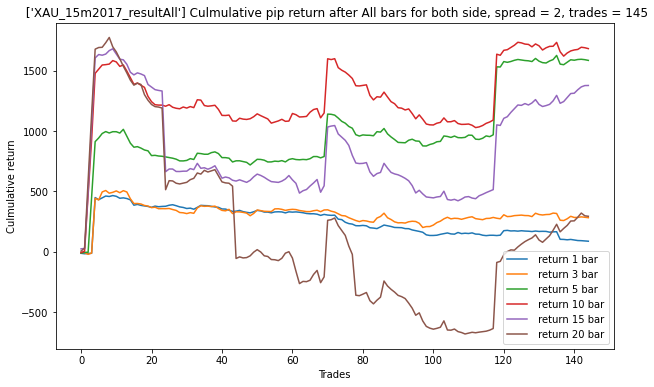

In [83]:
Plot_csPipReturn(XAU_15m2017_resultAll,side = 'All',spread = 2, return_bar='All')

In [80]:
XAU_15m2017_statAll

count    mean      std       min      25%     50%     75%  \
PipReturn_1bar  145.0000  2.6003  39.9521  -60.9200  -4.1400 -0.6400  4.1300   
PipReturn_3bar  145.0000  3.9463  40.8811  -54.6000  -6.2900 -0.3700  9.1800   
PipReturn_5bar  145.0000 12.9465  79.0230  -70.2000  -5.9700  0.0100 11.5300   
PipReturn_10bar 145.0000 13.6191  95.7698  -86.2800 -16.6000  0.3400 14.9000   
PipReturn_15bar 145.0000 11.5106 115.9398 -667.6000 -17.2900  2.7700 19.3900   
PipReturn_20bar 145.0000  4.0270 133.3964 -675.6000 -25.4000  3.5100 22.8000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  464.3900        0.0651          9.4373  
PipReturn_3bar  455.5000        0.0965         13.9972  
PipReturn_5bar  566.0700        0.1638         23.7556  
PipReturn_10bar 548.5200        0.1422         20.6200  
PipReturn_15bar 567.0000        0.0993         14.3957  
PipReturn_20bar 562.8400        0.0302          4.3773

In [ ]:
Plot_csPipReturn(XAU_15m2017_resultS, side = 'sell', spread = 2, return_bar = 'All')
Plot_csPipReturn(XAU_15m2017_resultB, side = 'buy', spread = 2, return_bar = 'All')

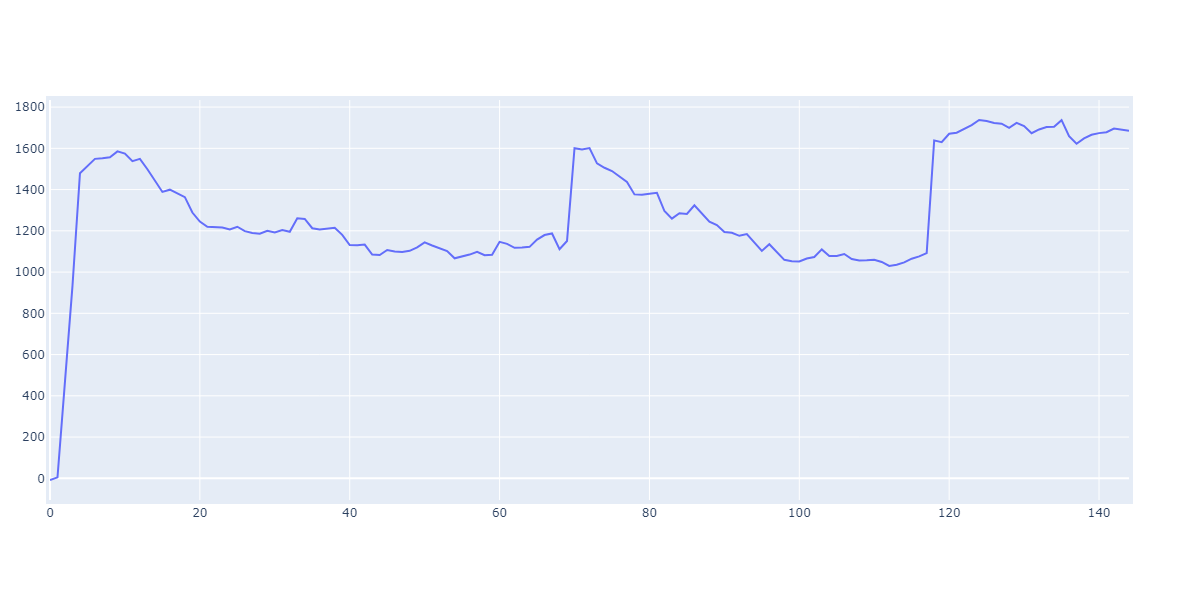

In [52]:
dfpl = XAU_15m2017_resultAll
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl.index,y=dfpl['PipReturn_10bar_cumsum']), row = 1, col = 1)    
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

In [53]:
XAU_15m2017_resultAll.loc[70]

index                                   11891
gmt time                  2017-07-03 23:00:00
open                                1214.1290
high                                1216.7920
low                                 1214.0780
close                               1215.7590
volume                            110440.0006
LogReturn_1bar                        -0.0003
LogReturn_3bar                         0.0003
LogReturn_10bar                        0.0365
LogReturn_20bar                        0.0380
PipReturn_1bar                        -3.4100
PipReturn_3bar                         3.4300
PipReturn_5bar                       354.0000
PipReturn_10bar                      451.6900
PipReturn_15bar                      489.4900
PipReturn_20bar                      471.4000
MACD                                  -0.2808
RSI                                   40.2319
ATR                                    1.1086
pivot                                       1
MACDpivot                         

In [55]:
XAU_15m2017_test.df.loc[11891]

gmt time           2017-07-03 23:00:00
open                         1214.1290
high                         1216.7920
low                          1214.0780
close                        1215.7590
volume                     110440.0006
LogReturn_1bar                 -0.0003
LogReturn_3bar                  0.0003
LogReturn_10bar                 0.0365
LogReturn_20bar                 0.0380
PipReturn_1bar                 -3.4100
PipReturn_3bar                  3.4300
PipReturn_5bar                354.0000
PipReturn_10bar               451.6900
PipReturn_15bar               489.4900
PipReturn_20bar               471.4000
MACD                           -0.2808
RSI                            40.2319
ATR                             1.1086
pivot                                1
MACDpivot                            1
pointpos                     1214.0779
MACDpointpos                   -0.2809
divSignal2MACD                  2.0000
CurrLow                      1214.1420
CurrHigh                 

In [58]:
XAU_15m2017_test.graph_init_Sample(11800, 11920,RSI=False)

#### 2018

In [66]:
XAU_15m2018_test = TradingTest(XAU_15m2018.reset_index(drop = True), pipRetMulti = 10)

In [67]:
XAU_15m2018_test.gen_pivot(5,5)
XAU_15m2018_test.gen_divSignal2(30,5)

pivot point generated with comparative range of( 5, 5 ) candle


gmt time      open      high       low     close      volume  \
0     2018-01-01 23:00:00 1302.9220 1303.7580 1302.2310 1303.7580 407190.0015   
1     2018-01-01 23:15:00 1303.7580 1306.3080 1303.6610 1306.3010 468380.0022   
2     2018-01-01 23:30:00 1306.3010 1307.6020 1306.1210 1307.1420 513970.0006   
3     2018-01-01 23:45:00 1307.1420 1307.2680 1306.6580 1306.7110 236890.0017   
4     2018-01-02 00:00:00 1345.2180 1346.6320 1345.2010 1346.5980 706119.9974   
...                   ...       ...       ...       ...       ...         ...   
23612 2018-12-31 20:45:00 1282.1180 1282.2180 1281.7180 1282.0180 129650.0008   
23613 2018-12-31 21:00:00 1281.9950 1282.7480 1281.9950 1282.5480 165160.0021   
23614 2018-12-31 21:15:00 1282.6480 1282.7480 1281.9980 1282.1480  69370.0005   
23615 2018-12-31 21:30:00 1282.0980 1282.5480 1281.9580 1282.2580  98570.0002   
23616 2018-12-31 21:45:00 1282.2600 1282.6480 1282.0350 1282.1850 221564.9988   

       LogReturn_1bar  LogReturn_3bar  LogReturn_10bar  LogReturn_20bar  ...  \
0              0.0019          0.0023           0.0305           0.0312  ...   
1              0.0006          0.0304           0.0275           0.0291  ...   
2             -0.0003          0.0294           0.0274           0.0282  ...   
3              0.0301          0.0300           0.0276           0.0288  ...   
4             -0.0003         -0.0005          -0.0028          -0.0014  ...   
...               ...             ...              ...              ...  ...   
23612          0.0004          0.0002              NaN              NaN  ...   
23613         -0.0003         -0.0003              NaN              NaN  ...   
23614          0.0001             NaN              NaN              NaN  ...   
23615         -0.0001             NaN              NaN              NaN  ...   
23616             NaN             NaN              NaN              NaN  ...   

       PipReturn_15bar  PipReturn_20bar   MACD     RSI    ATR  pivot  \
0             395.9400         413.6400    NaN     NaN    NaN      0   
1             368.5000         385.1000    NaN     NaN    NaN      0   
2             373.4000         373.9900    NaN     NaN    NaN      0   
3             376.9800         382.0100    NaN     NaN    NaN      0   
4             -26.4700         -18.4700    NaN     NaN    NaN      0   
...                ...              ...    ...     ...    ...    ...   
23612              NaN              NaN 0.9273 53.6594 1.0607      0   
23613              NaN              NaN 0.7123 55.2369 1.0453      0   
23614              NaN              NaN 0.5173 53.8069 1.0305      0   
23615              NaN              NaN 0.3670 54.1446 1.0085      0   
23616              NaN              NaN 0.1323 53.8742 0.9887      0   

       MACDpivot  pointpos  MACDpointpos  divSignal2MACD  
0              0       NaN           NaN          0.0000  
1              0       NaN           NaN          0.0000  
2              0       NaN           NaN          0.0000  
3              0       NaN           NaN          0.0000  
4              0       NaN           NaN          0.0000  
...          ...       ...           ...             ...  
23612          0       NaN           NaN          0.0000  
23613          0       NaN           NaN          0.0000  
23614          0       NaN           NaN          0.0000  
23615          0       NaN           NaN          0.0000  
23616          0       NaN           NaN             NaN  

[23617 rows x 24 columns]

In [68]:
XAU_15m2018_test.df.divSignal2MACD.value_counts()

0.0000    8607
2.0000    1774
1.0000    1744
Name: divSignal2MACD, dtype: int64

In [69]:
XAU_15m2018_resultS, XAU_15m2018_statS = falsebreak_wDiv_test(XAU_15m2018_test.df,side = 'sell', 
                                                             elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass= 0.0)
XAU_15m2018_resultB, XAU_15m2018_statB = falsebreak_wDiv_test(XAU_15m2018_test.df,side = 'buy', 
                                                             elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass= 0.0)
XAU_15m2018_resultAll = GetResultAll(XAU_15m2018_resultS,XAU_15m2018_resultB)
XAU_15m2018_statAll = GetStatAll(XAU_15m2018_resultAll)

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\597214373.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\597214373.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.0, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_10bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_5152\2676031246.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\2676031246.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\597214373.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\597214373.py:27: SettingWithCopyWarning:


A value i

result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.0, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_10bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_5152\2676031246.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_5152\2676031246.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



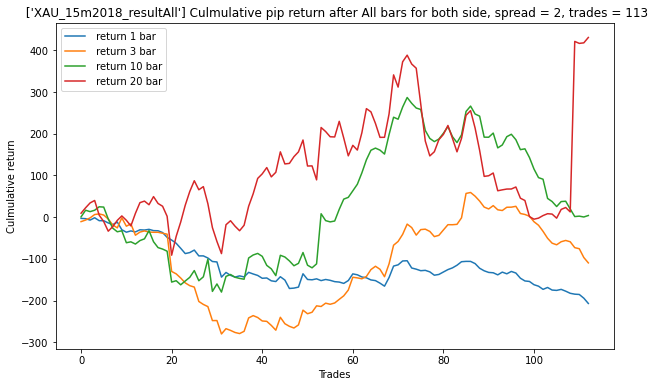

In [70]:
Plot_csPipReturn(XAU_15m2018_resultAll,side = 'All',spread = 2, return_bar='All')

In [71]:
XAU_15m2018_statAll

count   mean     std      min      25%     50%     75%  \
PipReturn_1bar  113.0000 0.1684  8.5237 -34.3900  -4.1000 -0.5000  4.3000   
PipReturn_3bar  113.0000 1.0296 16.9373 -87.5100  -6.9000 -0.3300  9.3300   
PipReturn_10bar 113.0000 2.0352 25.2620 -75.4800 -11.0000  1.3000 11.9900   
PipReturn_20bar 113.0000 5.8141 51.6069 -91.2700 -19.6200  3.9300 18.0900   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   34.0000        0.0198          2.2326  
PipReturn_3bar   60.5000        0.0608          6.8689  
PipReturn_10bar 122.1700        0.0806          9.1038  
PipReturn_20bar 410.8700        0.1127         12.7307

In [72]:
dfpl = XAU_15m2018_resultAll
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl['gmt time'],y=dfpl['PipReturn_3bar_cumsum']), row = 1, col = 1)
# fig.add_scatter(x = GJ1H_18_23_resultAll.iloc[138:]['gmt time'], y= GJ1H_18_23_resultAll.iloc[138:]['PipReturn_20bar_cumsum'],mode="markers",
#                             marker=dict(size=4, color="MediumPurple"),name="pivot", row=2, col=1)
       
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

#### 2019

In [ ]:
XAU_15m2019_test = TradingTest(XAU_15m2019.reset_index().drop(columns = ['index']), pipRetMulti = 10)

In [ ]:
XAU_15m2019_test.gen_pivot(5,5)
XAU_15m2019_test.gen_divSignal2(30)

In [ ]:
XAU_15m2019_test.df.divSignal2MACD.value_counts()

In [ ]:
XAU_15m2019_resultS, XAU_15m2019_statS = falsebreak_wDiv_test(XAU_15m2019_test.df,side = 'sell', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0)
XAU_15m2019_resultB, XAU_15m2019_statB = falsebreak_wDiv_test(XAU_15m2019_test.df,side = 'buy', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0)
XAU_15m2019_resultAll = GetResultAll(XAU_15m2019_resultS,XAU_15m2019_resultB)
XAU_15m2019_statAll = GetStatAll(XAU_15m2019_resultAll)

In [ ]:
Plot_csPipReturn(XAU_15m2019_resultAll,'All',2,'All')

In [ ]:
dfpl = XAU_15m2019_resultAll
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl['gmt time'],y=dfpl['PipReturn_3bar_cumsum']), row = 1, col = 1)    
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

In [ ]:
XAU_15m2019_statAll

In [ ]:
Plot_csPipReturn(XAU_15m2019_resultS, side = 'sell', spread = 2, return_bar = 'All')
Plot_csPipReturn(XAU_15m2019_resultB, side = 'buy', spread = 2, return_bar = 'All')

In [ ]:
XAU_15m2019_statS

In [ ]:
XAU_15m2019_statB

#### 2020

In [ ]:
XAU_15m2020_test = TradingTest(XAU_15m2020.reset_index().drop(columns = ['index']), pipRetMulti = 10)

In [ ]:
XAU_15m2020_test.gen_pivot(5,5)
XAU_15m2020_test.gen_divSignal2(30)

In [ ]:
XAU_15m2020_test.df.divSignal2MACD.value_counts()

In [ ]:
XAU_15m2020_resultS, XAU_15m2020_statS = falsebreak_wDiv_test(XAU_15m2020_test.df,side = 'sell', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0)
XAU_15m2020_resultB, XAU_15m2020_statB = falsebreak_wDiv_test(XAU_15m2020_test.df,side = 'buy', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0)
XAU_15m2020_resultAll = GetResultAll(XAU_15m2020_resultS,XAU_15m2020_resultB)
XAU_15m2020_statAll = GetStatAll(XAU_15m2020_resultAll)

In [ ]:
Plot_csPipReturn(XAU_15m2020_resultAll,'All',2,'All')

In [ ]:
XAU_15m2020_statAll

In [ ]:
dfpl = XAU_15m2020_resultAll
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl['gmt time'],y=dfpl['PipReturn_20bar_cumsum']), row = 1, col = 1)    
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

In [ ]:
XAU_15m2020_resultAll[XAU_15m2020_resultAll['gmt time'] >= '2020-2-11']

In [ ]:
XAU_15m2020[XAU_15m2020['Gmt time'] >= '2020-2-12 20:30:00']

In [ ]:
XAU_15m2020_test.graph_init_Sample(2800,2850,RSI = False,RSIpp=False,height=2000)

In [ ]:
Plot_csPipReturn(XAU_15m2020_resultS, side = 'sell', spread = 2, return_bar = 'All')
Plot_csPipReturn(XAU_15m2020_resultB, side = 'buy', spread = 2, return_bar = 'All')

#### 2021

In [ ]:
XAU_15m2021_test = TradingTest(XAU_15m2021.reset_index().drop(columns = ['index']), pipRetMulti = 10)

In [ ]:
XAU_15m2021_test.gen_pivot(5,5)
XAU_15m2021_test.gen_divSignal2(30)

In [ ]:
XAU_15m2021_test.df.divSignal2MACD.value_counts()

In [ ]:
XAU_15m2021_resultS, XAU_15m2021_statS = falsebreak_wDiv_test(XAU_15m2021_test.df,side = 'sell', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0)
XAU_15m2021_resultB, XAU_15m2021_statB = falsebreak_wDiv_test(XAU_15m2021_test.df,side = 'buy', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0)
XAU_15m2021_resultS_copy = XAU_15m2021_resultS.copy()
XAU_15m2021_resultS_copy[pip_return_masking]  = XAU_15m2021_resultS_copy[pip_return_masking]*-1
XAU_15m2021_resultAll = pd.concat([XAU_15m2021_resultB, XAU_15m2021_resultS_copy])
XAU_15m2021_resultAll = XAU_15m2021_resultAll.reset_index().drop(columns = ['level_0'])
Plot_csPipReturn(XAU_15m2021_resultAll, 'buy', 2, "All")


In [ ]:
XAU_15m2021_statAll = XAU_15m2021_resultAll[pip_return_masking].describe().T
XAU_15m2021_statAll['Sharpe ratio'] = XAU_15m2021_statAll['mean']/ XAU_15m2021_statAll['std']
XAU_15m2021_statAll['Count x Sharpe'] = XAU_15m2021_statAll['Sharpe ratio'] * XAU_15m2021_statAll['count']
XAU_15m2021_statAll

In [ ]:
XAU_15m2021_statS

In [ ]:
XAU_15m2021_statB

In [ ]:
Plot_csPipReturn(XAU_15m2021_resultS, 'sell', 2, 'All')

In [ ]:
Plot_csPipReturn(XAU_15m2021_resultB, 'buy', 2, 'All')

#### 2022

In [336]:
XAU_15m2022 = pd.read_csv('D:Data/Forex/XAUUSD/DUKAS_XAUUSD_Candlestick_15_M_BID_01.01.2022-14.01.2023.csv')
XAU_15m2022['Gmt time'] = pd.to_datetime(XAU_15m2022['Gmt time'], dayfirst=True)
XAU_15m2022 = XAU_15m2022.sort_values(by = 'Gmt time')
XAU_15m2022 = XAU_15m2022.reset_index(drop = True)

In [337]:
XAU_15m2022

Gmt time      Open      High       Low     Close      Volume
0     2022-01-02 23:00:00 1828.6040 1831.6240 1828.5440 1830.4140 278950.0028
1     2022-01-02 23:15:00 1830.4540 1830.6740 1828.9180 1829.2380 175719.9989
2     2022-01-02 23:30:00 1829.2380 1829.3390 1828.3480 1828.3540 144820.0018
3     2022-01-02 23:45:00 1828.3480 1828.3880 1827.8980 1828.3540  93420.0005
4     2022-01-03 00:00:00 1828.2940 1828.3280 1827.3440 1827.3680 141309.9991
...                   ...       ...       ...       ...       ...         ...
24470 2023-01-13 20:45:00 1920.4080 1921.3480 1919.5550 1920.5980 325410.0038
24471 2023-01-13 21:00:00 1920.4980 1920.8980 1918.9550 1918.9680 148080.0009
24472 2023-01-13 21:15:00 1919.0680 1920.1650 1918.3150 1919.8950 146540.0005
24473 2023-01-13 21:30:00 1919.8550 1920.0150 1919.3480 1919.8480  30299.9999
24474 2023-01-13 21:45:00 1919.8480 1920.9480 1919.3270 1919.3980  62109.9995

[24475 rows x 6 columns]

In [338]:
XAU_15m2022_test = TradingTest(XAU_15m2022, pipRetMulti = 10)

In [339]:
compare_range = 10

In [ ]:
XAU_15m2022_test.gen_pivot(compare_range,compare_range)
XAU_15m2022_test.gen_divSignal2(compare_range*10, compare_range)

pivot point generated with comparative range of( 10, 10 ) candle


In [221]:
XAU_15m2022_test.df.divSignal2MACD.value_counts()

2.0000    3692
1.0000    2983
0.0000     542
Name: divSignal2MACD, dtype: int64

In [354]:
XAU_15m2022_resultS, XAU_15m2022_statS = falsebreak_wDiv_test(XAU_15m2022_test.df,side = 'sell',
                                                                elim_cons_trade = True,
                                                                falsebreak_bar= 0, ATR_surpass= 0.3,
                                                                ATR_commpare_range=0, fwdCandle=compare_range)
XAU_15m2022_resultB, XAU_15m2022_statB = falsebreak_wDiv_test(XAU_15m2022_test.df,side = 'buy', 
                                                                elim_cons_trade = True,
                                                                falsebreak_bar= 0, ATR_surpass= 0.3,
                                                                ATR_commpare_range=0, fwdCandle=compare_range)

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.3, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.3, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


In [355]:
XAU_15m2022_statS

count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  3.0000 -3.2133 28.6345 -34.6400 -15.5200  3.6000 12.5000   
PipReturn_3bar  3.0000 -5.6767 39.6653 -45.4300 -25.4650 -5.5000 14.2000   
PipReturn_5bar  3.0000 12.7133 17.5015  -1.3900   2.9200  7.2300 19.7650   
PipReturn_10bar 3.0000  9.4033 41.1906 -36.1400  -7.9200 20.3000 32.1750   
PipReturn_15bar 3.0000  1.1533 49.7800 -55.7400 -16.6200 22.5000 29.6000   
PipReturn_20bar 3.0000 -5.7467 55.1154 -69.3400 -22.7200 23.9000 26.0500   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  21.4000       -0.1122         -0.3367  
PipReturn_3bar  33.9000       -0.1431         -0.4293  
PipReturn_5bar  32.3000        0.7264          2.1792  
PipReturn_10bar 44.0500        0.2283          0.6849  
PipReturn_15bar 36.7000        0.0232          0.0695  
PipReturn_20bar 28.2000       -0.1043         -0.3128

In [356]:
XAU_15m2022_statB

count     mean      std       min      25%      50%     75%  \
PipReturn_1bar  8.0000  -1.2638  32.2691  -47.1000 -13.2000  -7.7950  2.8050   
PipReturn_3bar  8.0000 -12.8587  30.2891  -47.9000 -35.2875 -19.7300  5.8250   
PipReturn_5bar  8.0000 -13.3712  45.5637 -106.3000 -26.3400  -8.6300 10.0125   
PipReturn_10bar 8.0000 -33.1887  67.3414 -165.0000 -58.1500 -34.4800 10.4625   
PipReturn_15bar 8.0000 -36.7875  76.1987 -162.4500 -85.9350   4.3950 18.3050   
PipReturn_20bar 8.0000  -6.0300 101.6540 -159.1000 -55.0500   7.5700 46.9050   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   58.6400       -0.0392         -0.3133  
PipReturn_3bar   38.3400       -0.4245         -3.3963  
PipReturn_5bar   49.0000       -0.2935         -2.3477  
PipReturn_10bar  53.6000       -0.4928         -3.9427  
PipReturn_15bar  26.4000       -0.4828         -3.8623  
PipReturn_20bar 148.5000       -0.0593         -0.4746

In [292]:
XAU_15m2022_resultS

index            gmt time      open      high       low     close  \
0     151 2022-01-03 14:45:00 1921.3170 1926.9880 1920.1770 1923.9680   
1    3083 2022-02-17 16:45:00 1897.1280 1899.2580 1895.0780 1895.5380   
2    5647 2022-03-30 12:15:00 1927.1130 1932.5080 1926.6180 1928.1780   
3    8993 2022-05-23 05:45:00 1854.8880 1858.1280 1854.8680 1856.0380   
4    9386 2022-05-27 12:00:00 1858.2880 1861.8380 1857.4280 1860.1470   
5   13218 2022-07-22 09:00:00 1718.2830 1720.5180 1717.6380 1719.0280   
6   14228 2022-08-08 10:30:00 1776.9280 1779.5480 1776.6540 1778.8240   
7   17689 2022-09-29 23:45:00 1664.0350 1665.0450 1663.3750 1664.4550   
8   17693 2022-09-30 00:45:00 1663.1480 1665.1650 1663.1150 1664.6100   
9   21316 2022-11-24 08:30:00 1754.3670 1756.8280 1754.2870 1755.9080   
10  23306 2022-12-27 05:45:00 1804.8150 1807.3550 1804.8150 1805.7450   
11  24166 2023-09-01 14:45:00 1876.9450 1881.4450 1876.3850 1876.9650   

         volume  LogReturn_1bar  LogReturn_3bar  LogReturn_10bar  ...    ATR  \
0  1352579.9958         -0.0019          0.0016           0.0045  ... 3.9938   
1  1031260.0023          0.0011          0.0018           0.0023  ... 3.5465   
2   975850.0047         -0.0016         -0.0008           0.0046  ... 2.8749   
3   790299.9967         -0.0009         -0.0013           0.0021  ... 2.0198   
4   566909.9967         -0.0019         -0.0024          -0.0019  ... 2.0022   
5   507810.0004          0.0017          0.0030           0.0049  ... 1.9982   
6   402689.9991          0.0006          0.0018           0.0013  ... 1.8671   
7   148739.9997         -0.0008         -0.0008          -0.0023  ... 2.1722   
8   343560.0027         -0.0006         -0.0015          -0.0012  ... 2.0864   
9   662849.9982         -0.0002          0.0007          -0.0001  ... 1.6818   
10  425090.0019          0.0002         -0.0003           0.0011  ... 1.3398   
11  589180.0002          0.0001         -0.0019          -0.0038  ... 2.4438   

    pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD   CurrLow  \
0       0          0       NaN           NaN          1.0000 1798.4880   
1       0          0       NaN           NaN          1.0000 1882.6880   
2       0          0       NaN           NaN          1.0000 1917.1080   
3       0          0       NaN           NaN          1.0000 1832.1780   
4       2          0 1861.8381           NaN          1.0000 1851.8180   
5       0          0       NaN           NaN          1.0000 1712.7240   
6       0          0       NaN           NaN          1.0000 1771.1480   
7       0          0       NaN           NaN          1.0000 1657.0880   
8       2          0 1665.1651           NaN          1.0000 1657.0880   
9       0          0       NaN           NaN          1.0000 1728.1370   
10      0          0       NaN           NaN          1.0000 1793.5350   
11      2          0 1881.4451           NaN          1.0000 1870.4250   

    CurrHigh  maxHi10bar  maxLo10bar  
0  1926.2510   1926.9880   1911.1080  
1  1897.6680   1899.2580   1889.3010  
2  1928.2980   1932.5080   1919.1290  
3  1857.8580   1858.1280   1853.5580  
4  1860.2930   1861.8380   1857.2260  
5  1720.2380   1720.5180   1714.9580  
6  1779.1040   1779.5480   1772.4380  
7  1664.7460   1665.0450   1659.4750  
8  1664.7460   1665.1650   1662.0280  
9  1756.6180   1757.4980   1752.3080  
10 1806.2450   1807.3550   1803.6250  
11 1880.9050   1881.4450   1872.6650  

[12 rows x 34 columns]

In [293]:
XAU_15m2022_resultS_gmtplus_7 = XAU_15m2022_resultS.copy()
XAU_15m2022_resultS_gmtplus_7['gmt time'] = XAU_15m2022_resultS['gmt time'] + datetime.timedelta(hours = 7)

In [294]:
XAU_15m2022_resultS_gmtplus_7

index            gmt time      open      high       low     close  \
0     151 2022-01-03 21:45:00 1921.3170 1926.9880 1920.1770 1923.9680   
1    3083 2022-02-17 23:45:00 1897.1280 1899.2580 1895.0780 1895.5380   
2    5647 2022-03-30 19:15:00 1927.1130 1932.5080 1926.6180 1928.1780   
3    8993 2022-05-23 12:45:00 1854.8880 1858.1280 1854.8680 1856.0380   
4    9386 2022-05-27 19:00:00 1858.2880 1861.8380 1857.4280 1860.1470   
5   13218 2022-07-22 16:00:00 1718.2830 1720.5180 1717.6380 1719.0280   
6   14228 2022-08-08 17:30:00 1776.9280 1779.5480 1776.6540 1778.8240   
7   17689 2022-09-30 06:45:00 1664.0350 1665.0450 1663.3750 1664.4550   
8   17693 2022-09-30 07:45:00 1663.1480 1665.1650 1663.1150 1664.6100   
9   21316 2022-11-24 15:30:00 1754.3670 1756.8280 1754.2870 1755.9080   
10  23306 2022-12-27 12:45:00 1804.8150 1807.3550 1804.8150 1805.7450   
11  24166 2023-09-01 21:45:00 1876.9450 1881.4450 1876.3850 1876.9650   

         volume  LogReturn_1bar  LogReturn_3bar  LogReturn_10bar  ...    ATR  \
0  1352579.9958         -0.0019          0.0016           0.0045  ... 3.9938   
1  1031260.0023          0.0011          0.0018           0.0023  ... 3.5465   
2   975850.0047         -0.0016         -0.0008           0.0046  ... 2.8749   
3   790299.9967         -0.0009         -0.0013           0.0021  ... 2.0198   
4   566909.9967         -0.0019         -0.0024          -0.0019  ... 2.0022   
5   507810.0004          0.0017          0.0030           0.0049  ... 1.9982   
6   402689.9991          0.0006          0.0018           0.0013  ... 1.8671   
7   148739.9997         -0.0008         -0.0008          -0.0023  ... 2.1722   
8   343560.0027         -0.0006         -0.0015          -0.0012  ... 2.0864   
9   662849.9982         -0.0002          0.0007          -0.0001  ... 1.6818   
10  425090.0019          0.0002         -0.0003           0.0011  ... 1.3398   
11  589180.0002          0.0001         -0.0019          -0.0038  ... 2.4438   

    pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD   CurrLow  \
0       0          0       NaN           NaN          1.0000 1798.4880   
1       0          0       NaN           NaN          1.0000 1882.6880   
2       0          0       NaN           NaN          1.0000 1917.1080   
3       0          0       NaN           NaN          1.0000 1832.1780   
4       2          0 1861.8381           NaN          1.0000 1851.8180   
5       0          0       NaN           NaN          1.0000 1712.7240   
6       0          0       NaN           NaN          1.0000 1771.1480   
7       0          0       NaN           NaN          1.0000 1657.0880   
8       2          0 1665.1651           NaN          1.0000 1657.0880   
9       0          0       NaN           NaN          1.0000 1728.1370   
10      0          0       NaN           NaN          1.0000 1793.5350   
11      2          0 1881.4451           NaN          1.0000 1870.4250   

    CurrHigh  maxHi10bar  maxLo10bar  
0  1926.2510   1926.9880   1911.1080  
1  1897.6680   1899.2580   1889.3010  
2  1928.2980   1932.5080   1919.1290  
3  1857.8580   1858.1280   1853.5580  
4  1860.2930   1861.8380   1857.2260  
5  1720.2380   1720.5180   1714.9580  
6  1779.1040   1779.5480   1772.4380  
7  1664.7460   1665.0450   1659.4750  
8  1664.7460   1665.1650   1662.0280  
9  1756.6180   1757.4980   1752.3080  
10 1806.2450   1807.3550   1803.6250  
11 1880.9050   1881.4450   1872.6650  

[12 rows x 34 columns]

In [309]:
XAU_15m2022_test.df.iloc[21310]

gmt time           2022-11-24 07:00:00
open                         1755.1570
high                         1757.3270
low                          1754.8280
close                        1756.6370
volume                     795369.9957
LogReturn_1bar                  0.0000
LogReturn_3bar                 -0.0017
LogReturn_10bar                -0.0003
LogReturn_20bar                 0.0006
PipReturn_1bar                  0.3000
PipReturn_3bar                -29.2900
PipReturn_5bar                -22.7000
PipReturn_10bar                -5.0900
PipReturn_15bar                -5.7900
PipReturn_20bar                10.8100
EMA20                        1754.2840
HiLowRange                      2.4990
OpenCloseRange                  1.4800
UpperWick                       0.6900
LowerWick                       1.8090
MACD                            0.9458
RSI                            62.4056
ATR                             1.5305
pivot                                0
MACDpivot                

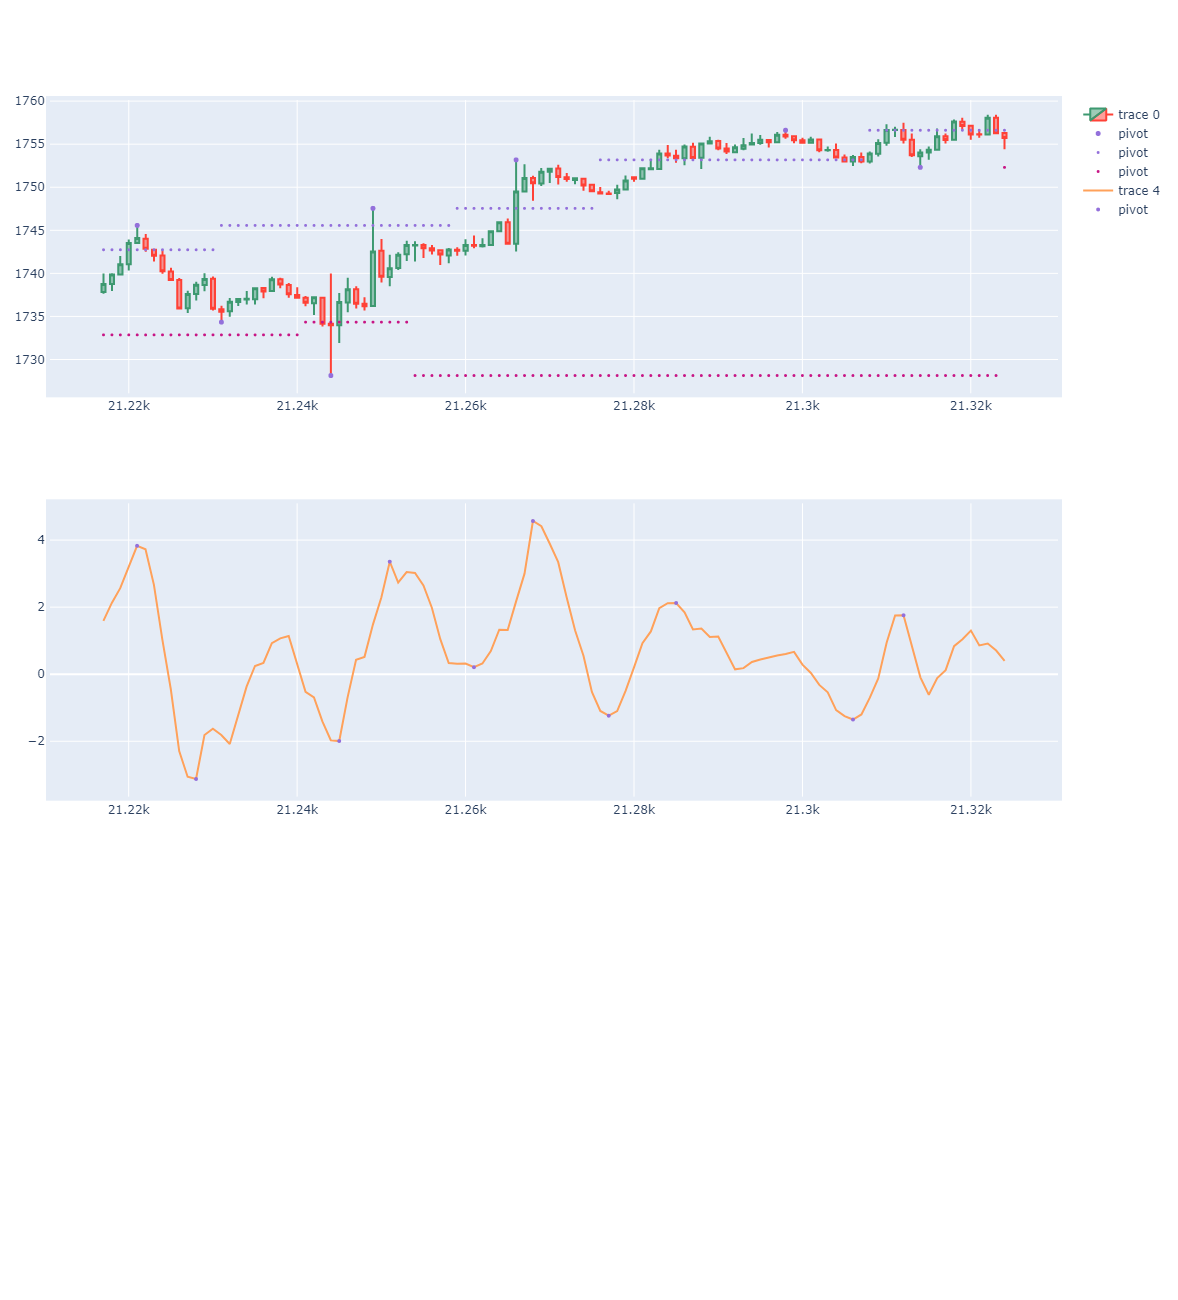

In [300]:
XAU_15m2022_test.graph_init_Sample(21217,21325,height = 1300)

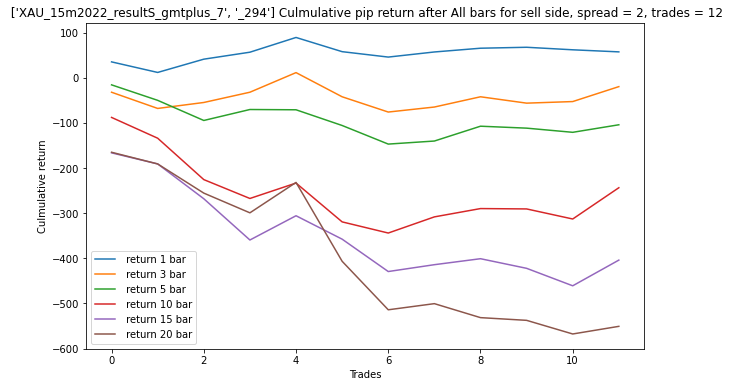

In [312]:
Plot_csPipReturn(XAU_15m2022_resultS_gmtplus_7,side='sell',spread = 2,return_bar='All')

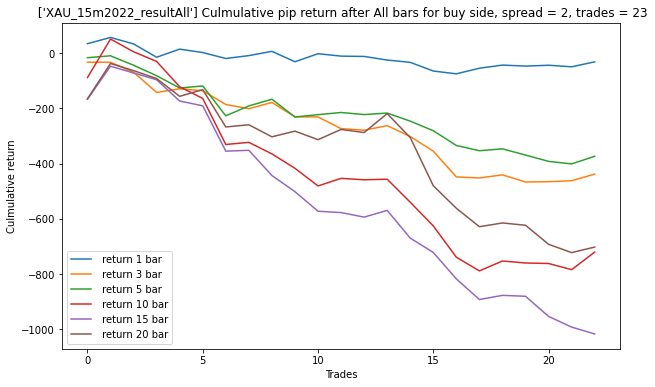

In [335]:
XAU_15m2022_resultAll = GetResultAll(XAU_15m2022_resultS,XAU_15m2022_resultB)
XAU_15m2022_statAll = GetStatAll(XAU_15m2022_resultAll)
Plot_csPipReturn(XAU_15m2022_resultAll, 'buy', 2, "All")

In [336]:
XAU_15m2022_statS

count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  14.0000 -2.1579 21.6065 -37.0000 -16.4125 -1.7150  7.7250   
PipReturn_3bar  14.0000 17.4136 34.1485 -25.9300 -11.2000 18.6600 36.3750   
PipReturn_5bar  14.0000 14.9071 30.7604 -37.8900  -4.7700 20.6850 32.6750   
PipReturn_10bar 14.0000 35.6436 52.7083 -65.7100   1.2025 41.9250 83.3750   
PipReturn_15bar 14.0000 54.3250 49.1567 -17.1700  22.6175 53.2500 85.8375   
PipReturn_20bar 14.0000 47.1314 63.1301 -22.6000  -5.8850 34.9500 76.4725   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   35.7000       -0.0999         -1.3982  
PipReturn_3bar   91.1300        0.5099          7.1391  
PipReturn_5bar   62.5000        0.4846          6.7847  
PipReturn_10bar 111.4000        0.6762          9.4674  
PipReturn_15bar 164.5500        1.1051         15.4719  
PipReturn_20bar 172.7000        0.7466         10.4521

In [337]:
XAU_15m2022_statB

count     mean     std       min      25%      50%     75%  \
PipReturn_1bar  9.0000  -1.6833 24.6278  -46.3000 -11.1000  -6.8000 22.4000   
PipReturn_3bar  9.0000 -16.4678 29.5452  -71.5000 -40.3500  -3.8000  1.6000   
PipReturn_5bar  9.0000 -13.1789 38.3848 -106.3000 -17.0600   7.4000  9.5000   
PipReturn_10bar 9.0000 -19.5256 81.8687 -165.0000 -47.4600 -33.2000  4.1000   
PipReturn_15bar 9.0000 -23.4600 77.4544 -162.4500 -68.9700 -15.4000 -2.8500   
PipReturn_20bar 9.0000   0.3678 77.3037 -133.3500 -28.9500  -9.1000 39.0500   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   31.2000       -0.0684         -0.6152  
PipReturn_3bar   18.5000       -0.5574         -5.0164  
PipReturn_5bar   10.5000       -0.3433         -3.0900  
PipReturn_10bar 141.8000       -0.2385         -2.1465  
PipReturn_15bar 121.8900       -0.3029         -2.7260  
PipReturn_20bar 130.4000        0.0048          0.0428

In [71]:
XAU_15m2022_statAll

count    mean      std       min      25%     50%     75%  \
PipReturn_1bar  197.0000 -0.4054  16.3459  -76.4900  -8.5300 -1.5000  7.5600   
PipReturn_3bar  197.0000 -1.3117  58.6071 -231.8000 -15.6600 -0.7000 12.0700   
PipReturn_10bar 197.0000  4.9652  98.1944 -343.2000 -19.4500  5.2000 27.6000   
PipReturn_20bar 195.0000 31.3778 177.3557 -361.0000 -31.8800  9.5000 53.0550   

                      max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar    54.3000       -0.0248         -4.8862  
PipReturn_3bar   671.1700       -0.0224         -4.4092  
PipReturn_10bar  832.1000        0.0506          9.9614  
PipReturn_20bar 1715.0000        0.1769         34.4994

In [139]:
XAU_15m2022_resultS

index            gmt time      open      high       low     close  \
0    3085 2022-02-17 17:15:00 1897.6730 1898.8780 1897.0280 1897.6280   
1    3110 2022-02-18 00:30:00 1902.1680 1902.3580 1900.1880 1900.1880   
2    7594 2022-04-28 19:30:00 1895.8980 1896.4230 1894.3730 1894.8880   
3    7656 2022-04-29 12:00:00 1919.4180 1919.7050 1914.2680 1916.2060   
4    8630 2022-05-17 07:00:00 1830.1600 1830.1600 1825.8880 1826.6280   
5    9346 2022-05-27 02:00:00 1855.8130 1855.9130 1853.3840 1853.5680   
6   11846 2022-07-03 11:00:00 2002.2880 2002.3180 1998.9320 1999.4480   
7   16473 2022-09-12 16:45:00 1805.6880 1805.9980 1803.9780 1804.4980   
8   20486 2022-11-11 09:00:00 1765.2070 1765.8880 1761.8270 1762.1670   
9   20491 2022-11-11 10:15:00 1765.7280 1766.2880 1763.5380 1764.2080   
10  21132 2022-11-22 08:30:00 1745.6270 1746.0380 1743.2180 1743.4780   
11  22410 2022-12-12 11:45:00 1795.1880 1795.2380 1794.2180 1794.2480   
12  22828 2022-12-19 01:15:00 1794.4850 1794.6750 1793.4680 1793.9850   
13  22857 2022-12-19 08:30:00 1796.8350 1797.2550 1795.2550 1796.4250   

         volume  LogReturn_1bar  LogReturn_3bar  LogReturn_10bar  ...   MACD  \
0   893590.0032          0.0007          0.0006           0.0012  ... 1.0185   
1   289570.0028         -0.0004         -0.0010          -0.0049  ... 1.4477   
2   391790.0043          0.0005          0.0004          -0.0006  ... 3.2283   
3   854509.9980         -0.0020         -0.0028          -0.0019  ... 1.3163   
4   693840.0064         -0.0009         -0.0014           0.0009  ... 1.5297   
5   325260.0004         -0.0000          0.0000           0.0002  ... 2.3282   
6   969280.0083         -0.0023         -0.0047          -0.0176  ... 2.4575   
7  1236279.9963         -0.0005         -0.0032          -0.0032  ... 5.8243   
8  1088319.9908         -0.0001          0.0009          -0.0015  ... 2.8152   
9  1122270.0031         -0.0003         -0.0040          -0.0017  ... 2.2102   
10 1050050.0053          0.0006          0.0009           0.0014  ... 1.7663   
11  530540.0026          0.0000         -0.0014          -0.0034  ... 1.8227   
12  269649.9972          0.0002          0.0001          -0.0001  ... 1.2238   
13  204920.0009          0.0002          0.0002          -0.0002  ... 2.4283   

       RSI    ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  \
0  64.7509 3.4405      0          0       NaN           NaN          1.0000   
1  60.8362 2.1177      2          0 1902.3581           NaN          1.0000   
2  57.4997 2.9307      0          2       NaN        3.2284          1.0000   
3  61.7665 2.5275      0          0       NaN           NaN          1.0000   
4  56.4796 2.1055      0          0       NaN           NaN          1.0000   
5  55.5424 1.8419      0          0       NaN           NaN          1.0000   
6  75.7867 4.6047      0          0       NaN           NaN          1.0000   
7  65.5153 3.3134      2          2 1805.9981        5.8244          1.0000   
8  71.5573 3.6124      0          2       NaN        2.8153          1.0000   
9  71.1406 3.4053      0          0       NaN           NaN          1.0000   
10 53.3327 1.7202      0          0       NaN           NaN          1.0000   
11 77.4853 2.1338      0          2       NaN        1.8228          1.0000   
12 58.9783 1.7593      0          0       NaN           NaN          1.0000   
13 60.3887 1.7329      0          0       NaN           NaN          1.0000   

     CurrLow  CurrHigh  
0  1882.6880 1897.6680  
1  1882.6880 1901.0160  
2  1881.8230 1895.2480  
3  1892.4680 1917.7880  
4  1821.7280 1829.2680  
5  1840.7980 1853.7230  
6  1976.1020 2000.9400  
7  1789.9670 1805.0180  
8  1663.7650 1764.2280  
9  1755.3370 1764.2280  
10 1740.1580 1745.5480  
11 1785.3080 1794.8680  
12 1790.8350 1794.1980  
13 1790.2150 1796.7850  

[14 rows x 27 columns]

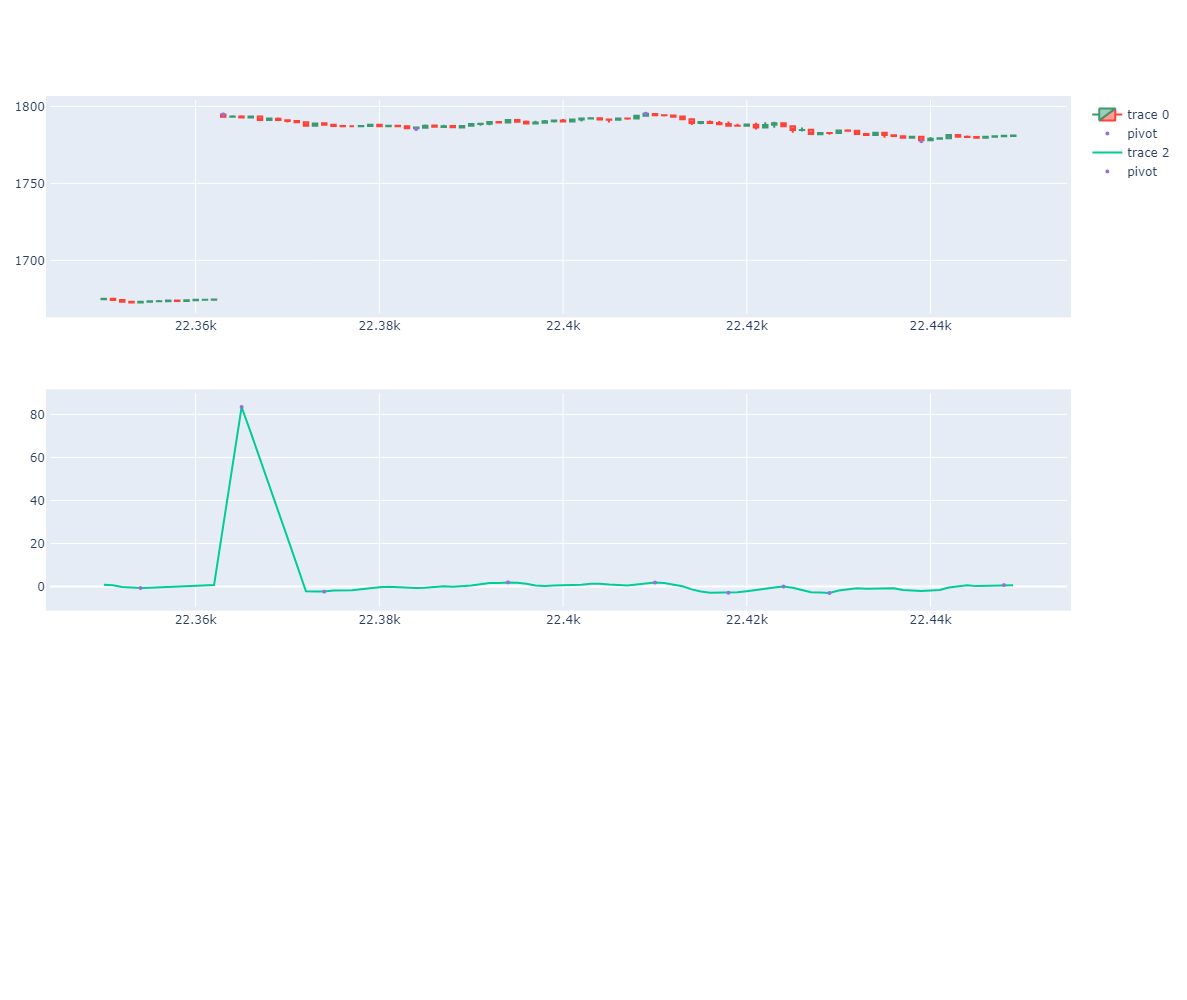

In [143]:
XAU_15m2022_test.graph_init_Sample(22350,22450,height= 1000)

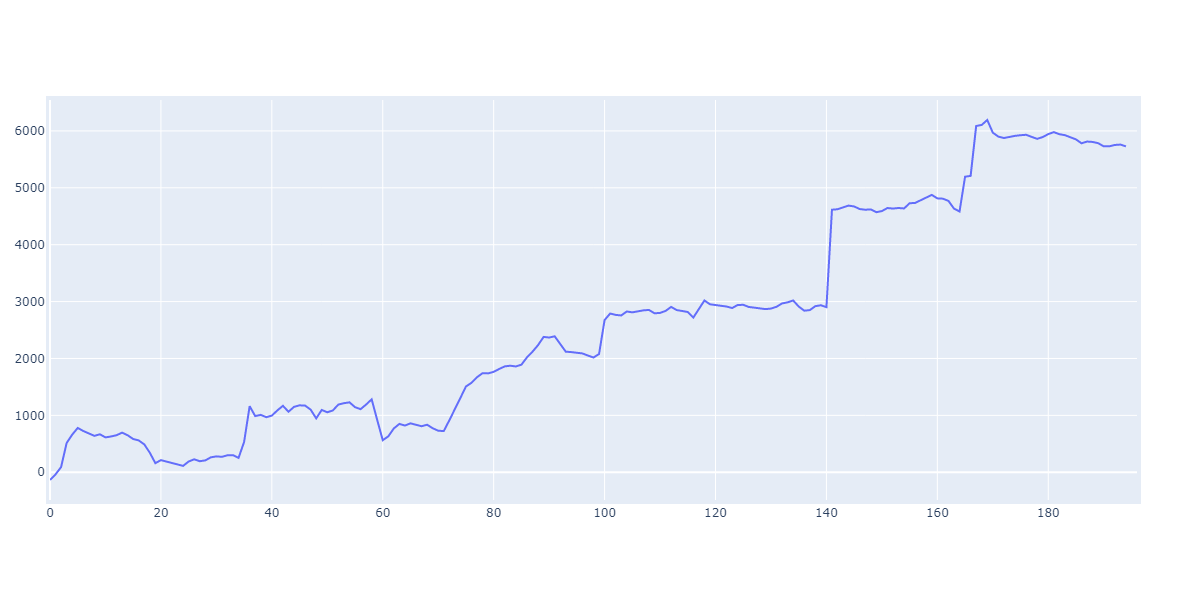

In [73]:
dfpl = XAU_15m2022_resultAll
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl.index,y=dfpl['PipReturn_20bar_cumsum']), row = 1, col = 1)    
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

#### 2022 - 2023 Oanda - Tradingview data

In [181]:
print(os.listdir("D:/Data/Forex/XAUUSD/"))

['DUKAS_XAUUSD_Candlestick_15_M_BID_01.01.2020-01.01.2023.csv', 'DUKAS_XAUUSD_Candlestick_15_M_BID_01.01.2022-14.01.2023.csv', 'DUKAS_XAUUSD_Candlestick_5_M_BID_01.01.2021-01.05.2021.csv', 'OANDA_XAUUSD, 15, 0822_0223.csv', 'OANDA_XAUUSD, 15, 121322_012723.csv', 'OANDA_XAUUSD, 15.csv', 'OANDA_XAUUSD, 5, 1222_0223 .csv', 'XAUUSD div 10,10, 15M, 1222_0123.pdf', 'XAUUSD_Candlestick_15_M_BID_01.01.2017-01.01.2020.csv']


In [302]:
XAU15M_121322_012723 = pd.read_csv("D:/Data/Forex/XAUUSD/OANDA_XAUUSD, 15, 0822_0223.csv")

XAU15M_121322_012723_test = TradingTest(XAU15M_121322_012723,pipRetMulti=10)

In [303]:
compare_range = 10

In [304]:
XAU15M_121322_012723_test.gen_pivot(compare_range,compare_range)

pivot point generated with comparative range of( 10, 10 ) candle


In [305]:
XAU15M_121322_012723_test.gen_divSignal2(compare_range*10,compare_range)

divergence sigal generated with comparative range of( 10, 10 ) candle


In [306]:
XAU15M_121322_012723_test.df.divSignal2MACD.value_counts()

1.0000    1675
2.0000    1409
0.0000     245
Name: divSignal2MACD, dtype: int64

In [310]:
XAU15M_121322_012723_test.df

time      open      high       low     close  \
0      2022-08-01T05:00:00+07:00 1766.2600 1766.2600 1764.6500 1765.1350   
1      2022-08-01T05:15:00+07:00 1765.1350 1765.1800 1764.1700 1764.2750   
2      2022-08-01T05:30:00+07:00 1764.2750 1764.2750 1763.4150 1763.7650   
3      2022-08-01T05:45:00+07:00 1763.7650 1763.7650 1763.1100 1763.3800   
4      2022-08-01T06:00:00+07:00 1763.3800 1763.5500 1763.1300 1763.5150   
...                          ...       ...       ...       ...       ...   
11757  2023-01-30T11:00:00+07:00 1926.3900 1930.5450 1926.1450 1930.4250   
11758  2023-01-30T11:15:00+07:00 1930.4250 1931.9800 1929.5050 1931.4700   
11759  2023-01-30T11:30:00+07:00 1931.4700 1933.9100 1931.3600 1933.4550   
11760  2023-01-30T11:45:00+07:00 1933.4550 1934.5650 1932.5300 1933.4650   
11761  2023-01-30T12:00:00+07:00 1933.4650 1933.6000 1933.1250 1933.3250   

       upper 2nd  basis 2nd  lower 2nd  volume  volume ma  ...    ATR  pivot  \
0            NaN        NaN        NaN     353        NaN  ...    NaN      0   
1            NaN        NaN        NaN     329        NaN  ...    NaN      0   
2            NaN        NaN        NaN     304        NaN  ...    NaN      0   
3            NaN        NaN        NaN     196        NaN  ...    NaN      0   
4            NaN        NaN        NaN     186        NaN  ...    NaN      0   
...          ...        ...        ...     ...        ...  ...    ...    ...   
11757        NaN        NaN        NaN     793   532.9500  ... 2.0656      0   
11758        NaN        NaN        NaN     589   538.4000  ... 2.0860      0   
11759        NaN        NaN        NaN     464   547.5500  ... 2.1092      0   
11760        NaN        NaN        NaN     391   558.9500  ... 2.1055      0   
11761        NaN        NaN        NaN      34   542.4500  ... 2.0240      0   

       MACDpivot  pointpos  MACDpointpos  divSignal2MACD   CurrLow  CurrHigh  \
0              0       NaN           NaN          2.0000    0.0000    0.0000   
1              0       NaN           NaN          2.0000    0.0000    0.0000   
2              0       NaN           NaN          2.0000    0.0000    0.0000   
3              0       NaN           NaN          2.0000    0.0000    0.0000   
4              0       NaN           NaN          2.0000    0.0000    0.0000   
...          ...       ...           ...             ...       ...       ...   
11757          0       NaN           NaN             NaN 1916.7450 1931.1300   
11758          0       NaN           NaN             NaN 1916.7450 1931.1300   
11759          0       NaN           NaN             NaN 1916.7450 1931.1300   
11760          0       NaN           NaN             NaN 1916.7450 1931.1300   
11761          0       NaN           NaN             NaN 1916.7450 1931.1300   

       maxHi10bar  maxLo10bar  
0             NaN         NaN  
1             NaN         NaN  
2             NaN         NaN  
3             NaN         NaN  
4             NaN         NaN  
...           ...         ...  
11757   1930.5450   1924.4750  
11758   1931.9800   1924.4750  
11759   1933.9100   1924.4750  
11760   1934.5650   1924.4750  
11761   1934.5650   1924.4750  

[11762 rows x 47 columns]

C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.4, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.4, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
Sell stats


count     mean     std      min      25%      50%     75%  \
PipReturn_1bar  2.0000   5.8750  7.4600   0.6000   3.2375   5.8750  8.5125   
PipReturn_3bar  2.0000 -16.0000 18.8798 -29.3500 -22.6750 -16.0000 -9.3250   
PipReturn_5bar  2.0000 -11.4000 14.8492 -21.9000 -16.6500 -11.4000 -6.1500   
PipReturn_10bar 2.0000  16.5500 30.3349  -4.9000   5.8250  16.5500 27.2750   
PipReturn_15bar 2.0000  -8.5000  4.3134 -11.5500 -10.0250  -8.5000 -6.9750   
PipReturn_20bar 2.0000  34.6000 33.1633  11.1500  22.8750  34.6000 46.3250   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  11.1500        0.7875          1.5751  
PipReturn_3bar  -2.6500       -0.8475         -1.6949  
PipReturn_5bar  -0.9000       -0.7677         -1.5354  
PipReturn_10bar 38.0000        0.5456          1.0912  
PipReturn_15bar -5.4500       -1.9706         -3.9413  
PipReturn_20bar 58.0500        1.0433          2.0866

Buy Stats


count    mean  std     min     25%     50%     75%     max  \
PipReturn_1bar  1.0000  7.5000  NaN  7.5000  7.5000  7.5000  7.5000  7.5000   
PipReturn_3bar  1.0000 18.9000  NaN 18.9000 18.9000 18.9000 18.9000 18.9000   
PipReturn_5bar  1.0000 38.2500  NaN 38.2500 38.2500 38.2500 38.2500 38.2500   
PipReturn_10bar 1.0000 66.2500  NaN 66.2500 66.2500 66.2500 66.2500 66.2500   
PipReturn_15bar 1.0000 55.5000  NaN 55.5000 55.5000 55.5000 55.5000 55.5000   
PipReturn_20bar 1.0000 62.3500  NaN 62.3500 62.3500 62.3500 62.3500 62.3500   

                 Sharpe ratio  Count x Sharpe  
PipReturn_1bar            NaN             NaN  
PipReturn_3bar            NaN             NaN  
PipReturn_5bar            NaN             NaN  
PipReturn_10bar           NaN             NaN  
PipReturn_15bar           NaN             NaN  
PipReturn_20bar           NaN             NaN

All Stats


count    mean     std      min      25%      50%     75%  \
PipReturn_1bar  3.0000 -1.4167  9.3518 -11.1500  -5.8750  -0.6000  3.4500   
PipReturn_3bar  3.0000 16.9667 13.4546   2.6500  10.7750  18.9000 24.1250   
PipReturn_5bar  3.0000 20.3500 18.7232   0.9000  11.4000  21.9000 30.0750   
PipReturn_10bar 3.0000 11.0500 52.3964 -38.0000 -16.5500   4.9000 35.5750   
PipReturn_15bar 3.0000 24.1667 27.3063   5.4500   8.5000  11.5500 33.5250   
PipReturn_20bar 3.0000 -2.2833 60.6878 -58.0500 -34.6000 -11.1500 25.6000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   7.5000       -0.1515         -0.4545  
PipReturn_3bar  29.3500        1.2610          3.7831  
PipReturn_5bar  38.2500        1.0869          3.2607  
PipReturn_10bar 66.2500        0.2109          0.6327  
PipReturn_15bar 55.5000        0.8850          2.6551  
PipReturn_20bar 62.3500       -0.0376         -0.1129

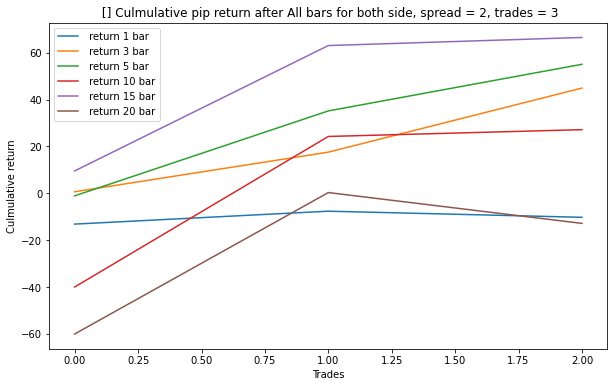

None

In [322]:
XAU15M_121322_012723_test.test_falseBreakSig2MACD(ATR_surpass=0.4)

In [315]:
XAU15M_121322_012723_test.result_Sell

index                       time      open      high       low     close  \
0    592  2022-08-09T15:00:00+07:00 1787.1800 1791.6100 1786.5450 1790.6450   
1   7659  2022-11-24T14:00:00+07:00 1755.3050 1757.6000 1755.1000 1756.8200   

   upper 2nd  basis 2nd  lower 2nd  volume  ...    ATR  pivot  MACDpivot  \
0        NaN        NaN        NaN    1377  ... 1.6989      0          0   
1        NaN        NaN        NaN     641  ... 1.5233      0          0   

   pointpos  MACDpointpos  divSignal2MACD   CurrLow  CurrHigh  maxHi10bar  \
0       NaN           NaN          1.0000 1783.3100 1790.7800   1791.6100   
1       NaN           NaN          1.0000 1727.4950 1756.9700   1757.6000   

   maxLo10bar  
0   1783.5850  
1   1752.6850  

[2 rows x 48 columns]

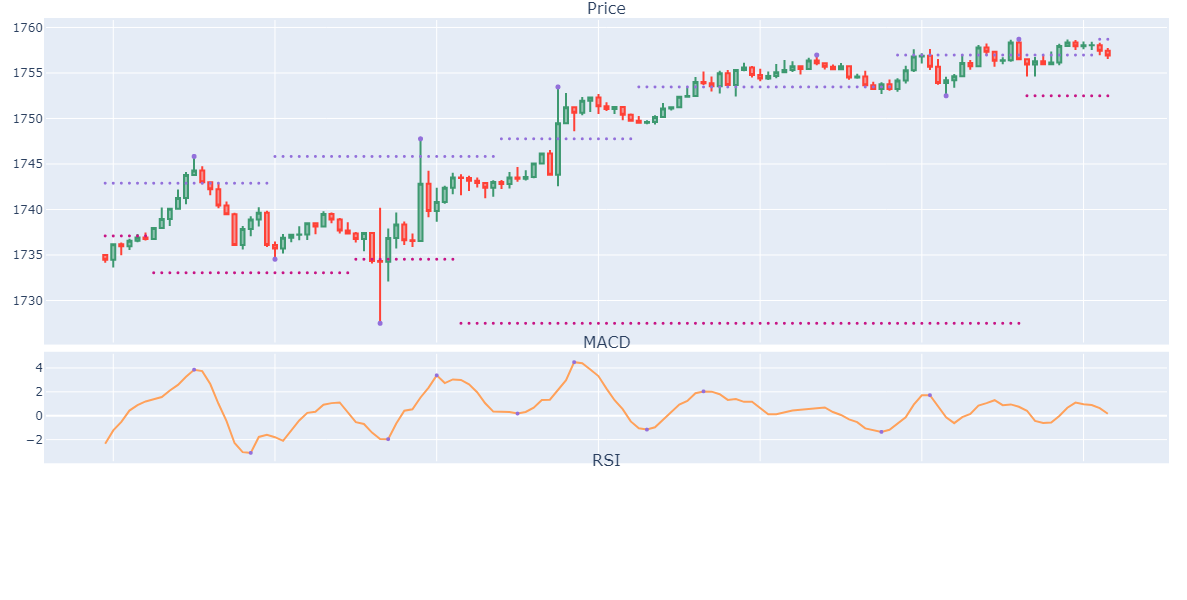

In [316]:
a = 7659
XAU15M_121322_012723_test.graph_Sample(a-100, a+25)

## GBPJPY

### 15 Min

#### Tradng View Data

In [118]:
print(os.listdir("D:/Data/Forex/GBPJPY/OANDA_GBPJPY, 15, 0922_0223.csv"))

NotADirectoryError: [WinError 267] The directory name is invalid: 'D:/Data/Forex/GBPJPY/OANDA_GBPJPY, 15, 0922_0223.csv'

In [119]:
GJ15M_0822_0223 = pd.read_csv("D:/Data/Forex/GBPJPY/OANDA_GBPJPY, 15, 0922_0223.csv")

In [120]:
GJ15M_0822_0223_test = TradingTest(GJ15M_0822_0223,pipRetMulti=100)

In [121]:
GJ15M_0822_0223_test.gen_pivot(10,10)

pivot point generated with comparative range of( 10, 10 ) candle


In [122]:
GJ15M_0822_0223_test.gen_divSignal2(100,10)

time     open     high      low    close  \
0      2022-09-02T21:30:00+07:00 162.1350 162.3640 162.1350 162.2740   
1      2022-09-02T21:45:00+07:00 162.2740 162.3700 162.1390 162.2140   
2      2022-09-02T22:00:00+07:00 162.2140 162.2540 162.1140 162.1520   
3      2022-09-02T22:15:00+07:00 162.1520 162.2480 162.1120 162.1420   
4      2022-09-02T22:30:00+07:00 162.1420 162.2360 162.1190 162.1440   
...                          ...      ...      ...      ...      ...   
10152  2023-01-31T17:30:00+07:00 160.6560 160.6770 160.5580 160.6180   
10153  2023-01-31T17:45:00+07:00 160.6180 160.6800 160.5540 160.5650   
10154  2023-01-31T18:00:00+07:00 160.5650 160.6250 160.5180 160.5860   
10155  2023-01-31T18:15:00+07:00 160.5860 160.6280 160.5200 160.5420   
10156  2023-01-31T18:30:00+07:00 160.5420 160.6720 160.5340 160.6195   

       upper 2nd  basis 2nd  lower 2nd  volume  volume ma  ...  UpperWick  \
0            NaN        NaN        NaN    4184  4125.8000  ...     0.0900   
1            NaN        NaN        NaN    4749  4246.1000  ...     0.1560   
2            NaN        NaN        NaN    3517  4300.3000  ...     0.1020   
3            NaN        NaN        NaN    3002  4358.5000  ...     0.1060   
4            NaN        NaN        NaN    3135  4420.5500  ...     0.0920   
...          ...        ...        ...     ...        ...  ...        ...   
10152        NaN        NaN        NaN    2277  2580.8500  ...     0.0590   
10153        NaN        NaN        NaN    2213  2578.5000  ...     0.1150   
10154        NaN        NaN        NaN    2043  2579.3000  ...     0.0390   
10155        NaN        NaN        NaN    2060  2612.9500  ...     0.0860   
10156        NaN        NaN        NaN    2113  2646.5500  ...     0.0525   

       LowerWick    MACD     RSI    ATR  pivot  MACDpivot  pointpos  \
0         0.1390     NaN     NaN    NaN      0          0       NaN   
1         0.0750     NaN     NaN    NaN      0          0       NaN   
2         0.0380     NaN     NaN    NaN      0          0       NaN   
3         0.0300     NaN     NaN    NaN      0          0       NaN   
4         0.0250     NaN     NaN    NaN      0          0       NaN   
...          ...     ...     ...    ...    ...        ...       ...   
10152     0.0600  0.0513 44.9523 0.1375      0          0       NaN   
10153     0.0110  0.0440 43.7487 0.1369      0          0       NaN   
10154     0.0680  0.0125 44.3594 0.1354      0          0       NaN   
10155     0.0220 -0.0166 43.3395 0.1340      0          0       NaN   
10156     0.0855 -0.0101 45.6176 0.1342      0          0       NaN   

       MACDpointpos  divSignal2MACD  
0               NaN             NaN  
1               NaN             NaN  
2               NaN             NaN  
3               NaN             NaN  
4               NaN             NaN  
...             ...             ...  
10152           NaN             NaN  
10153           NaN             NaN  
10154           NaN             NaN  
10155           NaN             NaN  
10156           NaN             NaN  

[10157 rows x 43 columns]

In [124]:
GJ15M_0822_0223_test.df.divSignal2MACD.value_counts()

1.0000    1492
2.0000    1412
0.0000     266
Name: divSignal2MACD, dtype: int64

In [374]:
GJ15M_0822_0223_resultS, GJ15M_0822_0223_statS = falsebreak_wDiv_test(GJ15M_0822_0223_test.df,side = 'sell',
                                                             elim_cons_trade = True , falsebreak_bar= 0,
                                                             ATR_surpass= 0.2, fwdCandle=10,
                                                             ATR_commpare_range=0
                                                             )
GJ15M_0822_0223_resultB, GJ15M_0822_0223_statB = falsebreak_wDiv_test(GJ15M_0822_0223_test.df,side = 'buy',
                                                             elim_cons_trade = True , falsebreak_bar= 0,
                                                             ATR_surpass= 0.2,fwdCandle=10,
                                                             ATR_commpare_range=0)


NameError: name 'GJ15M_0822_0223_test' is not defined

In [562]:
GJ15M_0822_0223_statS

count     mean     std       min      25%     50%     75%  \
PipReturn_1bar  6.0000  -6.1833 10.1645  -18.3000 -11.4000 -6.2500 -5.3000   
PipReturn_3bar  6.0000 -12.9167 32.5618  -69.5000 -21.4750 -7.7000  3.9000   
PipReturn_5bar  6.0000  -6.8333 55.7426 -110.3000 -18.6000 20.2000 22.8500   
PipReturn_10bar 6.0000 -32.1667 67.9472 -157.4000 -48.4250 -6.5500 10.7250   
PipReturn_15bar 6.0000 -18.9500 34.9384  -79.3000 -31.4000 -9.0000  1.4000   
PipReturn_20bar 6.0000 -24.7167 81.2443 -188.9000  -8.3000 11.4000 14.3000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  11.8000       -0.6083         -3.6499  
PipReturn_3bar  25.7000       -0.3967         -2.3801  
PipReturn_5bar  36.7000       -0.1226         -0.7355  
PipReturn_10bar 23.4000       -0.4734         -2.8404  
PipReturn_15bar 17.6000       -0.5424         -3.2543  
PipReturn_20bar 17.4000       -0.3042         -1.8254

In [563]:
GJ15M_0822_0223_statB

count    mean     std      min     25%     50%     75%  \
PipReturn_1bar  4.0000  8.7500 20.6310  -6.3000 -3.4500  1.2000 13.4000   
PipReturn_3bar  4.0000  9.1250 18.7566  -5.2000 -4.4500  3.3500 16.9250   
PipReturn_5bar  4.0000  7.0000 16.8815  -3.8000 -2.9000 -0.1000  9.8000   
PipReturn_10bar 4.0000 35.4500 38.6290   1.0000  8.9500 26.8000 53.3000   
PipReturn_15bar 4.0000 35.6750 26.3076   7.8000 17.4000 34.5500 52.8250   
PipReturn_20bar 4.0000 19.0750 32.2188 -17.0000 -3.6500 23.0500 45.7750   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  38.9000        0.4241          1.6965  
PipReturn_3bar  35.0000        0.4865          1.9460  
PipReturn_5bar  32.0000        0.4147          1.6586  
PipReturn_10bar 87.2000        0.9177          3.6708  
PipReturn_15bar 65.8000        1.3561          5.4243  
PipReturn_20bar 47.2000        0.5920          2.3682

In [567]:
GJ15M_0822_0223_resultB.tail(5)

index                       time     open     high      low    close  \
0    663  2022-09-13T19:15:00+07:00 166.4920 166.5480 166.1340 166.4560   
1   4037  2022-11-01T22:45:00+07:00 169.8080 169.8890 169.5810 169.7340   
2   6712  2022-12-09T20:30:00+07:00 166.7640 167.1810 166.3090 166.9680   
3   7930  2022-12-29T13:00:00+07:00 160.9230 160.9390 160.7240 160.8780   

   upper 2nd  basis 2nd  lower 2nd  volume  ...    ATR  pivot  MACDpivot  \
0        NaN        NaN        NaN    3842  ... 0.1675      1          0   
1        NaN        NaN        NaN    5174  ... 0.2264      0          0   
2        NaN        NaN        NaN    9786  ... 0.1901      1          0   
3        NaN        NaN        NaN    1504  ... 0.1363      1          0   

   pointpos  MACDpointpos  divSignal2MACD  CurrLow  CurrHigh  maxHi10bar  \
0  166.1339           NaN          2.0000 166.3670  166.9380    166.7710   
1       NaN           NaN          2.0000 169.6660  170.9580    170.4940   
2  166.3089           NaN          2.0000 166.5040  167.2070    167.1810   
3  160.7239           NaN          2.0000 160.7600  161.7020    161.1600   

   maxLo10bar  
0    166.1340  
1    169.5810  
2    166.3090  
3    160.7240  

[4 rows x 48 columns]

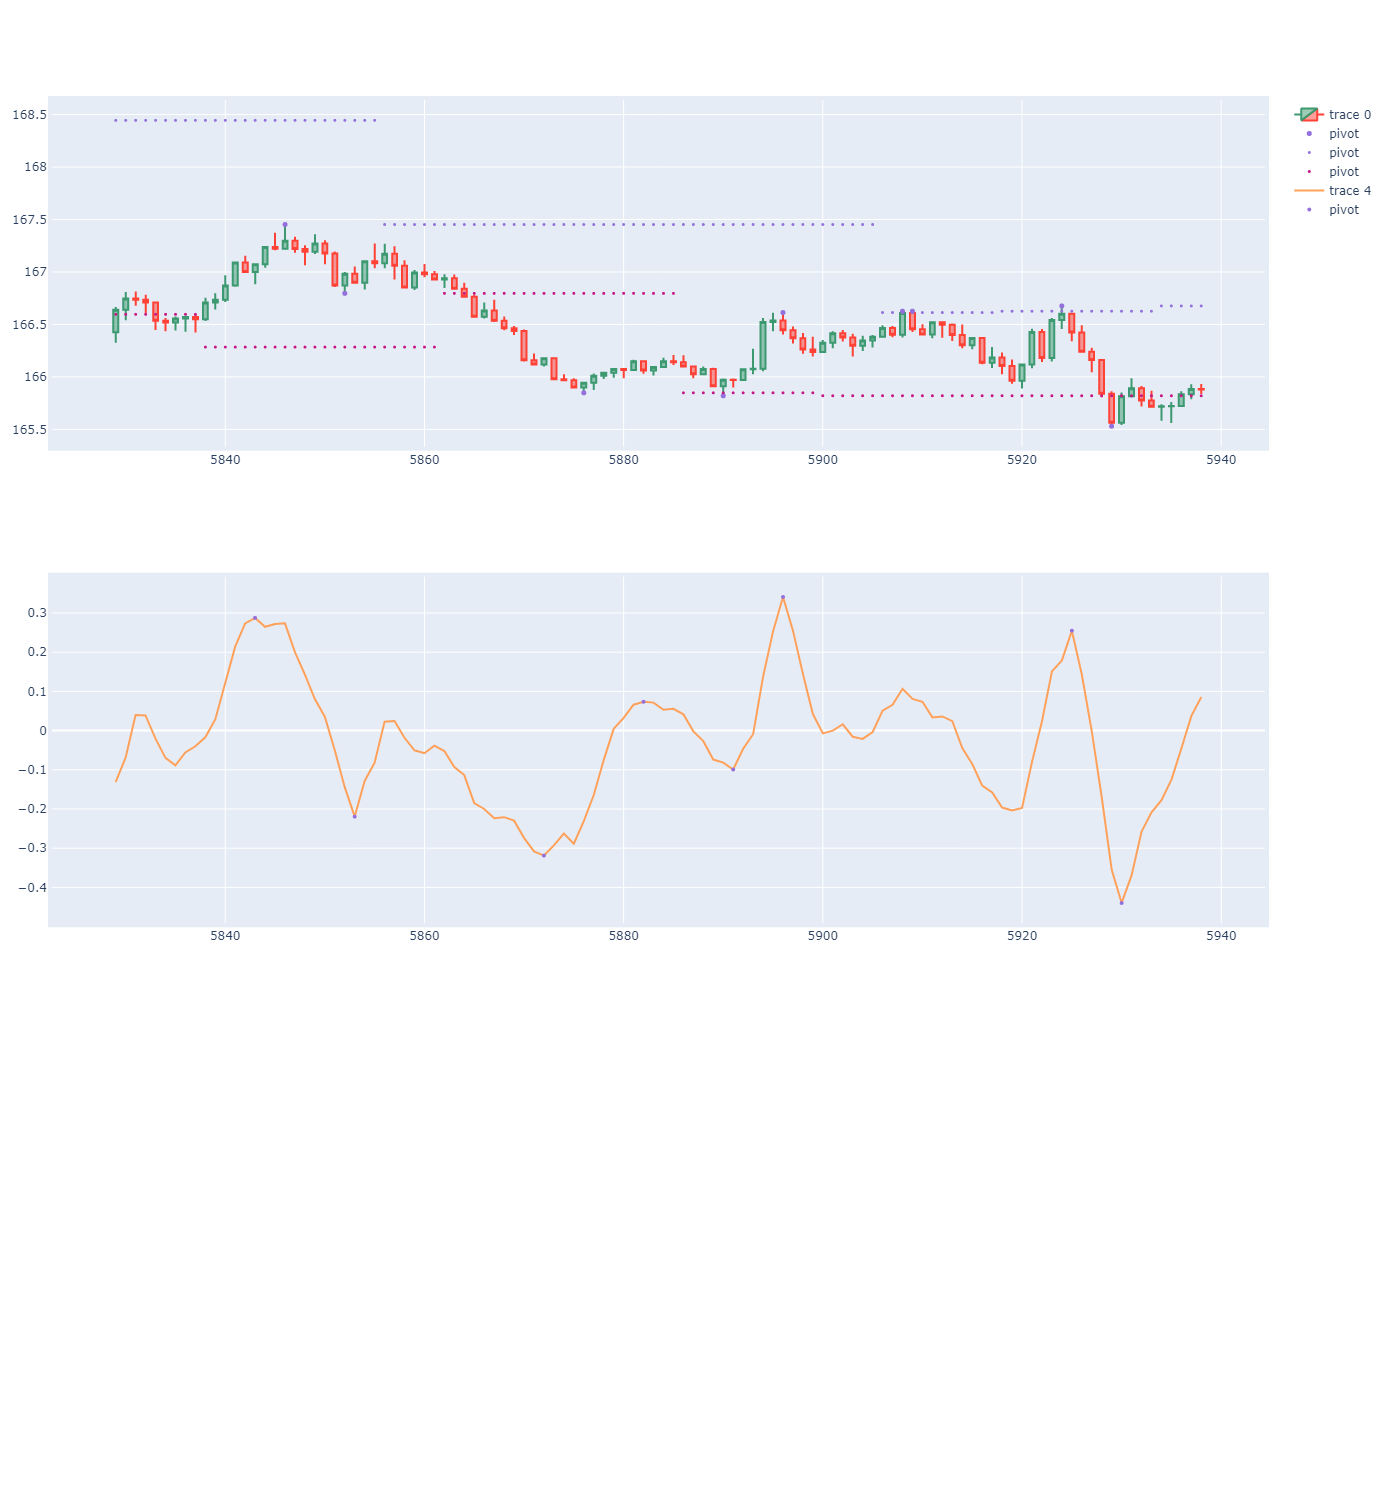

In [146]:
GJ15M_0822_0223_test.graph_init_Sample(5829,5939,height=1500)

In [566]:
GJ15M_0822_0223_resultAll = GetResultAll(GJ15M_0822_0223_resultS,GJ15M_0822_0223_resultB)
GJ15M_0822_0223_stattAll = GetStatAll(GJ15M_0822_0223_resultAll)
GJ15M_0822_0223_stattAll

count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  10.0000  7.2100 14.1787 -11.8000  -0.6500  5.3000 11.4000   
PipReturn_3bar  10.0000 11.4000 26.6485 -25.7000  -4.9500  7.7000 21.5500   
PipReturn_5bar  10.0000  6.9000 42.6761 -36.7000 -21.3000 -3.2000 23.7000   
PipReturn_10bar 10.0000 33.4800 55.3640 -23.4000  -0.8750 13.1000 55.2750   
PipReturn_15bar 10.0000 25.6400 31.3601 -17.6000   7.6500 15.5000 45.9750   
PipReturn_20bar 10.0000 22.4600 63.4155 -17.4000 -14.3000 -4.3000 37.5250   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   38.9000        0.5085          5.0851  
PipReturn_3bar   69.5000        0.4278          4.2779  
PipReturn_5bar  110.3000        0.1617          1.6168  
PipReturn_10bar 157.4000        0.6047          6.0473  
PipReturn_15bar  79.3000        0.8176          8.1760  
PipReturn_20bar 188.9000        0.3542          3.5417

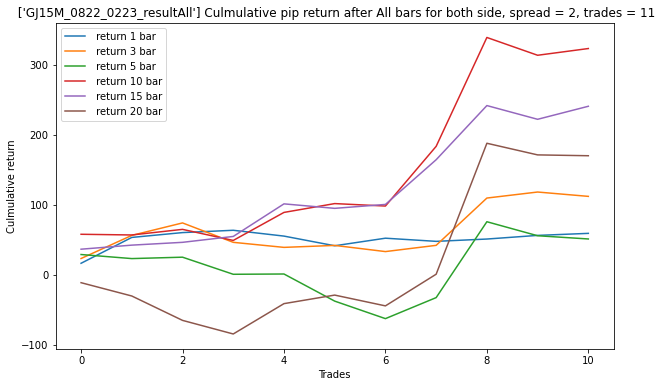

In [178]:
Plot_csPipReturn(GJ15M_0822_0223_resultAll,'All',2,'All')

In [338]:
print(os.listdir("D:/Data/Forex/GBPJPY/"))

['DUKAS_GBPJPY_Candlestick_15_M_BID_01.10.2020-01.01.2023.csv', 'DUKAS_GBPJPY_Candlestick_1_Hour_BID_01.01.2015-14.01.2023.csv']


In [339]:
GJ15M_20_23 = pd.read_csv("D:/Data/Forex/GBPJPY/DUKAS_GBPJPY_Candlestick_15_M_BID_01.10.2020-01.01.2023.csv")

In [340]:
GJ15M_20_23['Gmt time'] = pd.to_datetime(GJ15M_20_23['Gmt time'])

In [341]:
GJ15M_2020 = GJ15M_20_23[GJ15M_20_23['Gmt time'] < '2021-1-1']
GJ15M_2021 = GJ15M_20_23[(GJ15M_20_23['Gmt time'] > '2021-1-1') &  (GJ15M_20_23['Gmt time'] < '2022-1-1')]
GJ15M_2022 = GJ15M_20_23[GJ15M_20_23['Gmt time'] >= '2022-1-1']

In [342]:
GJ15M_2021[GJ15M_2021['Gmt time'] == '2021-11-18']

Gmt time     Open     High      Low    Close          Volume
28161 2021-11-18 154.0210 154.1090 154.0040 154.0340 1099259998.3215

In [353]:
GJ15M_20_23_statS

count   mean     std       min      25%    50%     75%  \
PipReturn_1bar  48.0000 1.9500 18.3089  -95.2000  -3.7250 2.0500  9.6000   
PipReturn_3bar  48.0000 0.0625 23.2237  -91.8000  -9.4500 0.6500 10.1750   
PipReturn_5bar  48.0000 2.4958 29.3017  -93.2000  -7.9000 0.7000 20.2000   
PipReturn_10bar 48.0000 1.8083 32.7570  -85.6000 -13.3250 2.4000 14.8000   
PipReturn_15bar 48.0000 4.0562 39.9675 -118.2000 -12.9750 4.7500 19.9750   
PipReturn_20bar 48.0000 4.6354 44.0059  -88.7000 -14.0250 3.4500 22.9250   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   44.7000        0.1065          5.1123  
PipReturn_3bar   63.8000        0.0027          0.1292  
PipReturn_5bar   55.4000        0.0852          4.0885  
PipReturn_10bar  77.9000        0.0552          2.6498  
PipReturn_15bar  99.8000        0.1015          4.8715  
PipReturn_20bar 113.4000        0.1053          5.0561

#### DUKASCOPY DATA

##### 2022-2023

In [232]:
GJ15M_0122_0223 = pd.read_csv('D:Data/Forex/GBPJPY/DUKAS_GBPJPY_Candlestick_15_M_BID_01.01.2022-09.02.2023.csv')
GJ15M_0122_0223['Local time'] = pd.to_datetime(GJ15M_0122_0223['Local time'], dayfirst = True )
GJ15M_0122_0223 = GJ15M_0122_0223.sort_values(by = 'Local time')
GJ15M_0122_0223.reset_index(drop = True)

Local time     Open     High      Low    Close  \
0     2022-01-01 00:00:00-07:00 155.8670 155.9160 155.7120 155.7220   
1     2022-01-01 00:15:00-07:00 155.7230 155.7880 155.6930 155.6930   
2     2022-01-01 00:30:00-07:00 155.6940 155.7640 155.6940 155.7490   
3     2022-01-01 00:45:00-07:00 155.7490 155.7520 155.6710 155.6780   
4     2022-01-01 01:00:00-07:00 155.6780 155.7530 155.6630 155.7490   
...                         ...      ...      ...      ...      ...   
27722 2023-02-09 22:45:00-07:00 159.2800 159.3280 159.1950 159.3110   
27723 2023-02-09 23:00:00-07:00 159.3150 159.4080 159.2880 159.3950   
27724 2023-02-09 23:15:00-07:00 159.3930 159.4110 159.2930 159.3000   
27725 2023-02-09 23:30:00-07:00 159.3080 159.3080 159.1770 159.2650   
27726 2023-02-09 23:45:00-07:00 159.2660 159.2860 159.1100 159.2200   

               Volume  
0     1342300003.0517  
1     1172060001.3734  
2     1004019989.0139  
3     1604660022.7355  
4     1051839996.3379  
...               ...  
27722 4697449951.1720  
27723 4944309997.5586  
27724 3442740036.0108  
27725 3869350021.3622  
27726 3013360031.1282  

[27727 rows x 6 columns]

In [241]:
GJ15M_0122_0223.tail(10)

Local time     Open     High      Low    Close  \
27717 2023-02-09 21:30:00-07:00 159.0110 159.1430 158.9480 159.1010   
27718 2023-02-09 21:45:00-07:00 159.1030 159.1630 159.0510 159.0930   
27719 2023-02-09 22:00:00-07:00 159.0930 159.3050 159.0930 159.2950   
27720 2023-02-09 22:15:00-07:00 159.2950 159.3200 159.2420 159.2470   
27721 2023-02-09 22:30:00-07:00 159.2470 159.3100 159.2090 159.2790   
27722 2023-02-09 22:45:00-07:00 159.2800 159.3280 159.1950 159.3110   
27723 2023-02-09 23:00:00-07:00 159.3150 159.4080 159.2880 159.3950   
27724 2023-02-09 23:15:00-07:00 159.3930 159.4110 159.2930 159.3000   
27725 2023-02-09 23:30:00-07:00 159.3080 159.3080 159.1770 159.2650   
27726 2023-02-09 23:45:00-07:00 159.2660 159.2860 159.1100 159.2200   

               Volume  
27717 5956149902.3440  
27718 5131120010.3760  
27719 4800590026.8554  
27720 4717950027.4658  
27721 5018770019.5312  
27722 4697449951.1720  
27723 4944309997.5586  
27724 3442740036.0108  
27725 3869350021.3622  
27726 3013360031.1282

###### 1st Half

In [242]:
GJ15M_0122_0223_H1 = GJ15M_0122_0223.iloc[0:round(len(GJ15M_0122_0223)/2)].reset_index(drop = True)

In [244]:
GJ15M_0122_0223_H1_test = TradingTest(GJ15M_0122_0223_H1,100)

In [245]:
GJ15M_0122_0223_H1_test.gen_pivot(10,10)

pivot point generated with comparative range of( 10, 10 ) candle


In [246]:
GJ15M_0122_0223_H1_test.gen_divSignal2(100,10)

divergence sigal generated with comparative range of( 10, 10 ) candle


In [297]:
GJ15M_0122_0223_H1_test.test_falseBreakSig2MACD(ATR_surpass=0.4)

C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.4, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.4, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
Sell stats


count     mean     std      min      25%      50%      75%  \
PipReturn_1bar  3.0000 -23.9667 61.7025 -95.2000 -42.4000  10.4000  11.6500   
PipReturn_3bar  3.0000 -40.5333 46.9281 -91.8000 -60.9500 -30.1000 -14.9000   
PipReturn_5bar  3.0000 -48.8333 46.8173 -93.2000 -73.3000 -53.4000 -26.6500   
PipReturn_10bar 3.0000 -38.4333 44.3017 -85.6000 -58.8000 -32.0000 -14.8500   
PipReturn_15bar 3.0000 -29.5667 41.2991 -75.5000 -46.6000 -17.7000  -6.6000   
PipReturn_20bar 3.0000 -25.0000 35.7948 -65.3000 -39.0500 -12.8000  -4.8500   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  12.9000       -0.3884         -1.1653  
PipReturn_3bar   0.3000       -0.8637         -2.5912  
PipReturn_5bar   0.1000       -1.0431         -3.1292  
PipReturn_10bar  2.3000       -0.8675         -2.6026  
PipReturn_15bar  4.5000       -0.7159         -2.1477  
PipReturn_20bar  3.1000       -0.6984         -2.0953

Buy Stats


count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  5.0000  1.4000 15.6411 -14.3000  -8.6000 -4.5000 10.2000   
PipReturn_3bar  5.0000 -0.0200 12.6703 -14.7000 -12.7000  5.9000 10.0000   
PipReturn_5bar  5.0000 16.2200 23.6710  -2.6000   0.0000  9.5000 18.3000   
PipReturn_10bar 5.0000 19.9000 17.1343   5.2000   6.6000 16.3000 24.1000   
PipReturn_15bar 5.0000 20.8400 26.5219  -5.1000   3.2000 20.6000 21.9000   
PipReturn_20bar 5.0000 31.9400 26.6783   8.2000  22.5000 25.2000 25.9000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  24.2000        0.0895          0.4475  
PipReturn_3bar  11.4000       -0.0016         -0.0079  
PipReturn_5bar  55.9000        0.6852          3.4261  
PipReturn_10bar 47.3000        1.1614          5.8071  
PipReturn_15bar 63.6000        0.7858          3.9288  
PipReturn_20bar 77.9000        1.1972          5.9861

All Stats


count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  8.0000  9.8625 36.9321 -14.3000 -11.0250 -6.5500 13.7000   
PipReturn_3bar  8.0000 15.1875 34.0802 -14.7000  -3.4000  7.9500 16.0750   
PipReturn_5bar  8.0000 28.4500 35.0903  -2.6000  -0.0250 13.9000 54.0250   
PipReturn_10bar 8.0000 26.8500 28.6448  -2.3000   6.2500 20.2000 35.8250   
PipReturn_15bar 8.0000 24.1125 30.1607  -5.1000   1.2750 19.1500 32.3250   
PipReturn_20bar 8.0000 29.3375 28.0300  -3.1000  11.6500 23.8500 35.7500   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  95.2000        0.2670          2.1364  
PipReturn_3bar  91.8000        0.4456          3.5651  
PipReturn_5bar  93.2000        0.8108          6.4861  
PipReturn_10bar 85.6000        0.9373          7.4988  
PipReturn_15bar 75.5000        0.7995          6.3957  
PipReturn_20bar 77.9000        1.0466          8.3732

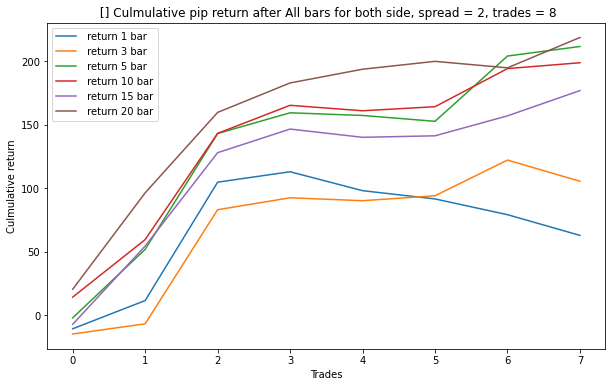

In [298]:
GJ15M_0122_0223_H1_test.plot_PipReturn()

In [273]:
GJ15M_0122_0223_H1_test.result_Sell

index                local time     open     high      low    close  \
0   5166 2022-03-17 18:45:00-07:00 156.5320 156.7020 156.5140 156.6000   
1   5267 2022-03-18 20:00:00-07:00 156.4300 156.5960 156.3750 156.5450   
2   6752 2022-04-11 07:15:00-07:00 162.0180 162.1930 162.0180 162.1220   
3   7160 2022-04-15 13:15:00-07:00 165.1520 165.3710 165.1270 165.2290   
4  10684 2022-06-07 06:15:00-07:00 165.2840 165.5050 165.2830 165.4240   
5  10705 2022-06-07 11:30:00-07:00 165.9800 166.1360 165.9030 165.9600   

           volume  LogReturn_1bar  LogReturn_3bar  LogReturn_10bar  ...  \
0 1932899986.2670         -0.0061         -0.0059          -0.0055  ...   
1 3815330062.8661         -0.0003         -0.0001           0.0023  ...   
2 3132319976.8067          0.0001          0.0008           0.0023  ...   
3 2388100006.1036          0.0008          0.0000           0.0001  ...   
4 2558489990.2345          0.0007          0.0001           0.0025  ...   
5 5724020004.2726          0.0006         -0.0018          -0.0019  ...   

     ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  CurrLow  \
0 0.1414      2          2  156.7021        0.1856          1.0000 155.9710   
1 0.1250      0          0       NaN           NaN          1.0000 156.0250   
2 0.1084      0          0       NaN           NaN          1.0000 161.5240   
3 0.1550      0          0       NaN           NaN          1.0000 164.2820   
4 0.1097      0          0       NaN           NaN          1.0000 163.9030   
5 0.1346      2          0  166.1361           NaN          1.0000 165.1730   

   CurrHigh  maxHi10bar  maxLo10bar  
0  156.6060    156.7020    155.9820  
1  156.5460    156.5960    156.1950  
2  162.1650    162.1930    161.7970  
3  165.2380    165.3710    164.9490  
4  165.4620    165.5050    165.1730  
5  166.0330    166.1360    165.6540  

[6 rows x 34 columns]

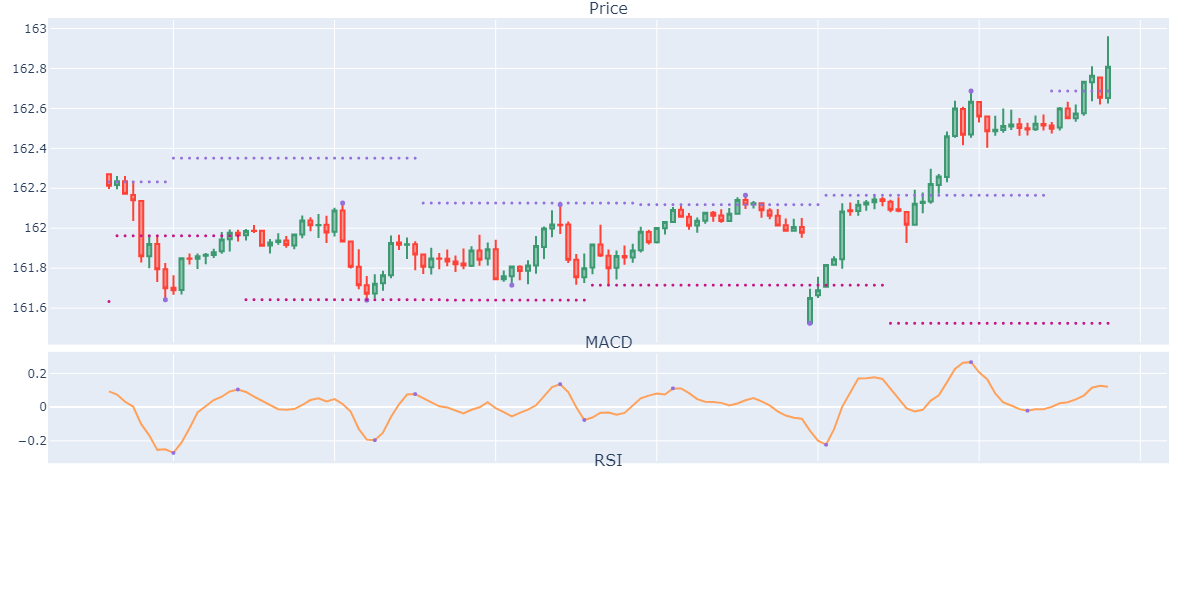

In [275]:
a = 6752
GJ15M_0122_0223_H1_test.graph_Sample(a-100, a+25)

###### 2nd Half

In [285]:
GJ15M_0122_0223_H2 = GJ15M_0122_0223.iloc[-round(len(GJ15M_0122_0223)/2):].reset_index(drop = True)

In [287]:
GJ15M_0122_0223_H2_test = TradingTest(GJ15M_0122_0223_H2,100)

In [289]:
GJ15M_0122_0223_H2_test.gen_pivot(10,10)

pivot point generated with comparative range of( 10, 10 ) candle


In [291]:
GJ15M_0122_0223_H2_test.gen_divSignal2(100,10)

divergence sigal generated with comparative range of( 10, 10 ) candle


C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.4, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_8092\388852347.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.4, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
Sell stats


count     mean     std      min      25%      50%     75%  \
PipReturn_1bar  3.0000  -3.0667 15.5182 -19.0000 -10.6000  -2.2000  4.9000   
PipReturn_3bar  3.0000  -7.6667 16.1159 -25.3000 -14.6500  -4.0000  1.1500   
PipReturn_5bar  3.0000   2.8000 34.3039 -31.2000 -14.5000   2.2000 19.8000   
PipReturn_10bar 3.0000 -22.2000 34.2723 -59.7000 -37.0500 -14.4000 -3.4500   
PipReturn_15bar 3.0000  -7.2667 27.5320 -38.8000 -16.9000   5.0000  8.5000   
PipReturn_20bar 3.0000   9.4667 23.4011 -13.8000  -2.3000   9.2000 21.1000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  12.0000       -0.1976         -0.5929  
PipReturn_3bar   6.3000       -0.4757         -1.4272  
PipReturn_5bar  37.4000        0.0816          0.2449  
PipReturn_10bar  7.5000       -0.6478         -1.9433  
PipReturn_15bar 12.0000       -0.2639         -0.7918  
PipReturn_20bar 33.0000        0.4045          1.2136

Buy Stats


count    mean     std      min     25%     50%     75%  \
PipReturn_1bar  5.0000 10.8400 20.4907  -2.2000  1.6000  2.6000  5.0000   
PipReturn_3bar  5.0000 17.2000 16.8839   0.5000  4.4000 18.2000 19.4000   
PipReturn_5bar  5.0000  9.7200 17.1287 -12.1000  4.9000  8.0000 12.3000   
PipReturn_10bar 5.0000 19.7400 28.8645 -10.2000  0.2000 10.0000 39.2000   
PipReturn_15bar 5.0000 38.5000 60.2998 -23.9000 14.5000 16.5000 49.6000   
PipReturn_20bar 5.0000 20.9200 49.1901 -27.3000 -8.5000  9.4000 31.0000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   47.2000        0.5290          2.6451  
PipReturn_3bar   43.5000        1.0187          5.0936  
PipReturn_5bar   35.5000        0.5675          2.8373  
PipReturn_10bar  59.5000        0.6839          3.4194  
PipReturn_15bar 135.8000        0.6385          3.1924  
PipReturn_20bar 100.0000        0.4253          2.1264

All Stats


count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  8.0000  7.9250 18.0254 -12.0000   0.6500  2.4000  8.5000   
PipReturn_3bar  8.0000 13.6250 16.1693  -6.3000   3.1250 11.3000 20.8750   
PipReturn_5bar  8.0000  5.0250 23.3636 -37.4000  -4.6750  6.4500 17.0250   
PipReturn_10bar 8.0000 20.6625 28.5186 -10.2000  -1.7250 12.2000 44.2750   
PipReturn_15bar 8.0000 26.7875 50.5532 -23.9000  -6.7500 15.5000 41.5000   
PipReturn_20bar 8.0000  9.5250 42.2665 -33.0000 -13.7250  0.4500 18.1000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   47.2000        0.4397          3.5173  
PipReturn_3bar   43.5000        0.8426          6.7412  
PipReturn_5bar   35.5000        0.2151          1.7206  
PipReturn_10bar  59.7000        0.7245          5.7962  
PipReturn_15bar 135.8000        0.5299          4.2391  
PipReturn_20bar 100.0000        0.2254          1.8028

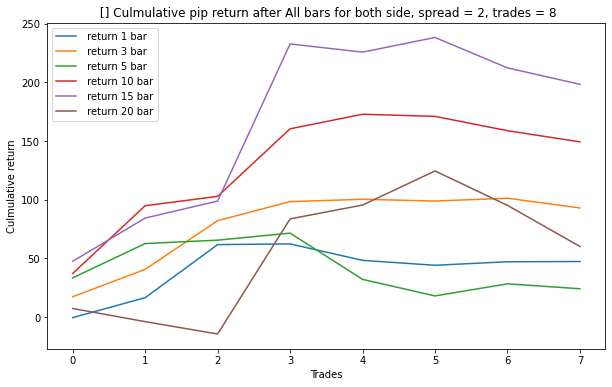

None

In [300]:
GJ15M_0122_0223_H2_test.test_falseBreakSig2MACD(ATR_surpass=0.4)

#### 2020

In [ ]:
GJ15M_2020_test = TradingTest(GJ15M_2020.reset_index().drop(columns = ['index']), pipRetMulti = 100)

In [ ]:
GJ15M_2020_test.gen_pivot(5,5)
GJ15M_2020_test.gen_divSignal2(30)
GJ15M_2020_test.df.divSignal2MACD.value_counts()

In [408]:
GJ15M_2020_resultS, GJ15M_2020_statS = falsebreak_wDiv_test(GJ15M_2020_test.df,side = 'sell', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)
GJ15M_2020_resultB, GJ15M_2020_statB = falsebreak_wDiv_test(GJ15M_2020_test.df,side = 'buy', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)
GJ15M_2020_resultAll = GetResultAll(GJ15M_2020_resultS,GJ15M_2020_resultB)
GJ15M_2020_statAll = Get_statAll(GJ15M_2020_resultAll)

NameError: name 'GJ15M_2020_test' is not defined

In [ ]:
Plot_csPipReturn(GJ15M_2020_resultAll,side = 'All',spread  = 2, return_bar= 'All')

In [ ]:
Plot_csPipReturn(GJ15M_2020_resultS, side = 'sell', spread = 2, return_bar = 'All')
Plot_csPipReturn(GJ15M_2020_resultB, side = 'buy', spread = 2, return_bar = 'All')

#### 2021

In [ ]:
GJ15M_2021_test = TradingTest(GJ15M_2021.reset_index().drop(columns = ['index']), pipRetMulti = 100)

In [ ]:
test = TradingTest(GJ15M_2021, pipRetMulti = 100)

In [ ]:
test.df

In [ ]:
test.df.columns

In [ ]:
GJ15M_2021_test.gen_pivot(5,5)
GJ15M_2021_test.gen_divSignal2(30)
GJ15M_2021_test.df.divSignal2MACD.value_counts()

In [ ]:
GJ15M_2021_resultS, GJ15M_2021_statS = falsebreak_wDiv_test(GJ15M_2021_test.df,side = 'sell', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)
GJ15M_2021_resultB, GJ15M_2021_statB = falsebreak_wDiv_test(GJ15M_2021_test.df,side = 'buy', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)
GJ15M_2021_resultAll = GetResultAll(GJ15M_2021_resultS,GJ15M_2021_resultB)
GJ15M_2021_statAll = Get_statAll(GJ15M_2021_resultAll)

In [ ]:
GJ15M_2021_statAll

In [ ]:
Plot_csPipReturn(GJ15M_2021_resultAll,side = 'All',spread  = 2, return_bar= 'All')

In [ ]:
dfpl = GJ15M_2021_resultAll
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl.index,y=dfpl['PipReturn_20bar_cumsum']), row = 1, col = 1)
# fig.add_scatter(x = GJ1H_18_23_resultAll.iloc[138:]['gmt time'], y= GJ1H_18_23_resultAll.iloc[138:]['PipReturn_20bar_cumsum'],mode="markers",
#                             marker=dict(size=4, color="MediumPurple"),name="pivot", row=2, col=1)
       
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

In [ ]:
GJ15M_2021_resultAll.iloc[313]

In [ ]:
GJ15M_2021[GJ15M_2021['Gmt time'] >= '2021-11-1']

In [ ]:
pd.set_option('display.max_rows', None)


In [ ]:
GJ15M_2021.loc[24170:]

In [ ]:
GJ15M_2021[(GJ15M_2021['Gmt time'] == '2021-11-18 23:30:00')]

In [ ]:
GJ15M_2021.loc[24260]

In [ ]:
GJ15M_2021_test.graph_init_Sample(20820,20920,RSIpp= False, RSI= False, height=2000)

In [ ]:
Plot_csPipReturn(GJ15M_2021_resultS, side = 'sell', spread = 2, return_bar = 'All')
Plot_csPipReturn(GJ15M_2021_resultB, side = 'buy', spread = 2, return_bar = 'All')

### 1 hour

In [ ]:
print(os.listdir("D:/Data/Forex/GBPJPY/"))

In [ ]:
GJ1H_15_23 = pd.read_csv("D:/Data/Forex/GBPJPY/DUKAS_GBPJPY_Candlestick_1_Hour_BID_01.01.2015-14.01.2023.csv")

In [ ]:
GJ1H_15_23['Gmt time'] = pd.to_datetime(GJ1H_15_23['Gmt time'])

In [ ]:
GJ1H_15_18 = GJ1H_15_23[GJ1H_15_23['Gmt time'] < '2019-1-1']
GJ1H_18_23 = GJ1H_15_23[GJ1H_15_23['Gmt time'] >= '2019-1-1']

#### OANDA_TDV 2021-2023

In [395]:
GJ1H_21_23 = pd.read_csv("D:/Data/Forex/GBPJPY/OANDA_GBPJPY, 60, 0121_0223.csv")

In [397]:
GJ1H_21_23_test = TradingTest(GJ1H_21_23.reset_index(drop = True), pipRetMulti = 100)

In [399]:
GJ1H_21_23_test.gen_pivot(10,10)


pivot point generated with comparative range of( 10, 10 ) candle


In [400]:
GJ1H_21_23_test.gen_divSignal2(100,10)


time     open     high      low    close  volume  \
0      2021-01-04T05:00:00+07:00 141.2120 141.2120 140.7680 141.0160     267   
1      2021-01-04T06:00:00+07:00 141.0160 141.3220 141.0000 141.2520    1516   
2      2021-01-04T07:00:00+07:00 141.2520 141.2860 140.7890 140.9180    3131   
3      2021-01-04T08:00:00+07:00 140.9180 141.1080 140.9100 141.0100    2756   
4      2021-01-04T09:00:00+07:00 141.0100 141.0900 140.9640 141.0100    2065   
...                          ...      ...      ...      ...      ...     ...   
13114  2023-02-08T18:00:00+07:00 158.2050 158.2665 158.0435 158.2400    8609   
13115  2023-02-08T19:00:00+07:00 158.2400 158.4740 158.2080 158.4410    8843   
13116  2023-02-08T20:00:00+07:00 158.4410 158.6840 158.4260 158.5980   12633   
13117  2023-02-08T21:00:00+07:00 158.5980 158.6845 158.5080 158.5520   17079   
13118  2023-02-08T22:00:00+07:00 158.5520 158.5865 158.4210 158.4905    8142   

       volume ma    upper    basis    lower  ...  UpperWick  LowerWick   MACD  \
0            NaN      NaN      NaN      NaN  ...     0.1960     0.2480    NaN   
1            NaN      NaN      NaN      NaN  ...     0.0700     0.2520    NaN   
2            NaN      NaN      NaN      NaN  ...     0.3680     0.1290    NaN   
3            NaN      NaN      NaN      NaN  ...     0.0980     0.1000    NaN   
4            NaN      NaN      NaN      NaN  ...     0.0800     0.0460    NaN   
...          ...      ...      ...      ...  ...        ...        ...    ...   
13114 11550.5000 158.7727 158.1614 157.5501  ...     0.0265     0.1965 0.0610   
13115 11170.5000 158.7987 158.1881 157.5774  ...     0.0330     0.2330 0.1147   
13116 10731.1500 158.8363 158.2271 157.6180  ...     0.0860     0.1720 0.1935   
13117 10034.7000 158.8566 158.2581 157.6595  ...     0.1325     0.0440 0.2529   
13118  9573.2500 158.8674 158.2802 157.6930  ...     0.0960     0.0695 0.2224   

          RSI    ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  
0         NaN    NaN      0          0       NaN           NaN             NaN  
1         NaN    NaN      0          0       NaN           NaN             NaN  
2         NaN    NaN      0          0       NaN           NaN             NaN  
3         NaN    NaN      0          0       NaN           NaN             NaN  
4         NaN    NaN      0          0       NaN           NaN             NaN  
...       ...    ...    ...        ...       ...           ...             ...  
13114 47.6978 0.2717      0          0       NaN           NaN          1.0000  
13115 50.3113 0.2714      0          0       NaN           NaN          1.0000  
13116 52.2397 0.2707      0          0       NaN           NaN          1.0000  
13117 51.6323 0.2660      0          0       NaN           NaN          1.0000  
13118 50.8152 0.2610      0          0       NaN           NaN          1.0000  

[13119 rows x 40 columns]

In [437]:
GJ1H_21_23_test.df.divSignal2MACD.value_counts()

1.0000    2330
2.0000    1862
0.0000     389
Name: divSignal2MACD, dtype: int64

In [510]:
GJ1H_21_23_test_resultS, GJ1H_21_23_test_statS = falsebreak_wDiv_test(GJ1H_21_23_test.df,side = 'sell', fwdCandle=10,
                                                             elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass= 0.3,
                                                             ATR_commpare_range = 0)
GJ1H_21_23_test_resultB, GJ1H_21_23_test_statB = falsebreak_wDiv_test(GJ1H_21_23_test.df,side = 'buy', fwdCandle=10,
                                                             elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass= 0.3,
                                                             ATR_commpare_range = 0)

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\4075352777.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\4075352777.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.3, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_21408\4075352777.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\4075352777.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.3, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


In [511]:
GJ1H_21_23_test_statS

count     mean     std      min      25%      50%     75%  \
PipReturn_1bar  4.0000  -6.8500  9.1366 -12.4000 -11.6500 -10.9000 -6.1000   
PipReturn_3bar  4.0000  -5.3250  8.3536 -13.8000  -8.7000  -6.8500 -3.4750   
PipReturn_5bar  4.0000  -4.0500 29.1128 -38.2000 -18.2500  -4.9000  9.3000   
PipReturn_10bar 4.0000 -14.3250 41.1207 -45.1000 -44.4250 -27.3000  2.8000   
PipReturn_15bar 4.0000 -16.3250 32.7906 -48.4000 -39.8500 -20.3500  3.1750   
PipReturn_20bar 4.0000 -13.1500 25.8638 -38.4000 -29.7000 -17.5500 -1.0000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   6.8000       -0.7497         -2.9989  
PipReturn_3bar   6.2000       -0.6375         -2.5498  
PipReturn_5bar  31.8000       -0.1391         -0.5565  
PipReturn_10bar 42.4000       -0.3484         -1.3935  
PipReturn_15bar 23.8000       -0.4979         -1.9914  
PipReturn_20bar 20.9000       -0.5084         -2.0337

In [512]:
GJ1H_21_23_test_statB

count     mean      std       min      25%      50%     75%  \
PipReturn_1bar  5.0000 -51.7000 110.5174 -238.7000 -48.2000 -16.4000 -6.3000   
PipReturn_3bar  5.0000   6.3600  50.8137  -53.5000 -29.8000   6.2000 34.3000   
PipReturn_5bar  5.0000   7.0400  61.7138  -70.8000 -33.0000   7.0000 48.4000   
PipReturn_10bar 5.0000  26.0200  52.4263  -56.5000  24.6000  30.6000 43.2000   
PipReturn_15bar 5.0000  31.9400  82.2643  -73.2000  -0.6000  23.3000 59.4000   
PipReturn_20bar 5.0000  19.1000  73.6119  -79.7000   4.0000  13.2000 31.7000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   51.1000       -0.4678         -2.3390  
PipReturn_3bar   74.6000        0.1252          0.6258  
PipReturn_5bar   83.6000        0.1141          0.5704  
PipReturn_10bar  88.2000        0.4963          2.4816  
PipReturn_15bar 150.8000        0.3883          1.9413  
PipReturn_20bar 126.3000        0.2595          1.2973

In [500]:
GJ1H_21_23_resultAll = GetResultAll(GJ1H_21_23_test_resultS,GJ1H_21_23_test_resultB)
GJ1H_21_23_statAll = GetStatAll(GJ1H_21_23_resultAll)

In [501]:
GJ1H_21_23_statAll

count     mean     std       min      25%     50%     75%  \
PipReturn_1bar  12.0000 -14.6333 74.8662 -238.7000  -9.2000  6.4000 13.7750   
PipReturn_3bar  12.0000   4.8917 31.7248  -53.5000  -6.9000  6.4500 15.3250   
PipReturn_5bar  12.0000   3.8833 45.7541  -70.8000 -32.1000  4.0000 40.5500   
PipReturn_10bar 12.0000  16.5917 41.0293  -56.5000   0.9000 23.4500 43.4500   
PipReturn_15bar 12.0000  17.3167 57.2611  -73.2000 -10.4500 13.5000 39.8500   
PipReturn_20bar 12.0000   8.7000 55.7274  -79.7000 -28.1250 10.7500 33.3750   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   51.1000       -0.1955         -2.3455  
PipReturn_3bar   74.6000        0.1542          1.8503  
PipReturn_5bar   83.6000        0.0849          1.0185  
PipReturn_10bar  88.2000        0.4044          4.8526  
PipReturn_15bar 150.8000        0.3024          3.6290  
PipReturn_20bar 126.3000        0.1561          1.8734

In [503]:
GJ1H_21_23_test_resultS

index                       time     open     high      low    close  \
0    490  2021-02-01T15:00:00+07:00 143.8860 144.0230 143.7790 143.9220   
1   1042  2021-03-04T15:00:00+07:00 149.5450 149.7580 149.4540 149.5360   
2   3492  2021-07-26T16:00:00+07:00 151.7590 152.2380 151.7260 152.1440   
3   3761  2021-08-10T21:00:00+07:00 153.0660 153.3180 152.9720 153.0960   
4   9649  2022-07-20T07:00:00+07:00 165.8630 166.2520 165.8300 166.0080   
5  11318  2022-10-25T20:00:00+07:00 169.0680 169.9360 169.0570 169.7420   

   volume  volume ma    upper    basis  ...    ATR  pivot  MACDpivot  \
0    4856  2945.5000 144.1008 143.6688  ... 0.1920      0          0   
1    4268  2788.6000 149.8135 149.3383  ... 0.2112      0          0   
2    3641  1992.1500 152.3155 151.8381  ... 0.2122      0          0   
3    4413  1639.5000 153.3321 152.9618  ... 0.1646      2          0   
4   10123 10886.2500 166.2850 165.6421  ... 0.2857      2          0   
5   25029 10331.4500 169.7998 168.5671  ... 0.5479      0          0   

   pointpos  MACDpointpos  divSignal2MACD  CurrLow  CurrHigh  maxHi10bar  \
0       NaN           NaN          1.0000 142.1920  143.9580    144.0230   
1       NaN           NaN          1.0000 148.1180  149.6990    149.7580   
2       NaN           NaN          1.0000 150.7430  152.1700    152.2380   
3  153.3181           NaN          1.0000 152.6240  153.2500    153.3180   
4  166.2521           NaN          1.0000 164.7240  166.0970    166.2520   
5       NaN           NaN          1.0000 167.5920  169.8100    169.9360   

   maxLo10bar  
0    143.3810  
1    149.0510  
2    151.4040  
3    152.7320  
4    165.6590  
5    167.8410  

[6 rows x 45 columns]

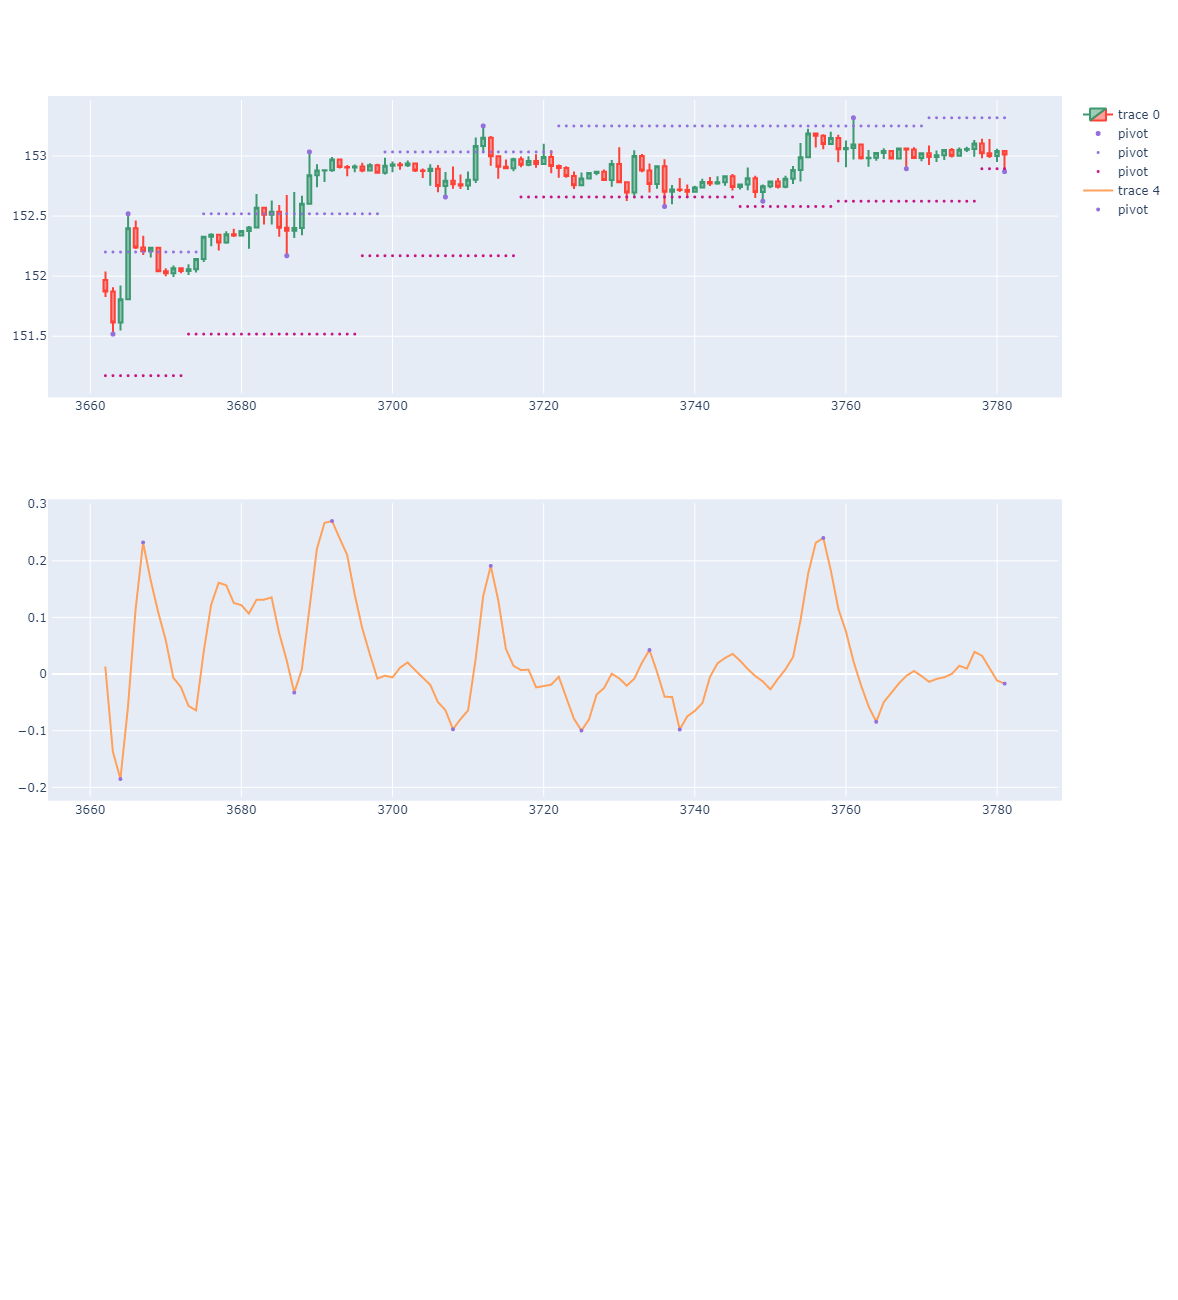

In [505]:
GJ1H_21_23_test.graph_init_Sample(3662,3782, height = 1300)

#### 2015-2018

In [498]:
GJ1H_15_18_test = TradingTest(GJ1H_15_18.reset_index().drop(columns = ['index']), pipRetMulti = 100)

NameError: name 'GJ1H_15_18' is not defined

In [499]:
GJ1H_15_18_test.df

NameError: name 'GJ1H_15_18_test' is not defined

In [ ]:
GJ1H_15_18_test.gen_pivot(5,5)
GJ1H_15_18_test.gen_divSignal2(30)
GJ1H_15_18_test.df.divSignal2MACD.value_counts()

In [ ]:
GJ1H_15_18_resultS, GJ1H_15_18_statS = falsebreak_wDiv_test(GJ1H_15_18_test.df,side = 'sell', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)
GJ1H_15_18_resultB, GJ1H_15_18_statB = falsebreak_wDiv_test(GJ1H_15_18_test.df,side = 'buy', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)

In [ ]:
GJ1H_15_18_resultAll = GetResultAll(GJ1H_15_18_resultS,GJ1H_15_18_resultB)
GJ1H_15_18_statAll = Get_statAll(GJ1H_15_18_resultAll)

In [ ]:
Plot_csPipReturn(GJ1H_15_18_resultAll, side = 'All', spread = 2, return_bar = "All",figsize = (15,6))

In [ ]:
GJ1H_15_18_statAll

In [ ]:
GJ1H_15_18_resultAll.columns

In [ ]:
dfpl = GJ1H_15_18_resultAll.iloc[138:]
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl['gmt time'],y=dfpl['PipReturn_3bar_cumsum']), row = 1, col = 1)
# fig.add_scatter(x = GJ1H_15_18_resultAll.iloc[138:]['gmt time'], y= GJ1H_15_18_resultAll.iloc[138:]['PipReturn_20bar_cumsum'],mode="markers",
#                             marker=dict(size=4, color="MediumPurple"),name="pivot", row=2, col=1)
       
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

In [ ]:
datetime.date(2016,7,7) - datetime.date(2018,12,28)

In [ ]:
Plot_csPipReturn(GJ1H_15_18_resultS, side = 'sell', spread = 2, return_bar='All')
Plot_csPipReturn(GJ1H_15_18_resultB, side = 'buy', spread = 2, return_bar='All')


#### 2018-2023

In [ ]:
GJ1H_18_23_test = TradingTest(GJ1H_18_23.reset_index().drop(columns = ['index']), pipRetMulti = 100)

In [ ]:
GJ1H_18_23_test.df

In [ ]:
GJ1H_18_23_test.gen_pivot(5,5)
GJ1H_18_23_test.gen_divSignal2(30)
GJ1H_18_23_test.df.divSignal2MACD.value_counts()

In [ ]:
GJ1H_18_23_resultS, GJ1H_18_23_statS = falsebreak_wDiv_test(GJ1H_18_23_test.df,side = 'sell', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)
GJ1H_18_23_resultB, GJ1H_18_23_statB = falsebreak_wDiv_test(GJ1H_18_23_test.df,side = 'buy', 
                                                             elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass= 0.0)

In [ ]:
GJ1H_18_23_resultAll = GetResultAll(GJ1H_18_23_resultS,GJ1H_18_23_resultB)
GJ1H_18_23_statAll = Get_statAll(GJ1H_18_23_resultAll)

In [ ]:
Plot_csPipReturn(GJ1H_18_23_resultAll, side = 'All', spread = 2, return_bar = "All",figsize = (15,6))

In [ ]:
GJ1H_18_23_statAll

In [ ]:
dfpl = GJ1H_18_23_resultAll
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl['gmt time'],y=dfpl['PipReturn_20bar_cumsum']), row = 1, col = 1)
# fig.add_scatter(x = GJ1H_18_23_resultAll.iloc[138:]['gmt time'], y= GJ1H_18_23_resultAll.iloc[138:]['PipReturn_20bar_cumsum'],mode="markers",
#                             marker=dict(size=4, color="MediumPurple"),name="pivot", row=2, col=1)
       
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

In [ ]:
datetime.date(2016,7,7) - datetime.date(2018,12,28)

In [ ]:
Plot_csPipReturn(GJ1H_18_23_resultS, side = 'sell', spread = 2, return_bar='All')
Plot_csPipReturn(GJ1H_18_23_resultB, side = 'buy', spread = 2, return_bar='All')

#### --------------

In [344]:
print(os.listdir("D:Data/Forex/GBPJPY/OANDA_GBPJPY, 15, 0922_0223.csv"))

['DUKAS_GBPJPY_Candlestick_15_M_BID_01.10.2020-01.01.2023.csv', 'DUKAS_GBPJPY_Candlestick_1_Hour_BID_01.01.2015-14.01.2023.csv', 'OANDA_GBPJPY, 15, 0922_0223.csv']


In [ ]:
gbpjpy_df = pd.read_csv("D:Data/Forex/GBPJPY/OANDA_GBPJPY, 15, 0922_0223.csv")
gbpjpy_df.columns = ['Gmt time', 'open', 'high', 'low', 'close', 'Volume']
gbpjpy_test = TradingTest(gbpjpy_df)
gbpjpy_test.gen_pivot(5,5)

In [ ]:
gbpjpy_test.gen_divSignal2(30)

In [ ]:
gj_sell_result_dfpl, gj_sell_stat_df = falsebreak_wDiv_test(gbpjpy_test.df, side = 'sell', elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass=0.5)
gj_sell_stat_df

In [ ]:
gj_sell_result_dfpl['PipReturn_10bar_cumsum'] = (gj_sell_result_dfpl['PipReturn_10bar']+0.2).cumsum()
plt.plot(gj_sell_result_dfpl.index, -gj_sell_result_dfpl['PipReturn_10bar_cumsum'])

In [ ]:
gj_buy_result_dfpl, gj_buy_stat_df = falsebreak_wDiv_test(gbpjpy_test.df, side = 'buy', elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass=0)
gj_buy_stat_df

In [ ]:
gj_buy_result_dfpl['PipReturn_10bar_cumsum'] = (gj_buy_result_dfpl['PipReturn_10bar']-0.2).cumsum()
plt.plot(gj_buy_result_dfpl.index, gj_buy_result_dfpl['PipReturn_10bar_cumsum'])

## GBPUSD

In [358]:
GU15M_0922_0223 = pd.read_csv("D:/Data/Forex/GBPUSD/OANDA_GBPUSD, 15, 0922_0223.csv")
GU15M_0922_0223_test = TradingTest(GU15M_0922_0223,10000)

In [359]:
GU15M_0922_0223_test.gen_pivot(10,10)
GU15M_0922_0223_test.gen_divSignal2(100,10)

pivot point generated with comparative range of( 10, 10 ) candle
divergence sigal generated with comparative range of( 10, 10 ) candle


In [370]:
GU15M_0922_0223_test.test_falseBreakSig2MACD(ATR_surpass=0.1)

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.1, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.1, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
Sell stats


count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  6.0000  1.8167  7.3893  -6.4000  -3.9500  0.6000  7.7750   
PipReturn_3bar  6.0000 -6.7333 11.3908 -27.8000  -6.8750 -5.2500 -1.9750   
PipReturn_5bar  6.0000 -6.0333 22.7951 -35.8000 -24.0000 -3.0500 13.0250   
PipReturn_10bar 6.0000 -2.0000 21.3469 -22.1000 -19.4000 -7.7000 12.5500   
PipReturn_15bar 6.0000  5.4000 30.0712 -31.2000 -20.4000 10.2500 27.0250   
PipReturn_20bar 6.0000 22.3167 35.5770 -23.4000  -8.3250 37.4500 46.4000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  11.4000        0.2459          1.4751  
PipReturn_3bar   6.2000       -0.5911         -3.5467  
PipReturn_5bar  18.3000       -0.2647         -1.5881  
PipReturn_10bar 29.5000       -0.0937         -0.5621  
PipReturn_15bar 41.1000        0.1796          1.0774  
PipReturn_20bar 56.6000        0.6273          3.7637

Buy Stats


count    mean     std     min     25%     50%     75%  \
PipReturn_1bar  2.0000  2.1000  1.1314  1.3000  1.7000  2.1000  2.5000   
PipReturn_3bar  2.0000  1.8000  1.6971  0.6000  1.2000  1.8000  2.4000   
PipReturn_5bar  2.0000  2.4500  0.7778  1.9000  2.1750  2.4500  2.7250   
PipReturn_10bar 2.0000  1.5000  9.8995 -5.5000 -2.0000  1.5000  5.0000   
PipReturn_15bar 2.0000  3.4000 14.0007 -6.5000 -1.5500  3.4000  8.3500   
PipReturn_20bar 2.0000 16.3000 16.4049  4.7000 10.5000 16.3000 22.1000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   2.9000        1.8562          3.7123  
PipReturn_3bar   3.0000        1.0607          2.1213  
PipReturn_5bar   3.0000        3.1498          6.2997  
PipReturn_10bar  8.5000        0.1515          0.3030  
PipReturn_15bar 13.3000        0.2428          0.4857  
PipReturn_20bar 27.9000        0.9936          1.9872

All Stats


count     mean     std      min      25%      50%     75%  \
PipReturn_1bar  8.0000  -0.8375  6.5170 -11.4000  -4.7250   1.6500  3.3250   
PipReturn_3bar  8.0000   5.5000  9.9149  -6.2000   1.2000   3.3500  6.8250   
PipReturn_5bar  8.0000   5.1375 19.3389 -18.3000  -8.2750   2.4500 16.0000   
PipReturn_10bar 8.0000   1.8750 18.4268 -29.5000  -8.3750   4.6500 16.2000   
PipReturn_15bar 8.0000  -3.2000 26.2775 -41.1000 -24.2750  -2.0500 16.5750   
PipReturn_20bar 8.0000 -12.6625 35.5258 -56.6000 -45.2000 -12.8000 21.7500   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   6.4000       -0.1285         -1.0281  
PipReturn_3bar  27.8000        0.5547          4.4378  
PipReturn_5bar  35.8000        0.2657          2.1252  
PipReturn_10bar 22.1000        0.1018          0.8140  
PipReturn_15bar 31.2000       -0.1218         -0.9742  
PipReturn_20bar 27.9000       -0.3564         -2.8514

In [362]:
GU15M_0922_0223_test.result_Buy

index                       time   open   high    low  close  basis  upper  \
0   1876  2022-09-28T17:00:00+07:00 1.0679 1.0840 1.0622 1.0721    NaN    NaN   

   lower  upper 2nd  ...    ATR  pivot  MACDpivot  pointpos  MACDpointpos  \
0    NaN        NaN  ... 0.0031      2          0    1.0841           NaN   

   divSignal2MACD  CurrLow  CurrHigh  maxHi10bar  maxLo10bar  
0          2.0000   1.0631    1.0740      1.0840      1.0622  

[1 rows x 55 columns]

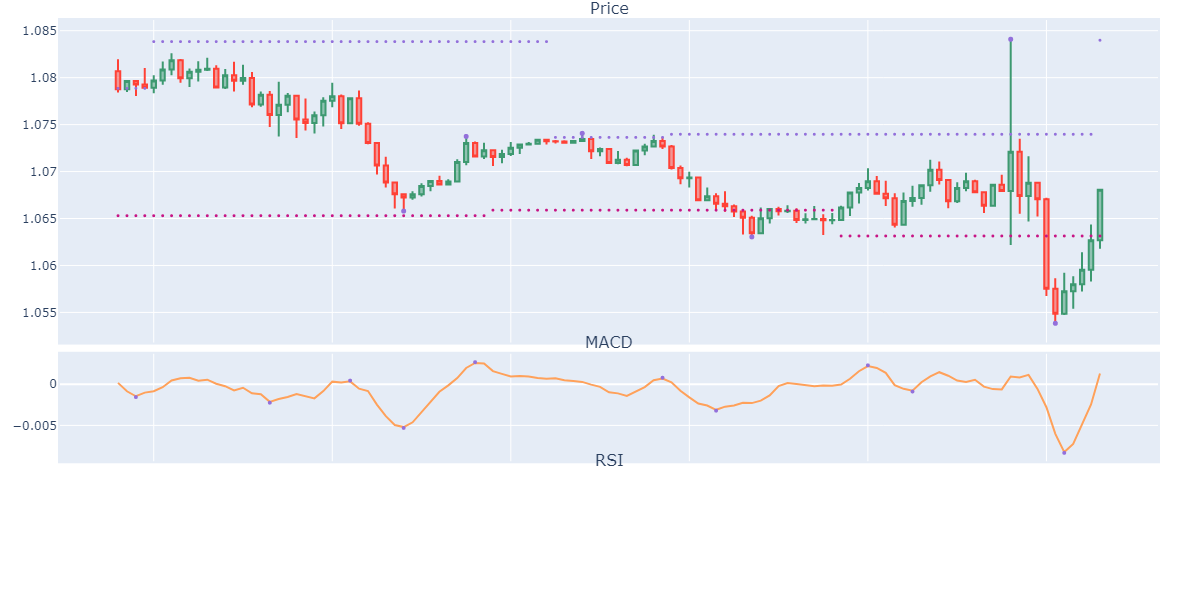

In [364]:
GU15M_0922_0223_test.graph_Sample(1776,1887)

## NZDJPY


### 15M

#### TradingView data

In [305]:
NJ15M_0922_0223 = pd.read_csv("D:/Data/Forex/NZDJPY/OANDA_NZDJPY, 15, 0922_0223.csv")

In [306]:
NJ15M_0922_0223_test = TradingTest(NJ15M_0922_0223,100)

In [307]:
NJ15M_0922_0223_test.gen_pivot(10,10)

pivot point generated with comparative range of( 10, 10 ) candle


In [308]:
NJ15M_0922_0223_test.gen_divSignal2(100,10)

divergence sigal generated with comparative range of( 10, 10 ) candle


In [368]:
NJ15M_0922_0223_test.test_falseBreakSig2MACD(ATR_surpass = 0.2)

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.2, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\2617062246.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.2, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
Sell stats


count     mean     std      min      25%      50%     75%  \
PipReturn_1bar  5.0000  -3.1600  4.0698  -9.1000  -5.2000  -2.0000 -0.8000   
PipReturn_3bar  5.0000  -1.0400 13.1274 -15.0000  -9.8000  -2.2000  2.8000   
PipReturn_5bar  5.0000  -4.4200 11.9663 -17.0000 -13.5000  -3.2000 -2.0000   
PipReturn_10bar 5.0000  -1.2200 23.3968 -36.8000  -5.0000   2.4000  5.3000   
PipReturn_15bar 5.0000  -3.8000 19.6682 -28.8000 -18.0000   2.4000  4.4000   
PipReturn_20bar 5.0000 -13.1800 21.2493 -34.8000 -22.6000 -21.8000 -7.3000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   1.3000       -0.7765         -3.8823  
PipReturn_3bar  19.0000       -0.0792         -0.3961  
PipReturn_5bar  13.6000       -0.3694         -1.8469  
PipReturn_10bar 28.0000       -0.0521         -0.2607  
PipReturn_15bar 21.0000       -0.1932         -0.9660  
PipReturn_20bar 20.6000       -0.6203         -3.1013

Buy Stats


count     mean     std       min      25%      50%      75%  \
PipReturn_1bar  6.0000  -3.5667 30.6236  -64.7000   1.1000   6.3500  11.2250   
PipReturn_3bar  6.0000 -17.4000 47.0968 -100.7000 -31.6500  -3.8500   8.5750   
PipReturn_5bar  6.0000 -16.6500 50.2737  -99.9000 -36.0000  -9.1000  11.6500   
PipReturn_10bar 6.0000 -25.9500 41.8828  -83.1000 -42.4250 -31.8500 -12.1250   
PipReturn_15bar 6.0000 -36.9333 67.8524 -163.0000 -39.0500 -27.0000  -6.1000   
PipReturn_20bar 6.0000 -31.1167 72.8585 -161.1000 -42.8000 -11.8000  -7.5000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  18.4000       -0.1165         -0.6988  
PipReturn_3bar  32.2000       -0.3695         -2.2167  
PipReturn_5bar  44.6000       -0.3312         -1.9871  
PipReturn_10bar 42.6000       -0.6196         -3.7175  
PipReturn_15bar 37.6000       -0.5443         -3.2659  
PipReturn_20bar 57.2000       -0.4271         -2.5625

All Stats


count     mean     std       min      25%     50%     75%  \
PipReturn_1bar  11.0000  -0.5091 22.0877  -64.7000   0.2000  5.2000  8.1000   
PipReturn_3bar  11.0000  -9.0182 35.6472 -100.7000 -16.4000  2.2000  9.6000   
PipReturn_5bar  11.0000  -7.0727 37.9747  -99.9000 -15.8000  2.0000 14.5500   
PipReturn_10bar 11.0000 -13.6000 36.0192  -83.1000 -32.5500 -7.3000  1.3000   
PipReturn_15bar 11.0000 -18.4182 53.9372 -163.0000 -28.0000 -4.4000  8.1000   
PipReturn_20bar 11.0000 -10.9818 58.0512 -161.1000 -16.4000 -6.2000 22.2000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  18.4000       -0.0230         -0.2535  
PipReturn_3bar  32.2000       -0.2530         -2.7828  
PipReturn_5bar  44.6000       -0.1862         -2.0487  
PipReturn_10bar 42.6000       -0.3776         -4.1533  
PipReturn_15bar 37.6000       -0.3415         -3.7562  
PipReturn_20bar 57.2000       -0.1892         -2.0809

In [313]:
NJ15M_0922_0223_test.result_Buy

index                       time    open    high     low   close   basis  \
0    829  2022-09-13T19:15:00+07:00 87.2840 87.2920 87.0630 87.2640 87.3836   
1   1484  2022-09-22T15:00:00+07:00 85.0140 85.0640 84.1260 84.4470 84.7051   
2   3087  2022-10-17T07:45:00+07:00 82.8150 82.8320 82.4780 82.5780 82.7693   
3   5290  2022-11-17T07:30:00+07:00 85.6580 85.6870 85.5620 85.6100 85.6897   
4   6376  2022-12-02T15:00:00+07:00 86.0980 86.1060 85.9680 86.0120 86.1769   
5   8231  2022-12-30T22:45:00+07:00 83.5300 83.6030 83.3840 83.4460 83.6280   

    upper   lower  upper 2nd  ...    ATR  pivot  MACDpivot  pointpos  \
0 87.5527 87.2144        NaN  ... 0.0864      0          0       NaN   
1 85.1010 84.3093        NaN  ... 0.1874      2          0   85.0641   
2 82.9520 82.5866        NaN  ... 0.1229      1          1   82.4779   
3 85.7724 85.6070        NaN  ... 0.0895      0          0       NaN   
4 86.4407 85.9130        NaN  ... 0.1001      0          0       NaN   
5 83.8890 83.3670        NaN  ... 0.1243      0          0       NaN   

   MACDpointpos  divSignal2MACD  CurrLow  CurrHigh  maxHi10bar  maxLo10bar  
0           NaN          2.0000  87.1540   87.7370     87.5460     87.0630  
1           NaN          2.0000  84.2390   84.9420     85.0640     84.1260  
2       -0.0516          2.0000  82.5640   82.9520     82.9240     82.4780  
3           NaN          2.0000  85.6040   85.8180     85.8040     85.5620  
4           NaN          2.0000  85.9900   87.0920     86.4260     85.9680  
5           NaN          2.0000  83.4120   84.6010     83.8860     83.3840  

[6 rows x 55 columns]

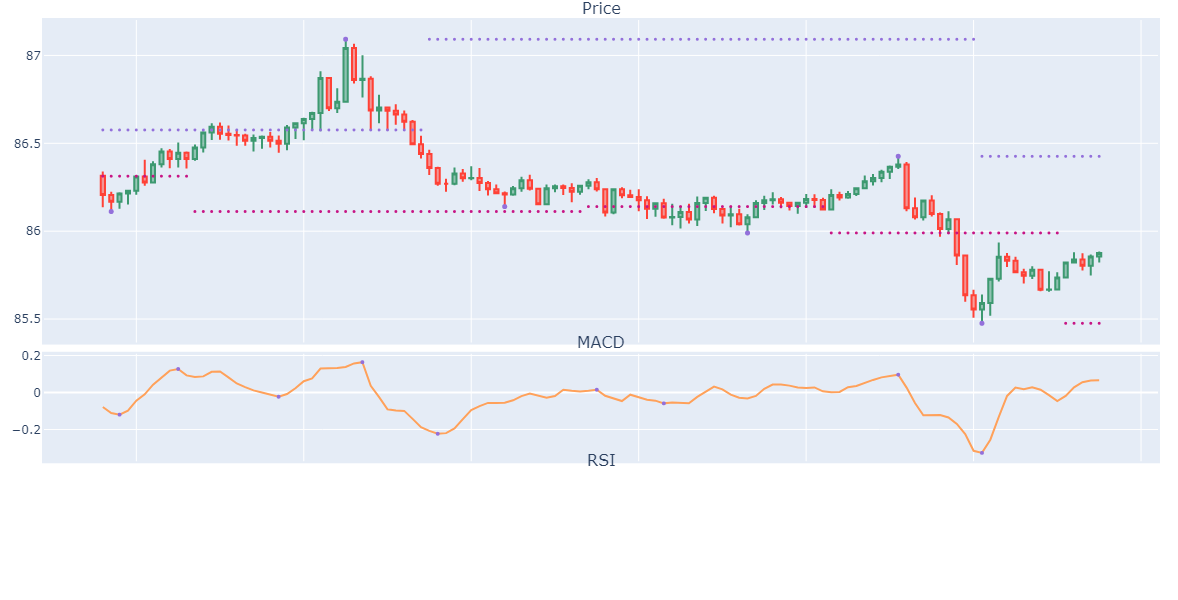

In [376]:
observed_candleID = 6376
NJ15M_0922_0223_test.graph_Sample(observed_candleID -100,observed_candleID+20)

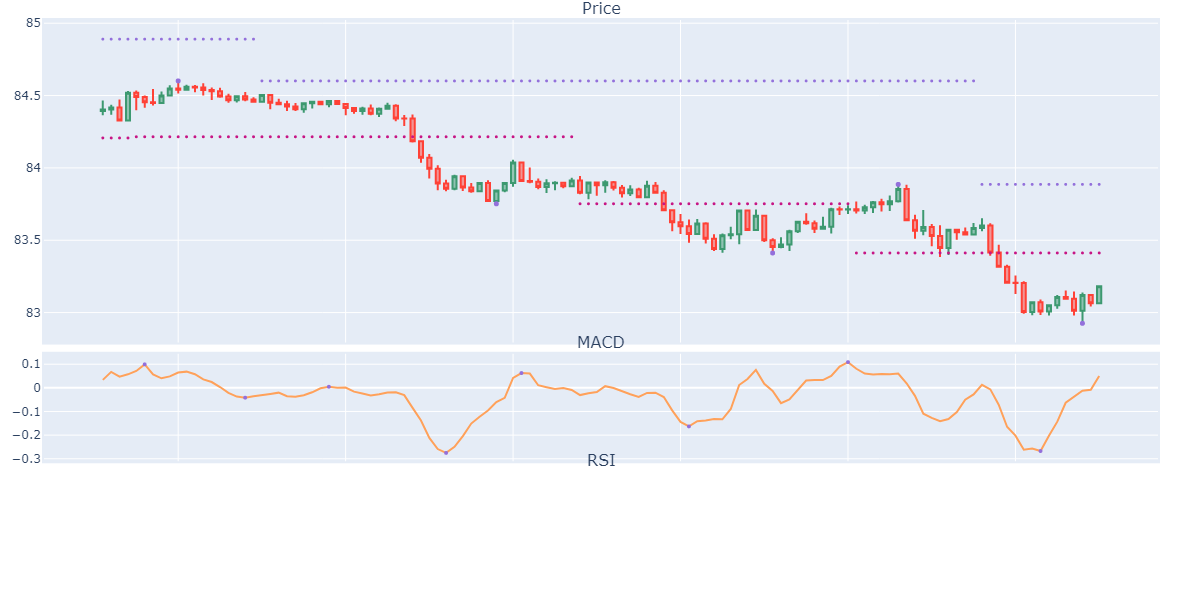

## BTC-USD

### 15 Min

#### Trading View data

In [332]:
BTCUSD_1122_0123 = pd.read_csv("D:/Data/Crypto/BTCUSD/COINBASE_BTCUSD, 15, 0822_0223.csv")
BTCUSD_1122_0123_test = TradingTest(BTCUSD_1122_0123,pipRetMulti=1)

In [333]:
BTCUSD_1122_0123_test.gen_pivot(10,10)
BTCUSD_1122_0123_test.gen_divSignal2(100,10)

pivot point generated with comparative range of( 10, 10 ) candle
divergence sigal generated with comparative range of( 10, 10 ) candle


In [334]:
BTCUSD_1122_0123_test.df.divSignal2MACD.value_counts()

1.0000    1668
2.0000    1468
0.0000      78
Name: divSignal2MACD, dtype: int64

In [375]:
BTCUSD_1122_0123_test.test_falseBreakSig2MACD(ATR_surpass=0.2)

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3886313343.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3886313343.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3886313343.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3886313343.py:30: SettingWithCopyWarning:


A v

result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.2, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.2, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
Sell stats


count     mean      std       min      25%      50%  \
PipReturn_1bar  11.0000 -33.2736  51.3182 -172.9900 -42.7400 -21.0000   
PipReturn_3bar  11.0000 -15.5836  59.6287 -127.3200 -15.1000  -6.5200   
PipReturn_5bar  11.0000  12.2600  73.3553 -103.0100 -25.1300  -9.0800   
PipReturn_10bar 11.0000   7.7536 104.9212 -133.0000 -86.4650 -12.0000   
PipReturn_15bar 11.0000  26.2027 133.6708 -171.7800 -82.0950  46.2100   
PipReturn_20bar 11.0000  91.2964 250.5075 -182.8700 -42.7450  17.6100   

                     75%      max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  -10.7200  21.4200       -0.6484         -7.1322  
PipReturn_3bar   12.2050  53.3000       -0.2613         -2.8748  
PipReturn_5bar   50.6750 151.9000        0.1671          1.8384  
PipReturn_10bar  66.2200 188.8200        0.0739          0.8129  
PipReturn_15bar 104.4900 221.2000        0.1960          2.1563  
PipReturn_20bar 173.9800 705.5300        0.3644          4.0089

Buy Stats


count     mean      std       min      25%     50%      75%  \
PipReturn_1bar  8.0000  15.2487  47.5568  -24.0100 -15.4900 -2.3750  30.4725   
PipReturn_3bar  8.0000  40.6188 121.2233 -138.9000  -4.2600 12.1450  78.7250   
PipReturn_5bar  8.0000  37.0587 131.0440 -103.8800 -39.2125 11.1650  69.9675   
PipReturn_10bar 8.0000  77.3025 183.9556  -95.1500 -28.5875 26.8300 105.3175   
PipReturn_15bar 8.0000  70.8725 197.9199 -134.0100 -51.8450 29.8000 103.5075   
PipReturn_20bar 8.0000 140.0462 317.8895  -67.4700   2.8800 24.2850 113.3675   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  120.4200        0.3206          2.5651  
PipReturn_3bar  288.7400        0.3351          2.6806  
PipReturn_5bar  308.9800        0.2828          2.2624  
PipReturn_10bar 493.4900        0.4202          3.3618  
PipReturn_15bar 498.5600        0.3581          2.8647  
PipReturn_20bar 912.0800        0.4406          3.5244

All Stats


count    mean      std       min      25%     50%     75%  \
PipReturn_1bar  19.0000 25.6842  49.2566  -24.0100  -6.9450 13.8200 36.4250   
PipReturn_3bar  19.0000 26.1247  88.6078 -138.9000  -6.0650  6.5200 51.5900   
PipReturn_5bar  19.0000  8.5058 101.4570 -151.9000 -50.6750  9.0800 42.7900   
PipReturn_10bar 19.0000 28.0595 145.3864 -188.8200 -44.9750 12.0000 88.8700   
PipReturn_15bar 19.0000 14.6711 166.0875 -221.2000 -95.0600 22.4900 84.5100   
PipReturn_20bar 19.0000  6.1111 296.5351 -705.5300 -53.1500 12.7700 89.9850   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  172.9900        0.5214          9.9073  
PipReturn_3bar  288.7400        0.2948          5.6019  
PipReturn_5bar  308.9800        0.0838          1.5929  
PipReturn_10bar 493.4900        0.1930          3.6670  
PipReturn_15bar 498.5600        0.0883          1.6783  
PipReturn_20bar 912.0800        0.0206          0.3916

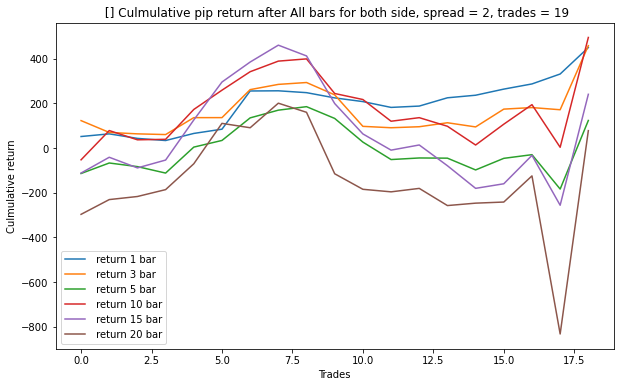

In [342]:
BTCUSD_1122_0123_test.plot_PipReturn()

In [339]:
BTCUSD_1122_0123_test.result_Sell

index                       time       open       high        low  \
0     244  2022-10-03T20:00:00+07:00 19252.4000 19339.5300 19251.5000   
1     285  2022-10-04T06:15:00+07:00 19622.4300 19717.6700 19596.2000   
2    5131  2022-11-23T17:45:00+07:00 16558.1300 16650.0000 16549.3400   
3    5164  2022-11-24T02:00:00+07:00 16508.0800 16700.0000 16451.9500   
4    7138  2022-12-14T15:30:00+07:00 17800.1400 17866.1300 17799.7700   
5    7152  2022-12-14T19:00:00+07:00 17823.5100 17876.3400 17813.3900   
6    8140  2022-12-25T02:00:00+07:00 16841.5600 16863.6200 16832.7700   
7    9654  2023-01-09T20:30:00+07:00 17267.4400 17292.9400 17263.2600   
8    9660  2023-01-09T22:00:00+07:00 17263.7800 17313.8900 17246.4500   
9   10666  2023-01-20T09:30:00+07:00 21174.8700 21222.0000 21106.6500   
10  10717  2023-01-20T22:15:00+07:00 21171.4700 21249.4100 21132.4700   

        close  basis  upper  lower  upper 2nd  ...     ATR  pivot  MACDpivot  \
0  19303.0700    NaN    NaN    NaN        NaN  ... 56.7740      0          0   
1  19642.5100    NaN    NaN    NaN        NaN  ... 73.5164      0          0   
2  16591.2100    NaN    NaN    NaN        NaN  ... 58.2906      2          0   
3  16583.3900    NaN    NaN    NaN        NaN  ... 69.1658      2          2   
4  17831.2500    NaN    NaN    NaN        NaN  ... 32.0586      2          0   
5  17856.0400    NaN    NaN    NaN        NaN  ... 31.0010      0          0   
6  16850.4000    NaN    NaN    NaN        NaN  ... 11.8102      2          0   
7  17263.4000    NaN    NaN    NaN        NaN  ... 23.7761      0          0   
8  17251.0700    NaN    NaN    NaN        NaN  ... 30.5005      0          0   
9  21110.7200    NaN    NaN    NaN        NaN  ... 66.5107      2          0   
10 21168.0600    NaN    NaN    NaN        NaN  ... 59.3280      0          0   

     pointpos  MACDpointpos  divSignal2MACD    CurrLow   CurrHigh  maxHi10bar  \
0         NaN           NaN          1.0000 19122.0200 19319.3400  19339.5300   
1         NaN           NaN          1.0000 19132.2000 19652.0700  19717.6700   
2  16650.0001           NaN          1.0000 16426.1800 16624.9100  16650.0000   
3  16700.0001       98.8374          1.0000 16426.1800 16650.0000  16700.0000   
4  17866.1301           NaN          1.0000 17731.5800 17840.9400  17866.1300   
5         NaN           NaN          1.0000 17731.5800 17866.1300  17876.3400   
6  16863.6201           NaN          1.0000 16813.3700 16856.0900  16863.6200   
7         NaN           NaN          1.0000 17180.2700 17283.4000  17292.9400   
8         NaN           NaN          1.0000 17180.2700 17283.4000  17313.8900   
9  21222.0001           NaN          1.0000 20923.0900 21197.0000  21222.0000   
10        NaN           NaN          1.0000 20865.6400 21222.0000  21249.4100   

    maxLo10bar  
0   19181.2300  
1   19514.9000  
2   16493.4400  
3   16301.5000  
4   17758.3400  
5   17784.7000  
6   16829.0300  
7   17226.0200  
8   17189.1100  
9   21012.4500  
10  21015.7900  

[11 rows x 55 columns]

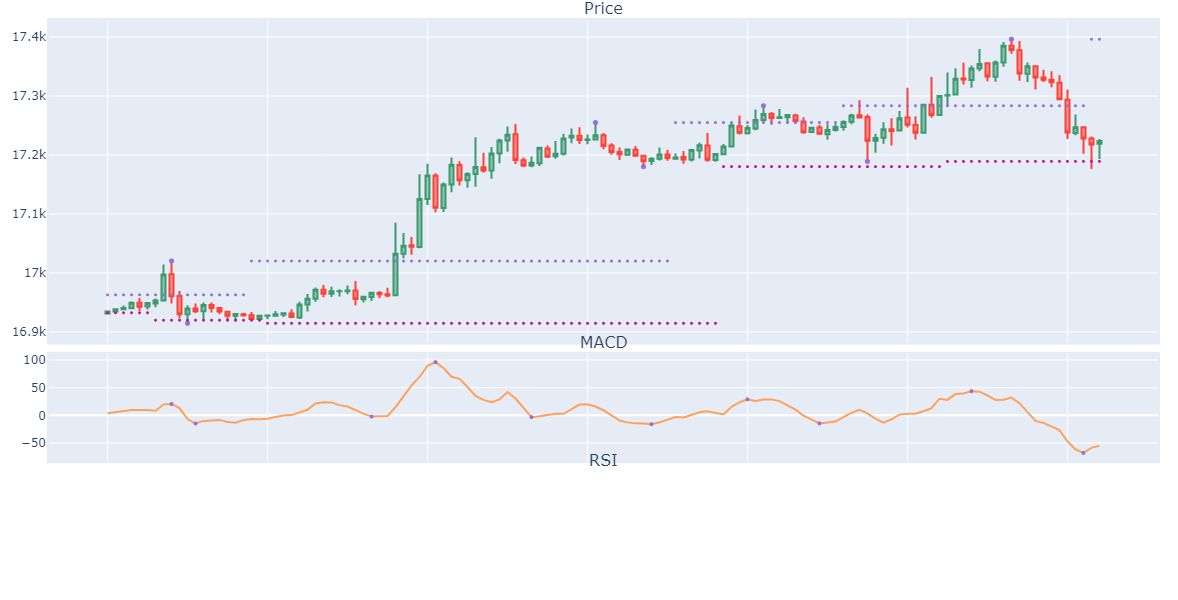

In [344]:
compare_index = 9660
BTCUSD_1122_0123_test.graph_Sample(compare_index - 100, compare_index+25)

In [312]:
BTCUSD_1122_0123_statS

count     mean      std       min       25%      50%  \
PipReturn_1bar  8.0000 -39.9725  56.2953 -172.9900  -40.9050 -23.0950   
PipReturn_3bar  8.0000 -18.8300  45.2595 -127.3200  -12.7350  -7.7300   
PipReturn_5bar  8.0000   2.6850  73.6246 -103.0100  -21.7700 -13.3500   
PipReturn_10bar 8.0000   1.8587  97.9042  -89.4600  -85.5575 -14.9800   
PipReturn_15bar 8.0000   5.0125 133.1718 -171.7800 -100.8900  10.5700   
PipReturn_20bar 8.0000  63.0850 272.9294 -182.8700  -42.8475   2.4200   

                     75%      max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  -12.1050   6.3200       -0.7101         -5.6804  
PipReturn_3bar    0.3850  16.6600       -0.4160         -3.3284  
PipReturn_5bar   11.8175 151.9000        0.0365          0.2918  
PipReturn_10bar  47.8350 188.8200        0.0190          0.1519  
PipReturn_15bar  92.9700 221.2000        0.0376          0.3011  
PipReturn_20bar  47.8325 705.5300        0.2311          1.8491

In [313]:
BTCUSD_1122_0123_statB

count     mean     std      min      25%      50%     75%  \
PipReturn_1bar  2.0000  11.7650 24.8972  -5.8400   2.9625  11.7650 20.5675   
PipReturn_3bar  2.0000  34.1250 67.2529 -13.4300  10.3475  34.1250 57.9025   
PipReturn_5bar  2.0000  34.4500 27.4923  15.0100  24.7300  34.4500 44.1700   
PipReturn_10bar 2.0000  45.5750 70.2086  -4.0700  20.7525  45.5750 70.3975   
PipReturn_15bar 2.0000   7.7450 20.8526  -7.0000   0.3725   7.7450 15.1175   
PipReturn_20bar 2.0000 -13.4700 28.9065 -33.9100 -23.6900 -13.4700 -3.2500   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  29.3700        0.4725          0.9451  
PipReturn_3bar  81.6800        0.5074          1.0148  
PipReturn_5bar  53.8900        1.2531          2.5062  
PipReturn_10bar 95.2200        0.6491          1.2983  
PipReturn_15bar 22.4900        0.3714          0.7428  
PipReturn_20bar  6.9700       -0.4660         -0.9320

In [294]:
BTCUSD_1122_0123_resultB

index                       time       open       high        low  \
0   3446  2022-12-25T21:45:00+07:00 16799.3100 16831.2200 16765.7900   

       close  upper 2nd  basis 2nd  lower 2nd   volume  ...    MACD     RSI  \
0 16829.2800        NaN        NaN        NaN 201.0577  ... -1.7873 52.0425   

      ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  \
0 15.2269      0          0       NaN           NaN          2.0000   

     CurrLow   CurrHigh  
0 16803.0000 16836.6700  

[1 rows x 41 columns]

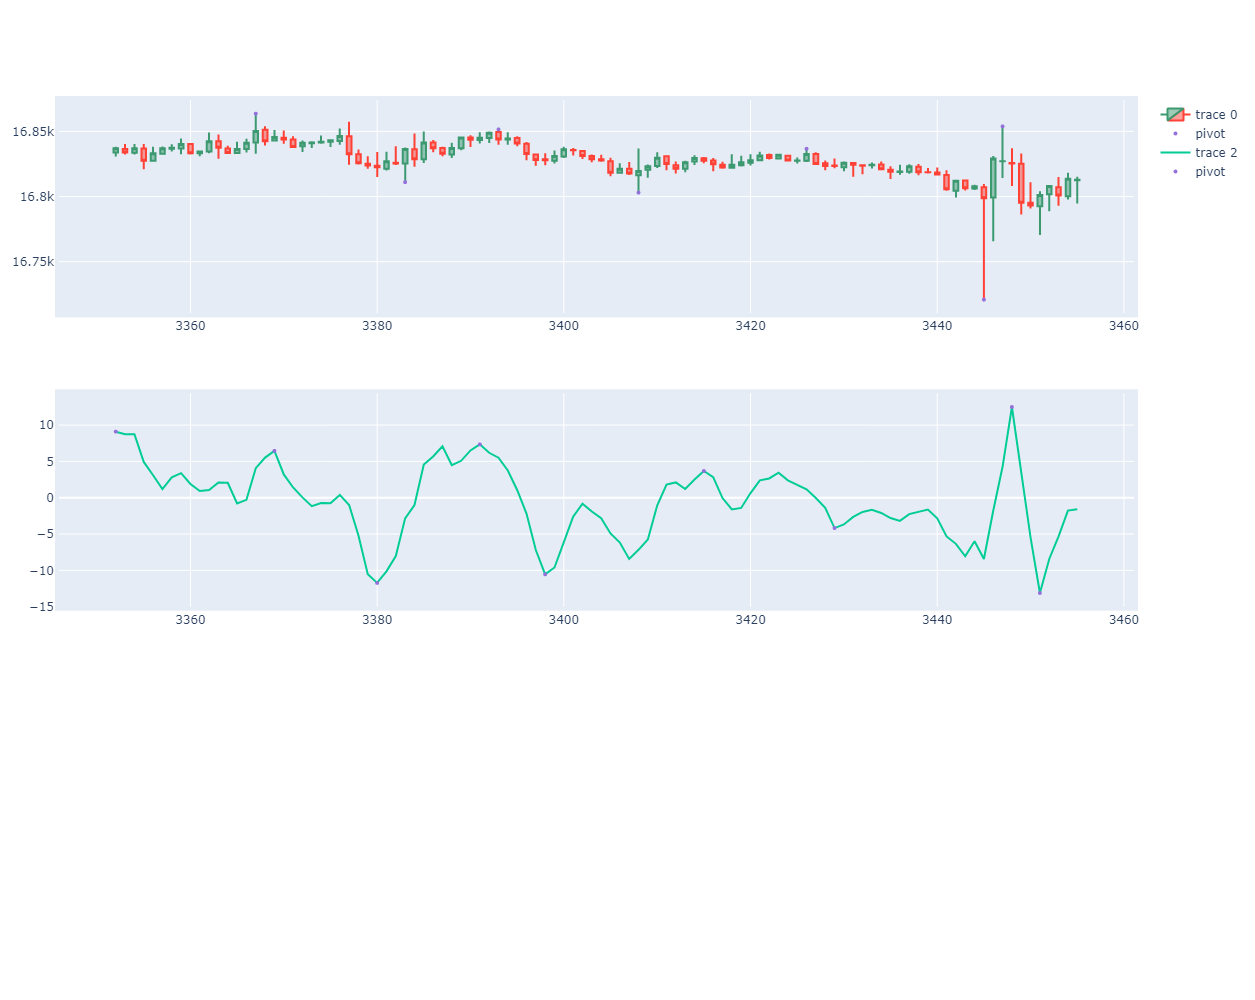

In [295]:
BTCUSD_1122_0123_test.graph_init_Sample(3352,3456,height= 1000)

In [169]:
BTCUSD_1122_0123_test.df.columns

Index(['time', 'open', 'high', 'low', 'close', 'upper 2nd', 'basis 2nd',
       'lower 2nd', 'volume', 'volume ma', 'upper', 'basis', 'lower', 'plot',
       'plot.1', 'atr', 'atr %', 'histogram', 'macd', 'signal',
       'LogReturn_1bar', 'LogReturn_3bar', 'LogReturn_10bar',
       'LogReturn_20bar', 'PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar',
       'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar', 'MACD', 'RSI',
       'ATR', 'pivot', 'MACDpivot', 'pointpos', 'MACDpointpos',
       'divSignal2MACD', 'CurrLow', 'CurrHigh'],
      dtype='object')

In [314]:
BTCUSD_1122_0123_resultS_copy = BTCUSD_1122_0123_resultS.copy()
BTCUSD_1122_0123_resultS_copy[pip_return_masking]  = BTCUSD_1122_0123_resultS_copy[pip_return_masking]*-1
BTCUSD_1122_0123_resultAll = pd.concat([BTCUSD_1122_0123_resultB, BTCUSD_1122_0123_resultS_copy])
BTCUSD_1122_0123_resultAll['time'] = pd.to_datetime(BTCUSD_1122_0123_resultAll['time'])
BTCUSD_1122_0123_resultAll = BTCUSD_1122_0123_resultAll.sort_values(by = "time")
BTCUSD_1122_0123_resultAll = BTCUSD_1122_0123_resultAll.reset_index().drop(columns = ['level_0'])

In [ ]:
BTCUSD_1122_0123_resultAll

In [315]:
GetStatAll(BTCUSD_1122_0123_resultAll)

count     mean      std       min      25%     50%     75%  \
PipReturn_1bar  10.0000  34.3310  51.7226   -6.3200   9.3350 23.0950 36.6450   
PipReturn_3bar  10.0000  21.8890  46.2315  -16.6600  -5.2950  7.7300 17.4650   
PipReturn_5bar  10.0000   4.7420  67.4177 -151.9000   3.1250 16.3150 28.4900   
PipReturn_10bar 10.0000   7.6280  91.6671 -188.8200 -28.3700 14.9800 87.3725   
PipReturn_15bar 10.0000  -2.4610 117.7749 -221.2000 -79.7125  7.7450 74.8850   
PipReturn_20bar 10.0000 -53.1620 241.8005 -705.5300 -37.6000 -5.3200 16.2800   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  172.9900        0.6638          6.6375  
PipReturn_3bar  127.3200        0.4735          4.7346  
PipReturn_5bar  103.0100        0.0703          0.7034  
PipReturn_10bar  95.2200        0.0832          0.8321  
PipReturn_15bar 171.7800       -0.0209         -0.2090  
PipReturn_20bar 182.8700       -0.2199         -2.1986

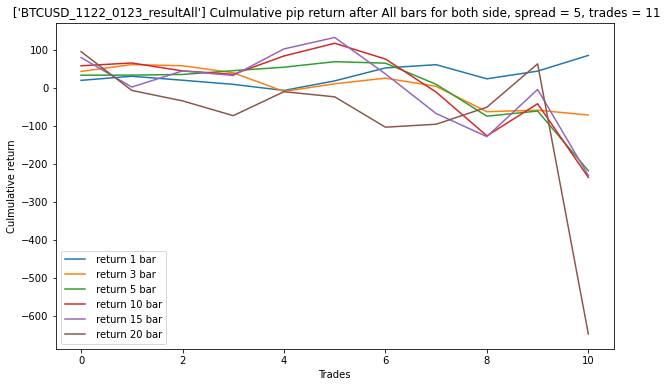

In [155]:
Plot_csPipReturn(BTCUSD_1122_0123_resultAll,side='All',spread=5,return_bar='All')

In [ ]:
dfpl = USOIL_1122_0123_resultAll
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl['time'],y=dfpl['PipReturn_3bar_cumsum']), row = 1, col = 1)    
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

## USOIL

### 15 Min

In [179]:
print(os.listdir("D:/Data/Commodity/USOIL/FX_USOIL, 15, 010922_080323.csv))

SyntaxError: unterminated string literal (detected at line 1) (4121790305.py, line 1)

In [182]:
USOIL15M = pd.read_csv("D:/Data/Commodity/USOIL/FX_USOIL, 15, 010922_080323.csv")
USOIL15M_test = TradingTest(USOIL15M,pipRetMulti=100)

In [183]:
compare_range = 10

In [184]:
USOIL15M_test.gen_pivot(compare_range,compare_range)
USOIL15M_test.gen_divSignal2(compare_range*10,compare_range)

pivot point generated with comparative range of( 10, 10 ) candle


time    open    high     low   close  volume  \
0      2022-09-01T05:00:00+07:00 88.8210 88.9410 88.7310 88.8700     522   
1      2022-09-01T05:15:00+07:00 88.8700 88.9160 88.8310 88.9110     310   
2      2022-09-01T05:30:00+07:00 88.9110 89.0960 88.8650 89.0440     401   
3      2022-09-01T05:45:00+07:00 89.0440 89.1490 89.0360 89.1350     238   
4      2022-09-01T06:00:00+07:00 89.1350 89.1350 89.0300 89.0440     207   
...                          ...     ...     ...     ...     ...     ...   
10295  2023-02-08T17:15:00+07:00 78.1840 78.2660 78.1210 78.1360     918   
10296  2023-02-08T17:30:00+07:00 78.1360 78.2560 78.0340 78.0440     740   
10297  2023-02-08T17:45:00+07:00 78.0440 78.1010 77.8790 77.9640     893   
10298  2023-02-08T18:00:00+07:00 77.9640 78.0050 77.8860 77.9060     768   
10299  2023-02-08T18:15:00+07:00 77.9060 77.9460 77.8440 77.9160     494   

       volume ma   upper   basis   lower  ...  UpperWick  LowerWick    MACD  \
0            NaN     NaN     NaN     NaN  ...     0.0710     0.1390     NaN   
1            NaN     NaN     NaN     NaN  ...     0.0050     0.0800     NaN   
2            NaN     NaN     NaN     NaN  ...     0.0520     0.1790     NaN   
3            NaN     NaN     NaN     NaN  ...     0.0140     0.0990     NaN   
4            NaN     NaN     NaN     NaN  ...     0.0910     0.0140     NaN   
...          ...     ...     ...     ...  ...        ...        ...     ...   
10295  1097.8500 78.2436 77.7880 77.3325  ...     0.1300     0.0150  0.1970   
10296  1111.7000 78.2702 77.8124 77.3547  ...     0.2120     0.0100  0.0765   
10297  1138.3500 78.2867 77.8269 77.3670  ...     0.1370     0.0850 -0.0418   
10298  1151.3000 78.2846 77.8344 77.3842  ...     0.0990     0.0200 -0.1516   
10299  1156.8000 78.2813 77.8422 77.4030  ...     0.0300     0.0720 -0.1809   

          RSI    ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  
0         NaN    NaN      0          0       NaN           NaN          1.0000  
1         NaN    NaN      0          0       NaN           NaN          1.0000  
2         NaN    NaN      0          0       NaN           NaN          1.0000  
3         NaN    NaN      0          0       NaN           NaN          1.0000  
4         NaN    NaN      0          0       NaN           NaN          1.0000  
...       ...    ...    ...        ...       ...           ...             ...  
10295 64.3311 0.2025      0          0       NaN           NaN          1.0000  
10296 62.3956 0.2034      0          0       NaN           NaN          1.0000  
10297 60.7514 0.2044      0          0       NaN           NaN          1.0000  
10298 59.5741 0.2001      0          0       NaN           NaN          1.0000  
10299 59.7133 0.1952      0          0       NaN           NaN          1.0000  

[10300 rows x 40 columns]

In [186]:
USOIL15M_test.df.divSignal2MACD.value_counts()

1.0000    1570
2.0000    1137
0.0000     549
Name: divSignal2MACD, dtype: int64

In [555]:
USOIL15M_resultS, USOIL15M_statS = falsebreak_wDiv_test(USOIL15M_test.df,side = 'sell', div_signal='divSignal2MACD',
                                                             elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass= 0.2,
                                                               fwdCandle = compare_range)
USOIL15M_resultB, USOIL15M_statB = falsebreak_wDiv_test(USOIL15M_test.df,side = 'buy', div_signal='divSignal2MACD',
                                                             elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass= 0.2,
                                                                fwdCandle = compare_range)

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\4075352777.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\4075352777.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.2, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_21408\4075352777.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\4075352777.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.2, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


In [556]:
USOIL15M_statS

count     mean      std       min       25%      50%     75%  \
PipReturn_1bar  6.0000  11.0167  30.7636  -47.5000    7.0250  22.5500 30.6500   
PipReturn_3bar  6.0000 -10.4667  80.9848 -165.8000   -5.0500   8.0500 20.6250   
PipReturn_5bar  6.0000 -19.7500  76.2354 -147.4000  -39.1250 -14.0000 13.5250   
PipReturn_10bar 6.0000 -42.7167  82.2537 -184.8000  -76.3500   0.6000 10.2750   
PipReturn_15bar 6.0000 -53.7167 110.9893 -279.0000  -25.0750  -9.7000  0.2750   
PipReturn_20bar 6.0000 -53.4500 138.0934 -229.5000 -160.5750 -25.4000 19.4000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   33.3000        0.3581          2.1486  
PipReturn_3bar   71.5000       -0.1292         -0.7755  
PipReturn_5bar   81.7000       -0.2591         -1.5544  
PipReturn_10bar  15.8000       -0.5193         -3.1160  
PipReturn_15bar   2.7000       -0.4840         -2.9039  
PipReturn_20bar 130.9000       -0.3871         -2.3223

In [557]:
USOIL15M_statB

count    mean     std      min      25%      50%     75%  \
PipReturn_1bar  5.0000 -4.2000 16.8868 -31.4000  -9.5000   3.0000  7.8000   
PipReturn_3bar  5.0000 -5.4200 52.2972 -61.4000 -38.5000 -11.9000  9.9000   
PipReturn_5bar  5.0000  3.0200 48.2753 -54.0000 -16.9000  -1.0000  9.0000   
PipReturn_10bar 5.0000 15.5200 65.6343 -94.0000  22.9000  29.1000 36.6000   
PipReturn_15bar 5.0000 45.6200 30.0572   9.4000  19.9000  54.1000 64.0000   
PipReturn_20bar 5.0000 51.9800 31.6944   7.4000  29.6000  70.9000 73.0000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   9.1000       -0.2487         -1.2436  
PipReturn_3bar  74.8000       -0.1036         -0.5182  
PipReturn_5bar  78.0000        0.0626          0.3128  
PipReturn_10bar 83.0000        0.2365          1.1823  
PipReturn_15bar 80.7000        1.5178          7.5889  
PipReturn_20bar 79.0000        1.6400          8.2002

In [558]:
USOIL15M_resultAll = GetResultAll(USOIL15M_resultS,USOIL15M_resultB)
USOIL15M_statAll = GetStatAll(USOIL15M_resultAll)

In [559]:
USOIL15M_statAll

count    mean     std       min      25%      50%     75%  \
PipReturn_1bar  11.0000 -7.9182 24.4936  -33.3000 -30.3000  -9.5000  5.4000   
PipReturn_3bar  11.0000  3.2455 66.6491  -71.5000 -29.8500 -11.9000  7.8500   
PipReturn_5bar  11.0000 12.1455 62.5656  -81.7000 -19.0500   9.0000 32.2500   
PipReturn_10bar 11.0000 30.3545 72.8540  -94.0000  -8.0500  22.9000 59.8000   
PipReturn_15bar 11.0000 50.0364 80.8614   -2.7000   7.4500  19.9000 59.0500   
PipReturn_20bar 11.0000 52.7818 99.6860 -130.9000   7.9500  42.3000 76.0000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   47.5000       -0.3233         -3.5560  
PipReturn_3bar  165.8000        0.0487          0.5356  
PipReturn_5bar  147.4000        0.1941          2.1354  
PipReturn_10bar 184.8000        0.4166          4.5831  
PipReturn_15bar 279.0000        0.6188          6.8067  
PipReturn_20bar 229.5000        0.5295          5.8243

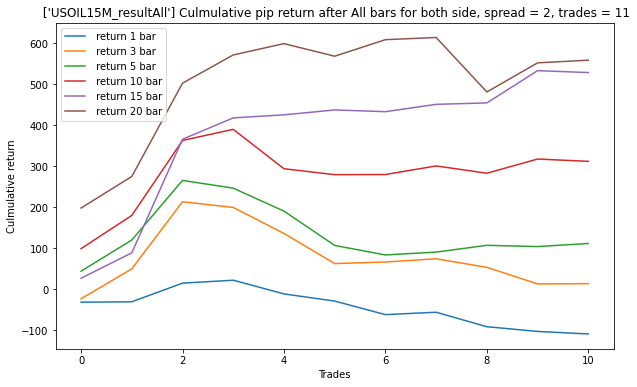

In [560]:
Plot_csPipReturn(USOIL15M_resultAll,'All',2,'All')

In [198]:
USOIL15M_resultS

index                       time    open    high     low   close  volume  \
0    150  2022-09-02T19:30:00+07:00 88.0900 89.6360 88.0850 88.9590    6781   
1    236  2022-09-05T18:15:00+07:00 89.2760 89.6850 89.2650 89.5950    2229   
2   2709  2022-10-12T19:15:00+07:00 89.7410 90.0490 89.4460 89.4490    2797   
3   3993  2022-11-01T19:00:00+07:00 87.6460 88.4310 87.6460 88.1940    3306   
4   4098  2022-11-02T22:15:00+07:00 89.2640 89.8350 89.2610 89.6840    4142   
5   4728  2022-11-11T21:00:00+07:00 88.9050 89.6110 88.8560 89.1460    4245   
6   7842  2022-12-30T21:30:00+07:00 78.3890 79.2240 78.3260 79.0010    4852   
7   9799  2023-02-01T08:00:00+07:00 79.0390 79.3100 79.0090 79.1490    1277   

   volume ma   upper   basis  ...    ATR  pivot  MACDpivot  pointpos  \
0  2293.7000 89.3336 88.3841  ... 0.4221      2          0   89.6361   
1  2242.1000 89.6906 89.0574  ... 0.2814      0          0       NaN   
2  2482.9500 90.1953 89.4833  ... 0.3164      2          0   90.0491   
3  1876.1500 88.3601 87.7007  ... 0.2931      0          0       NaN   
4  3099.3500 89.4344 88.6493  ... 0.3489      0          0       NaN   
5  2007.5500 89.7403 88.9960  ... 0.3308      0          0       NaN   
6  1592.0000 79.0487 78.3348  ... 0.3173      0          0       NaN   
7   437.3500 79.4036 78.9843  ... 0.1864      0          0       NaN   

   MACDpointpos  divSignal2MACD  CurrLow  CurrHigh  maxHi10bar  maxLo10bar  
0           NaN          1.0000  87.8140   89.3260     89.6360     87.8410  
1           NaN          1.0000  86.5990   89.6360     89.6850     88.8940  
2           NaN          1.0000  88.2440   89.9090     90.0490     89.3150  
3           NaN          1.0000  87.0890   88.2210     88.4310     87.4340  
4           NaN          1.0000  87.7190   89.7360     89.8350     87.7490  
5           NaN          1.0000  86.1100   89.5510     89.6110     88.7400  
6           NaN          1.0000  77.7000   79.0510     79.2240     77.7090  
7           NaN          1.0000  78.2240   79.2300     79.3100     78.9960  

[8 rows x 45 columns]

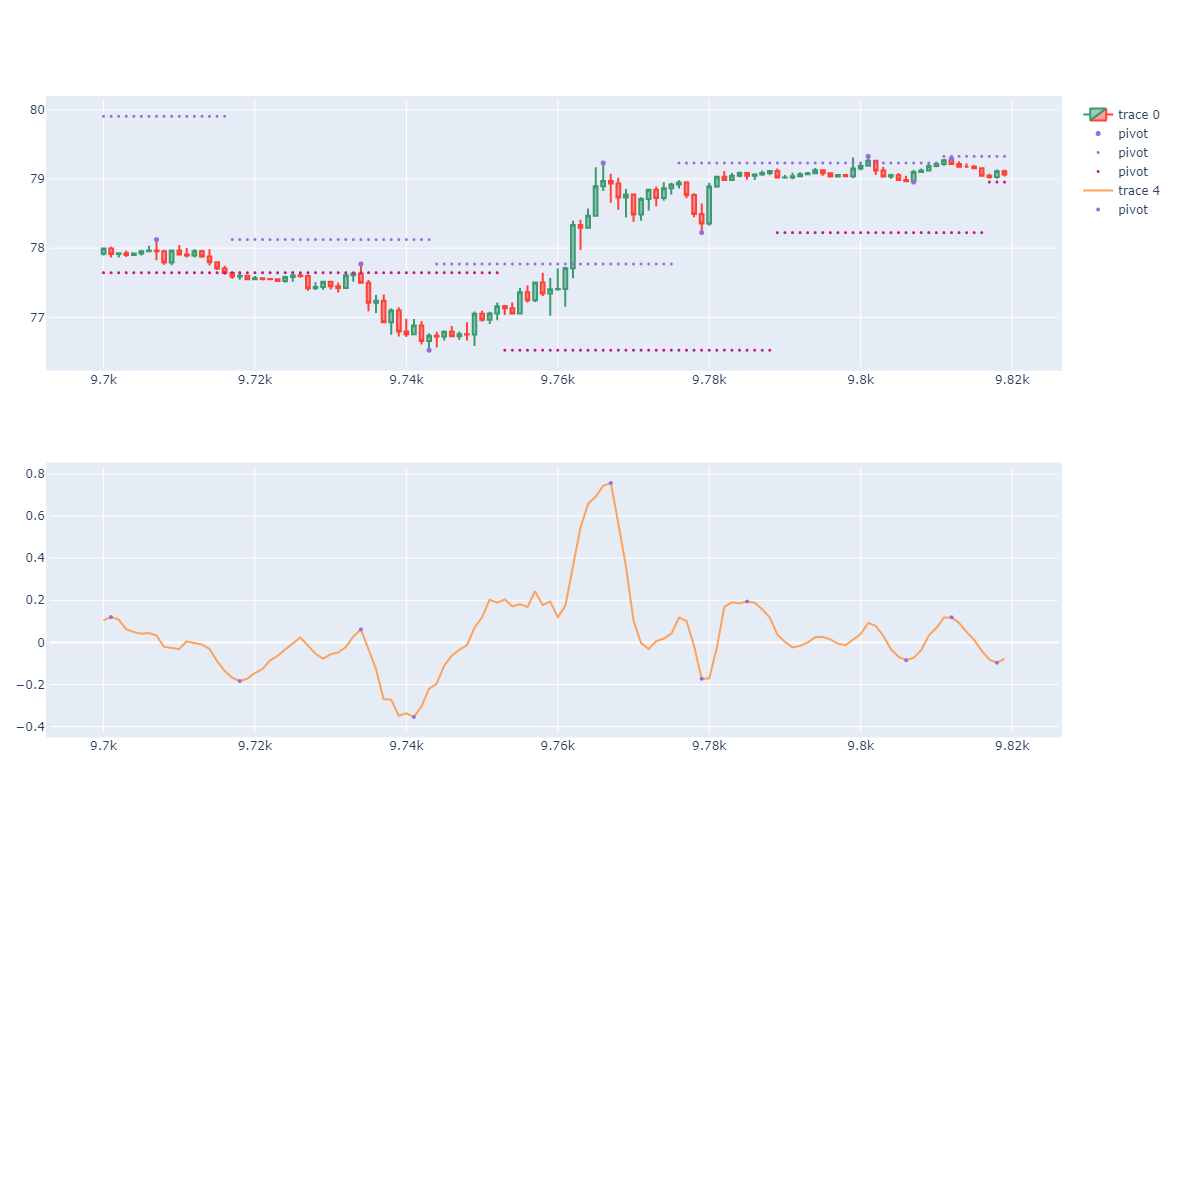

In [201]:
USOIL15M_test.graph_init_Sample(9700,9820, height = 1200)

In [ ]:
dfpl = USOIL15M_resultAll
fig = make_subplots()       
fig.append_trace(go.Scatter(x=dfpl['time'],y=dfpl['PipReturn_10bar_cumsum']), row = 1, col = 1)    
            
fig.update_layout(xaxis_rangeslider_visible= False, width= 1000 ,height= 600,margin=dict(l=50,r=50,b=100,t=100,pad=4))

## EURAUD

In [ ]:
print(os.listdir("D:Data/Forex/EURAUD/OANDA_EURAUD, 15 0822_0223.csv))

In [71]:
EURAUD_15M_df = pd.read_csv("D:Data/Forex/EURAUD/OANDA_EURAUD, 15 0822_0223.csv")
EURAUD_15M_test = TradingTest(EURAUD_15M_df, pipRetMulti= 10000)
EURAUD_15M_test.gen_pivot(5,5)

pivot point generated with comparative range of( 5, 5 ) candle


In [24]:
compare_range = 10

In [73]:
EURAUD_15M_test.gen_pivot(compare_range,compare_range)

pivot point generated with comparative range of( 10, 10 ) candle


In [74]:
EURAUD_15M_test.gen_divSignal2(compare_range*10,compare_range)

time   open   high    low  close  volume  \
0      2022-09-01T04:00:00+07:00 1.4694 1.4694 1.4681 1.4687     357   
1      2022-09-01T04:15:00+07:00 1.4687 1.4702 1.4686 1.4691     887   
2      2022-09-01T04:30:00+07:00 1.4691 1.4696 1.4683 1.4689     407   
3      2022-09-01T04:45:00+07:00 1.4689 1.4690 1.4685 1.4686     158   
4      2022-09-01T05:00:00+07:00 1.4686 1.4694 1.4686 1.4694     636   
...                          ...    ...    ...    ...    ...     ...   
10883  2023-02-08T14:45:00+07:00 1.5390 1.5400 1.5384 1.5399    3031   
10884  2023-02-08T15:00:00+07:00 1.5399 1.5403 1.5389 1.5397    3763   
10885  2023-02-08T15:15:00+07:00 1.5397 1.5397 1.5380 1.5385    3072   
10886  2023-02-08T15:30:00+07:00 1.5385 1.5401 1.5381 1.5393    3128   
10887  2023-02-08T15:45:00+07:00 1.5393 1.5400 1.5393 1.5394    1055   

       volume ma  upper  basis  lower  ...  UpperWick  LowerWick    MACD  \
0            NaN    NaN    NaN    NaN  ...     0.0007     0.0007     NaN   
1            NaN    NaN    NaN    NaN  ...     0.0012     0.0004     NaN   
2            NaN    NaN    NaN    NaN  ...     0.0006     0.0007     NaN   
3            NaN    NaN    NaN    NaN  ...     0.0004     0.0001     NaN   
4            NaN    NaN    NaN    NaN  ...     0.0000     0.0008     NaN   
...          ...    ...    ...    ...  ...        ...        ...     ...   
10883  1504.2500 1.5429 1.5403 1.5377  ...     0.0001     0.0015 -0.0006   
10884  1620.2000 1.5429 1.5403 1.5376  ...     0.0006     0.0008 -0.0002   
10885  1710.5500 1.5428 1.5401 1.5374  ...     0.0012     0.0004 -0.0001   
10886  1784.4000 1.5428 1.5400 1.5372  ...     0.0008     0.0012 -0.0002   
10887  1766.3000 1.5427 1.5400 1.5372  ...     0.0006     0.0001 -0.0002   

          RSI    ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  
0         NaN    NaN      0          0       NaN           NaN             NaN  
1         NaN    NaN      0          0       NaN           NaN             NaN  
2         NaN    NaN      0          0       NaN           NaN             NaN  
3         NaN    NaN      0          0       NaN           NaN             NaN  
4         NaN    NaN      0          0       NaN           NaN             NaN  
...       ...    ...    ...        ...       ...           ...             ...  
10883 43.7385 0.0012      0          0       NaN           NaN          0.0000  
10884 43.1043 0.0012      0          0       NaN           NaN          0.0000  
10885 40.2482 0.0012      0          0       NaN           NaN          0.0000  
10886 42.9202 0.0012      0          0       NaN           NaN          0.0000  
10887 43.1082 0.0012      0          0       NaN           NaN          0.0000  

[10888 rows x 40 columns]

In [75]:
EURAUD_15M_test.df.divSignal2MACD.value_counts()

0.0000    7582
1.0000     945
2.0000     555
Name: divSignal2MACD, dtype: int64

In [343]:
EURAUD_15M_resultS, EURAUD_15M_statS = falsebreak_wDiv_test(EURAUD_15M_test.df,
                                                                side = 'sell', elim_cons_trade = True,
                                                                falsebreak_bar= 0, ATR_surpass= 0.1,
                                                                ATR_commpare_range=0, fwdCandle=compare_range
                                                                )
EURAUD_15M_resultB, EURAUD_15M_statB = falsebreak_wDiv_test(EURAUD_15M_test.df,
                                                                side = 'buy', elim_cons_trade = True , 
                                                                falsebreak_bar= 0, ATR_surpass= 0.1,
                                                                ATR_commpare_range=0,fwdCandle=compare_range
                                                                )

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.1, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.1, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


In [344]:
EURAUD_15M_resultS_copy = EURAUD_15M_resultS.copy()
EURAUD_15M_resultS_copy[pip_return_masking]  = EURAUD_15M_resultS_copy[pip_return_masking]*-1
EURAUD_15M_resultAll = pd.concat([EURAUD_15M_resultB, EURAUD_15M_resultS_copy])
EURAUD_15M_resultAll['time'] = pd.to_datetime(EURAUD_15M_resultAll['time'])
EURAUD_15M_resultAll = EURAUD_15M_resultAll.sort_values(by = "time")
EURAUD_15M_resultAll = EURAUD_15M_resultAll.reset_index().drop(columns = ['level_0'])
EURAUD_15M_StatAll = GetStatAll(EURAUD_15M_resultAll)

In [345]:
EURAUD_15M_statS

count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  5.0000  0.6600 11.0780  -8.4000  -8.1000 -3.5000  5.6000   
PipReturn_3bar  5.0000 -3.1200 15.3110 -21.6000 -17.9000  6.5000  7.0000   
PipReturn_5bar  5.0000 -1.3600 16.7358 -30.2000  -1.0000  6.2000  6.6000   
PipReturn_10bar 5.0000 -0.8000 16.5250 -27.4000  -5.5000  5.8000  8.9000   
PipReturn_15bar 5.0000 -7.8000 32.1236 -51.2000 -23.4000 -1.1000  1.2000   
PipReturn_20bar 5.0000 -9.2400 37.3428 -63.4000 -25.4000 -6.1000 16.7000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  17.7000        0.0596          0.2979  
PipReturn_3bar  10.4000       -0.2038         -1.0189  
PipReturn_5bar  11.6000       -0.0813         -0.4063  
PipReturn_10bar 14.2000       -0.0484         -0.2421  
PipReturn_15bar 35.5000       -0.2428         -1.2141  
PipReturn_20bar 32.0000       -0.2474         -1.2372

In [346]:
EURAUD_15M_statB

count  mean  std  min  25%  50%  75%  max  Sharpe ratio  \
PipReturn_1bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_3bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_5bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_10bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_15bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_20bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   

                 Count x Sharpe  
PipReturn_1bar              NaN  
PipReturn_3bar              NaN  
PipReturn_5bar              NaN  
PipReturn_10bar             NaN  
PipReturn_15bar             NaN  
PipReturn_20bar             NaN

In [80]:
EURAUD_15M_StatAll

count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  11.0000  0.3364  9.1689 -17.7000  -3.9000  1.8000  6.7500   
PipReturn_3bar  11.0000 -0.8091 14.6840 -23.2000  -9.5500 -6.5000 11.5500   
PipReturn_5bar  11.0000 -0.5273 15.3308 -17.5000  -9.5500 -6.2000  3.7000   
PipReturn_10bar 11.0000  5.4727 25.9025 -35.0000 -11.5500  5.5000 27.2000   
PipReturn_15bar 11.0000 15.2273 37.0293 -35.5000 -13.4000 13.8000 47.4000   
PipReturn_20bar 11.0000  8.2273 36.1063 -42.8000 -24.3500 25.4000 28.2000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  12.9000        0.0367          0.4035  
PipReturn_3bar  21.6000       -0.0551         -0.6061  
PipReturn_5bar  30.2000       -0.0344         -0.3783  
PipReturn_10bar 46.3000        0.2113          2.3241  
PipReturn_15bar 65.6000        0.4112          4.5234  
PipReturn_20bar 63.4000        0.2279          2.5065

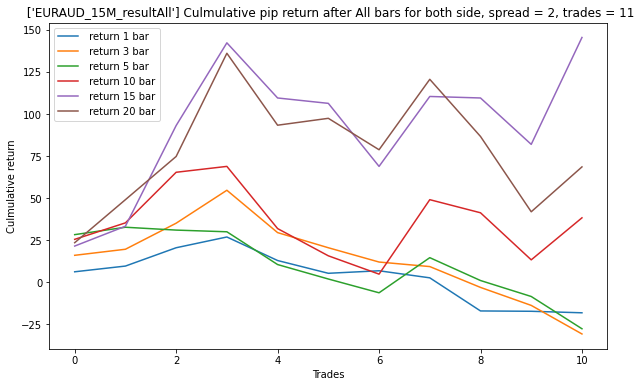

In [90]:
Plot_csPipReturn(EURAUD_15M_resultAll,side='All',spread=2, return_bar='All')

In [83]:
EURAUD_15M_resultB

index                       time   open   high    low  close  volume  \
0   9421  2023-01-18T09:15:00+07:00 1.5434 1.5436 1.5424 1.5432    1610   
1   9436  2023-01-18T13:00:00+07:00 1.5409 1.5413 1.5399 1.5407    2216   

   volume ma  upper  basis  ...    ATR  pivot  MACDpivot  pointpos  \
0  1149.5000 1.5469 1.5442  ... 0.0012      0          0       NaN   
1  2567.2500 1.5454 1.5422  ... 0.0014      0          0       NaN   

   MACDpointpos  divSignal2MACD  CurrLow  CurrHigh  maxHi10bar  maxLo10bar  
0           NaN          2.0000   1.5427    1.5464      1.5455      1.5424  
1           NaN          2.0000   1.5399    1.5455      1.5439      1.5399  

[2 rows x 45 columns]

In [69]:
EURAUD_15M_test.df.iloc[6071]

time               2022-11-01T07:00:00+07:00
open                               1632.5150
high                               1632.6150
low                                1630.7950
close                              1632.0750
upper 2nd                                NaN
basis 2nd                                NaN
lower 2nd                                NaN
volume                                   231
volume ma                           360.1000
upper                              1638.5675
basis                              1633.6998
lower                              1628.8322
plot                                  0.0000
plot.1                                     0
atr                                   1.1828
atr %                                 0.0725
histogram                            -0.1109
macd                                 -0.6988
signal                               -0.5880
LogReturn_1bar                        0.0005
LogReturn_3bar                        0.0012
LogReturn_

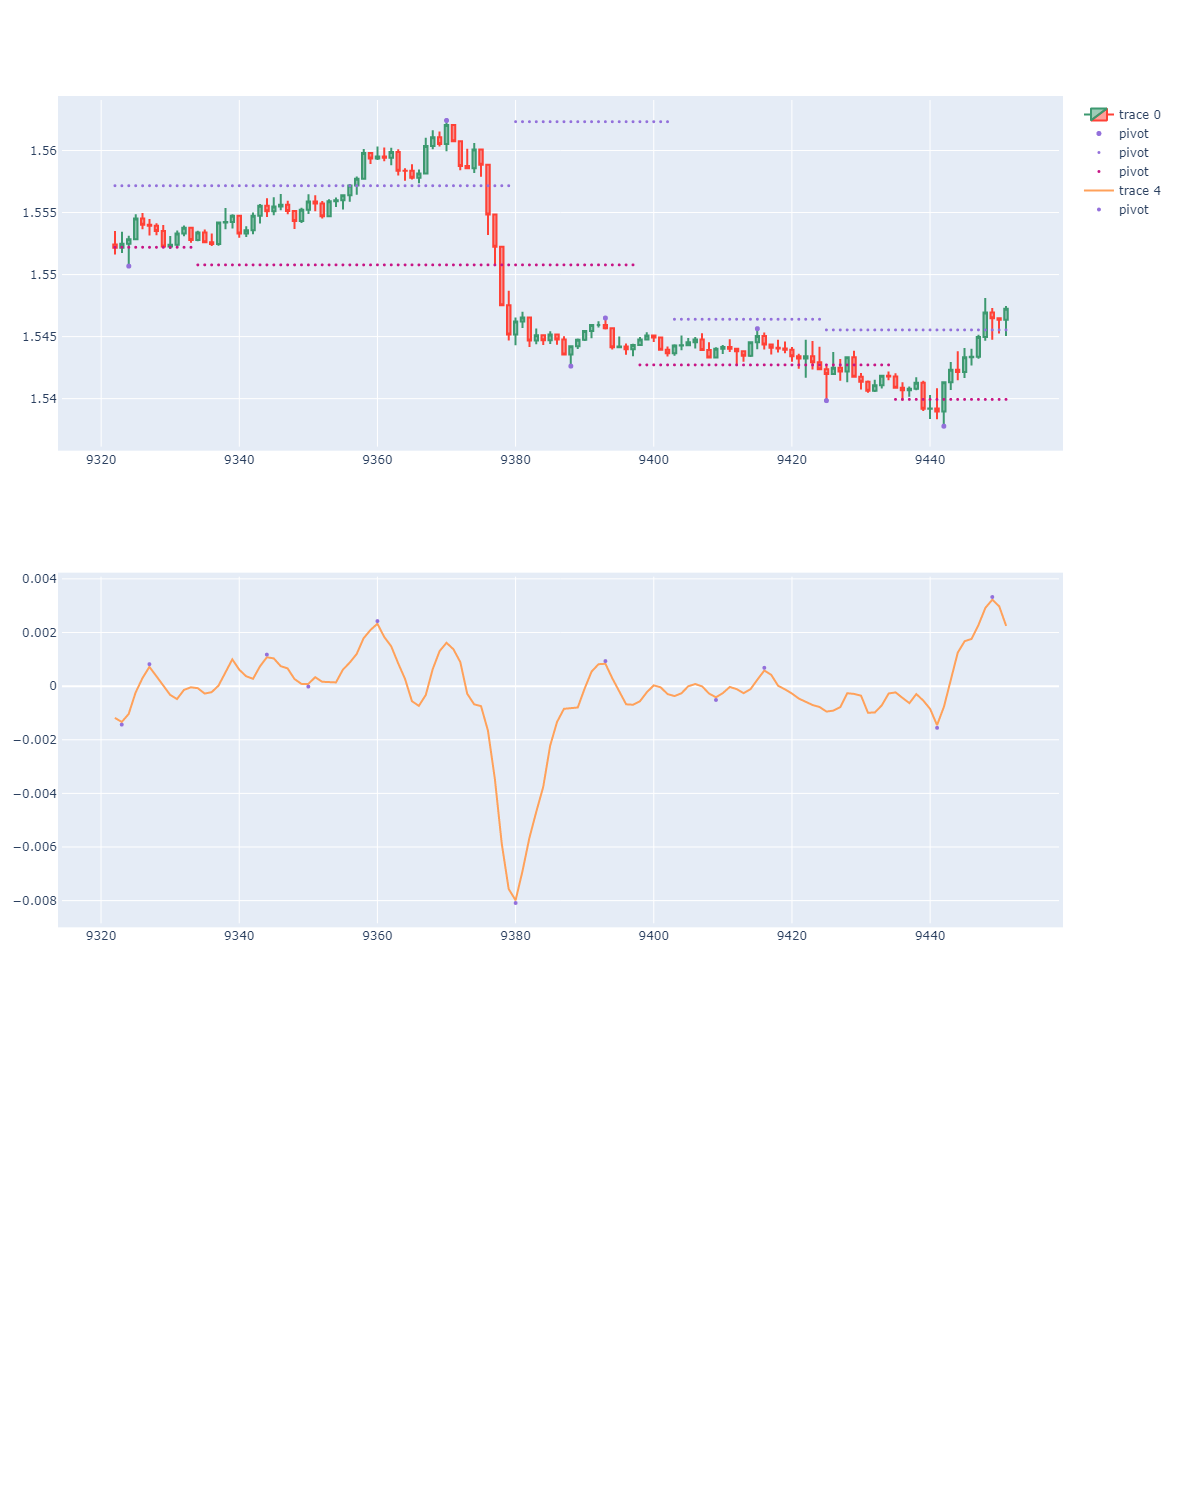

In [89]:
EURAUD_15M_test.graph_init_Sample(9322,9452, height = 1500)

## GBPAUD

In [346]:
GBPAUD15M_0922_0223 = pd.read_csv("D:Data/Forex/GBPAUD/OANDA_GBPAUD, 15, 0922_0223.csv")
GBPAUD15M_0922_0223_test = TradingTest(GBPAUD15M_0922_0223,10000)

In [347]:
GBPAUD15M_0922_0223_test.gen_pivot(10,10)
GBPAUD15M_0922_0223_test.gen_divSignal2(100,10)

pivot point generated with comparative range of( 10, 10 ) candle
divergence sigal generated with comparative range of( 10, 10 ) candle


In [350]:
GBPAUD15M_0922_0223_test.test_falseBreakSig2MACD(ATR_surpass=0.1)

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3784917464.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3784917464.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.1, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3784917464.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_27200\3784917464.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.1, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
Sell stats


count     mean     std      min      25%      50%     75%  \
PipReturn_1bar  4.0000   9.1500  8.8267  -2.1000   4.4250  10.5000 15.2250   
PipReturn_3bar  4.0000  -0.5750 11.9461 -12.8000  -6.7250  -2.5500  3.6000   
PipReturn_5bar  4.0000  -1.8000 31.9836 -47.2000 -11.0500   6.8500 16.1000   
PipReturn_10bar 4.0000 -12.8500 16.8882 -37.0000 -16.6000  -8.3000 -4.5500   
PipReturn_15bar 4.0000 -12.8500 25.8483 -38.5000 -33.3250 -12.2000  8.2750   
PipReturn_20bar 4.0000 -22.2000 27.9021 -54.7000 -40.8250 -18.1000  0.5250   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  17.7000        1.0366          4.1465  
PipReturn_3bar  15.6000       -0.0481         -0.1925  
PipReturn_5bar  26.3000       -0.0563         -0.2251  
PipReturn_10bar  2.2000       -0.7609         -3.0436  
PipReturn_15bar 11.5000       -0.4971         -1.9885  
PipReturn_20bar  2.1000       -0.7956         -3.1826

Buy Stats


count    mean     std       min      25%     50%     75%  \
PipReturn_1bar  6.0000  0.9667  9.4093  -10.7000  -5.6500  0.7500  6.1750   
PipReturn_3bar  6.0000  9.1167 13.2471   -6.4000  -0.5250  7.0000 19.4000   
PipReturn_5bar  6.0000 11.4000 24.8971  -14.2000   1.5250  5.1500 11.1750   
PipReturn_10bar 6.0000 17.8500 25.0167  -21.7000  11.5750 19.6500 23.5250   
PipReturn_15bar 6.0000 15.0833 79.0290 -120.5000  -5.2250 18.4000 70.6000   
PipReturn_20bar 6.0000 11.3000 90.0684 -118.9000 -34.9250  6.2000 84.3000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   14.8000        0.1027          0.6164  
PipReturn_3bar   26.6000        0.6882          4.1292  
PipReturn_5bar   58.8000        0.4579          2.7473  
PipReturn_10bar  55.8000        0.7135          4.2811  
PipReturn_15bar  99.3000        0.1909          1.1451  
PipReturn_20bar 112.6000        0.1255          0.7528

All Stats


count    mean     std       min     25%     50%     75%  \
PipReturn_1bar  10.0000 -3.0800 10.1217  -17.7000 -9.7000 -4.5500  3.5250   
PipReturn_3bar  10.0000  5.7000 12.8264  -15.6000 -0.9500  3.4000 12.5750   
PipReturn_5bar  10.0000  7.5600 26.6445  -26.3000 -9.7750  2.3500 11.1750   
PipReturn_10bar 10.0000 15.8500 21.1996  -21.7000  7.5500 13.1500 23.5250   
PipReturn_15bar 10.0000 14.1900 60.7767 -120.5000 -9.7500 18.4000 36.7750   
PipReturn_20bar 10.0000 15.6600 69.2679 -118.9000 -1.5750  6.2000 50.0750   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   14.8000       -0.3043         -3.0430  
PipReturn_3bar   26.6000        0.4444          4.4439  
PipReturn_5bar   58.8000        0.2837          2.8374  
PipReturn_10bar  55.8000        0.7477          7.4766  
PipReturn_15bar  99.3000        0.2335          2.3348  
PipReturn_20bar 112.6000        0.2261          2.2608

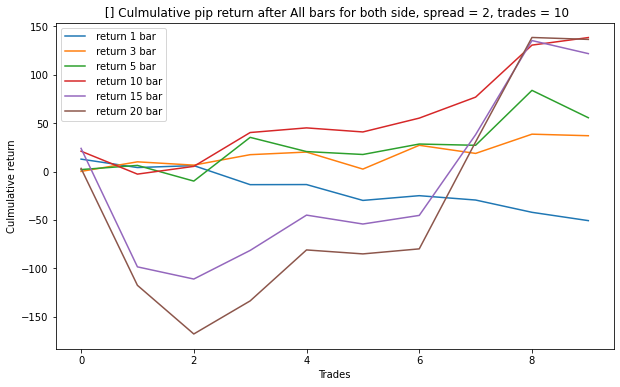

In [351]:
GBPAUD15M_0922_0223_test.plot_PipReturn()

In [352]:
GBPAUD15M_0922_0223_test.result_Sell

index                       time   open   high    low  close  basis  upper  \
0   3107  2022-10-17T12:45:00+07:00 1.8060 1.8103 1.8059 1.8080    NaN    NaN   
1   4034  2022-10-31T04:30:00+07:00 1.8100 1.8131 1.8092 1.8115    NaN    NaN   
2   5583  2022-11-22T08:45:00+07:00 1.7908 1.7920 1.7908 1.7910    NaN    NaN   
3  10647  2023-02-04T03:45:00+07:00 1.7409 1.7417 1.7407 1.7408    NaN    NaN   

   lower  upper 2nd  ...    ATR  pivot  MACDpivot  pointpos  MACDpointpos  \
0    NaN        NaN  ... 0.0020      0          0       NaN           NaN   
1    NaN        NaN  ... 0.0017      1          0    1.8091           NaN   
2    NaN        NaN  ... 0.0011      0          0       NaN           NaN   
3    NaN        NaN  ... 0.0016      0          0       NaN           NaN   

   divSignal2MACD  CurrLow  CurrHigh  maxHi10bar  maxLo10bar  
0          1.0000   1.8013    1.8100      1.8103      1.8015  
1          1.0000   1.7872    1.8126      1.8131      1.8092  
2          1.0000   1.7888    1.7913      1.7920      1.7892  
3          1.0000   1.7335    1.7412      1.7417      1.7390  

[4 rows x 55 columns]

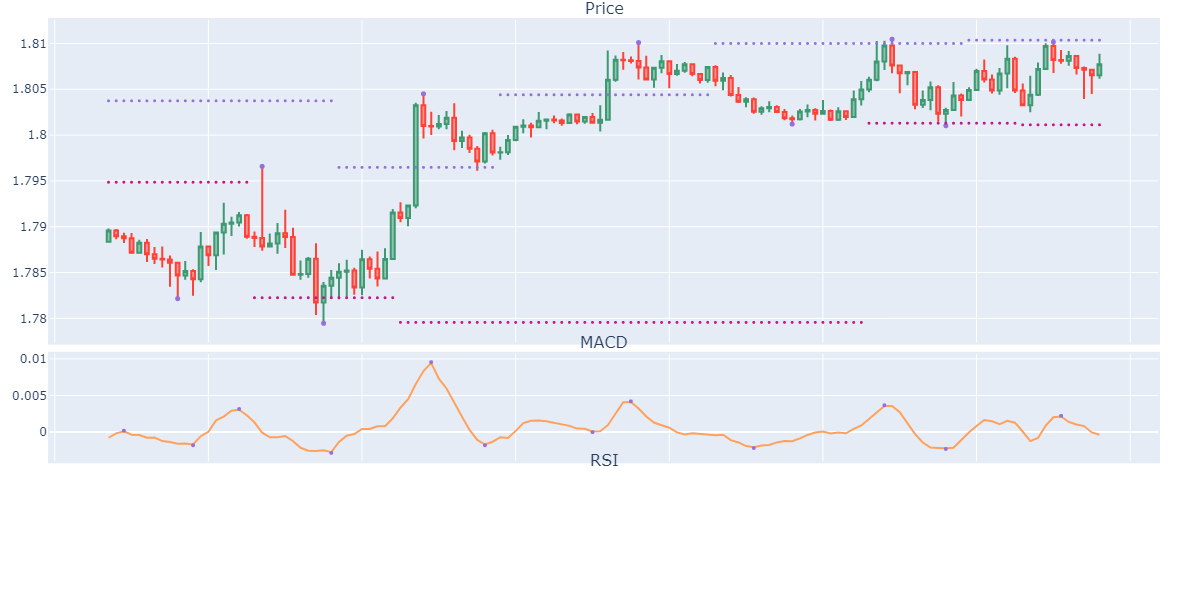

In [357]:
a = 3107
GBPAUD15M_0922_0223_test.graph_Sample(a-100, a+30)

# EURCHF

In [ ]:
print(os.listdir("D:Data/Forex/EURCHF/OANDA_EURCHF, 15, 0822_0223.csv))

In [103]:
EURCHF_15M_df = pd.read_csv("D:Data/Forex/EURCHF/OANDA_EURCHF, 15, 0822_0223.csv")
EURCHF_15M_test = TradingTest(EURCHF_15M_df, pipRetMulti= 10000)

In [104]:
compare_range = 10

In [105]:
EURCHF_15M_test.gen_pivot(compare_range,compare_range)

pivot point generated with comparative range of( 10, 10 ) candle


In [106]:
EURCHF_15M_test.gen_divSignal2(compare_range*10,compare_range)

time   open   high    low  close  volume  \
0      2022-09-01T04:00:00+07:00 0.9832 0.9832 0.9815 0.9821     103   
1      2022-09-01T04:15:00+07:00 0.9821 0.9829 0.9817 0.9823     186   
2      2022-09-01T04:30:00+07:00 0.9823 0.9829 0.9823 0.9828     235   
3      2022-09-01T04:45:00+07:00 0.9828 0.9831 0.9826 0.9830      83   
4      2022-09-01T05:00:00+07:00 0.9830 0.9831 0.9828 0.9829     363   
...                          ...    ...    ...    ...    ...     ...   
10885  2023-02-08T15:30:00+07:00 0.9874 0.9877 0.9871 0.9873    1289   
10886  2023-02-08T15:45:00+07:00 0.9873 0.9878 0.9872 0.9878    1222   
10887  2023-02-08T16:00:00+07:00 0.9878 0.9880 0.9873 0.9878    1347   
10888  2023-02-08T16:15:00+07:00 0.9878 0.9882 0.9877 0.9880    1249   
10889  2023-02-08T16:30:00+07:00 0.9880 0.9882 0.9876 0.9879    1099   

       volume ma  upper  basis  lower  ...  UpperWick  LowerWick    MACD  \
0            NaN    NaN    NaN    NaN  ...     0.0011     0.0006     NaN   
1            NaN    NaN    NaN    NaN  ...     0.0007     0.0005     NaN   
2            NaN    NaN    NaN    NaN  ...     0.0001     0.0005     NaN   
3            NaN    NaN    NaN    NaN  ...     0.0001     0.0004     NaN   
4            NaN    NaN    NaN    NaN  ...     0.0001     0.0001     NaN   
...          ...    ...    ...    ...  ...        ...        ...     ...   
10885   727.3500 0.9896 0.9887 0.9878  ...     0.0004     0.0002 -0.0010   
10886   766.6500 0.9896 0.9886 0.9877  ...     0.0000     0.0006 -0.0010   
10887   806.0000 0.9895 0.9885 0.9876  ...     0.0002     0.0004 -0.0007   
10888   852.7500 0.9895 0.9885 0.9875  ...     0.0002     0.0003 -0.0004   
10889   883.2500 0.9894 0.9884 0.9874  ...     0.0003     0.0003 -0.0002   

          RSI    ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  
0         NaN    NaN      0          0       NaN           NaN          0.0000  
1         NaN    NaN      0          0       NaN           NaN          0.0000  
2         NaN    NaN      0          0       NaN           NaN          0.0000  
3         NaN    NaN      0          0       NaN           NaN          0.0000  
4         NaN    NaN      0          0       NaN           NaN          0.0000  
...       ...    ...    ...        ...       ...           ...             ...  
10885 33.6250 0.0004      0          0       NaN           NaN          0.0000  
10886 38.2740 0.0004      0          0       NaN           NaN          0.0000  
10887 38.2125 0.0004      0          0       NaN           NaN          0.0000  
10888 40.3933 0.0004      0          0       NaN           NaN          0.0000  
10889 39.7988 0.0004      0          0       NaN           NaN          0.0000  

[10890 rows x 40 columns]

In [107]:
EURCHF_15M_test.df.divSignal2MACD.value_counts()

0.0000    10369
1.0000      132
2.0000      111
Name: divSignal2MACD, dtype: int64

In [108]:
EURCHF_15M_resultS, EURCHF_15M_statS = falsebreak_wDiv_test(EURCHF_15M_test.df,
                                                                side = 'sell', elim_cons_trade = True,
                                                                falsebreak_bar= 0, ATR_surpass= 0,
                                                                ATR_commpare_range=0, fwdCandle=compare_range
                                                                )
EURCHF_15M_resultB, EURCHF_15M_statB = falsebreak_wDiv_test(EURCHF_15M_test.df,
                                                                side = 'buy', elim_cons_trade = True , 
                                                                falsebreak_bar= 0, ATR_surpass= 0,
                                                                ATR_commpare_range=0,fwdCandle=compare_range
                                                                )

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\1229821896.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\1229821896.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_21408\1229821896.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\1229821896.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


In [109]:
EURCHF_15M_resultS_copy = EURCHF_15M_resultS.copy()
EURCHF_15M_resultS_copy[pip_return_masking]  = EURCHF_15M_resultS_copy[pip_return_masking]*-1
EURCHF_15M_resultAll = pd.concat([EURCHF_15M_resultB, EURCHF_15M_resultS_copy])
EURCHF_15M_resultAll['time'] = pd.to_datetime(EURCHF_15M_resultAll['time'])
EURCHF_15M_resultAll = EURCHF_15M_resultAll.sort_values(by = "time")
EURCHF_15M_resultAll = EURCHF_15M_resultAll.reset_index().drop(columns = ['level_0'])
EURCHF_15M_StatAll = GetStatAll(EURCHF_15M_resultAll)

In [110]:
EURCHF_15M_statS

count     mean  std      min      25%      50%      75%  \
PipReturn_1bar  1.0000   6.1000  NaN   6.1000   6.1000   6.1000   6.1000   
PipReturn_3bar  1.0000   6.2000  NaN   6.2000   6.2000   6.2000   6.2000   
PipReturn_5bar  1.0000  -1.2000  NaN  -1.2000  -1.2000  -1.2000  -1.2000   
PipReturn_10bar 1.0000 -14.2000  NaN -14.2000 -14.2000 -14.2000 -14.2000   
PipReturn_15bar 1.0000   2.8000  NaN   2.8000   2.8000   2.8000   2.8000   
PipReturn_20bar 1.0000   8.6000  NaN   8.6000   8.6000   8.6000   8.6000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar    6.1000           NaN             NaN  
PipReturn_3bar    6.2000           NaN             NaN  
PipReturn_5bar   -1.2000           NaN             NaN  
PipReturn_10bar -14.2000           NaN             NaN  
PipReturn_15bar   2.8000           NaN             NaN  
PipReturn_20bar   8.6000           NaN             NaN

In [111]:
EURCHF_15M_statB

count  mean  std  min  25%  50%  75%  max  Sharpe ratio  \
PipReturn_1bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_3bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_5bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_10bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_15bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_20bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   

                 Count x Sharpe  
PipReturn_1bar              NaN  
PipReturn_3bar              NaN  
PipReturn_5bar              NaN  
PipReturn_10bar             NaN  
PipReturn_15bar             NaN  
PipReturn_20bar             NaN

In [80]:
EURCHF_15M_StatAll

count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  11.0000  0.3364  9.1689 -17.7000  -3.9000  1.8000  6.7500   
PipReturn_3bar  11.0000 -0.8091 14.6840 -23.2000  -9.5500 -6.5000 11.5500   
PipReturn_5bar  11.0000 -0.5273 15.3308 -17.5000  -9.5500 -6.2000  3.7000   
PipReturn_10bar 11.0000  5.4727 25.9025 -35.0000 -11.5500  5.5000 27.2000   
PipReturn_15bar 11.0000 15.2273 37.0293 -35.5000 -13.4000 13.8000 47.4000   
PipReturn_20bar 11.0000  8.2273 36.1063 -42.8000 -24.3500 25.4000 28.2000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  12.9000        0.0367          0.4035  
PipReturn_3bar  21.6000       -0.0551         -0.6061  
PipReturn_5bar  30.2000       -0.0344         -0.3783  
PipReturn_10bar 46.3000        0.2113          2.3241  
PipReturn_15bar 65.6000        0.4112          4.5234  
PipReturn_20bar 63.4000        0.2279          2.5065

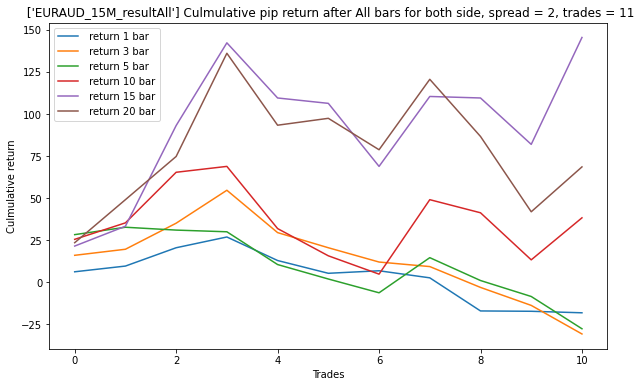

In [90]:
Plot_csPipReturn(EURCHF_15M_resultAll,side='All',spread=2, return_bar='All')

In [83]:
EURCHF_15M_resultB

index                       time   open   high    low  close  volume  \
0   9421  2023-01-18T09:15:00+07:00 1.5434 1.5436 1.5424 1.5432    1610   
1   9436  2023-01-18T13:00:00+07:00 1.5409 1.5413 1.5399 1.5407    2216   

   volume ma  upper  basis  ...    ATR  pivot  MACDpivot  pointpos  \
0  1149.5000 1.5469 1.5442  ... 0.0012      0          0       NaN   
1  2567.2500 1.5454 1.5422  ... 0.0014      0          0       NaN   

   MACDpointpos  divSignal2MACD  CurrLow  CurrHigh  maxHi10bar  maxLo10bar  
0           NaN          2.0000   1.5427    1.5464      1.5455      1.5424  
1           NaN          2.0000   1.5399    1.5455      1.5439      1.5399  

[2 rows x 45 columns]

In [69]:
EURCHF_15M_test.df.iloc[6071]

time               2022-11-01T07:00:00+07:00
open                               1632.5150
high                               1632.6150
low                                1630.7950
close                              1632.0750
upper 2nd                                NaN
basis 2nd                                NaN
lower 2nd                                NaN
volume                                   231
volume ma                           360.1000
upper                              1638.5675
basis                              1633.6998
lower                              1628.8322
plot                                  0.0000
plot.1                                     0
atr                                   1.1828
atr %                                 0.0725
histogram                            -0.1109
macd                                 -0.6988
signal                               -0.5880
LogReturn_1bar                        0.0005
LogReturn_3bar                        0.0012
LogReturn_

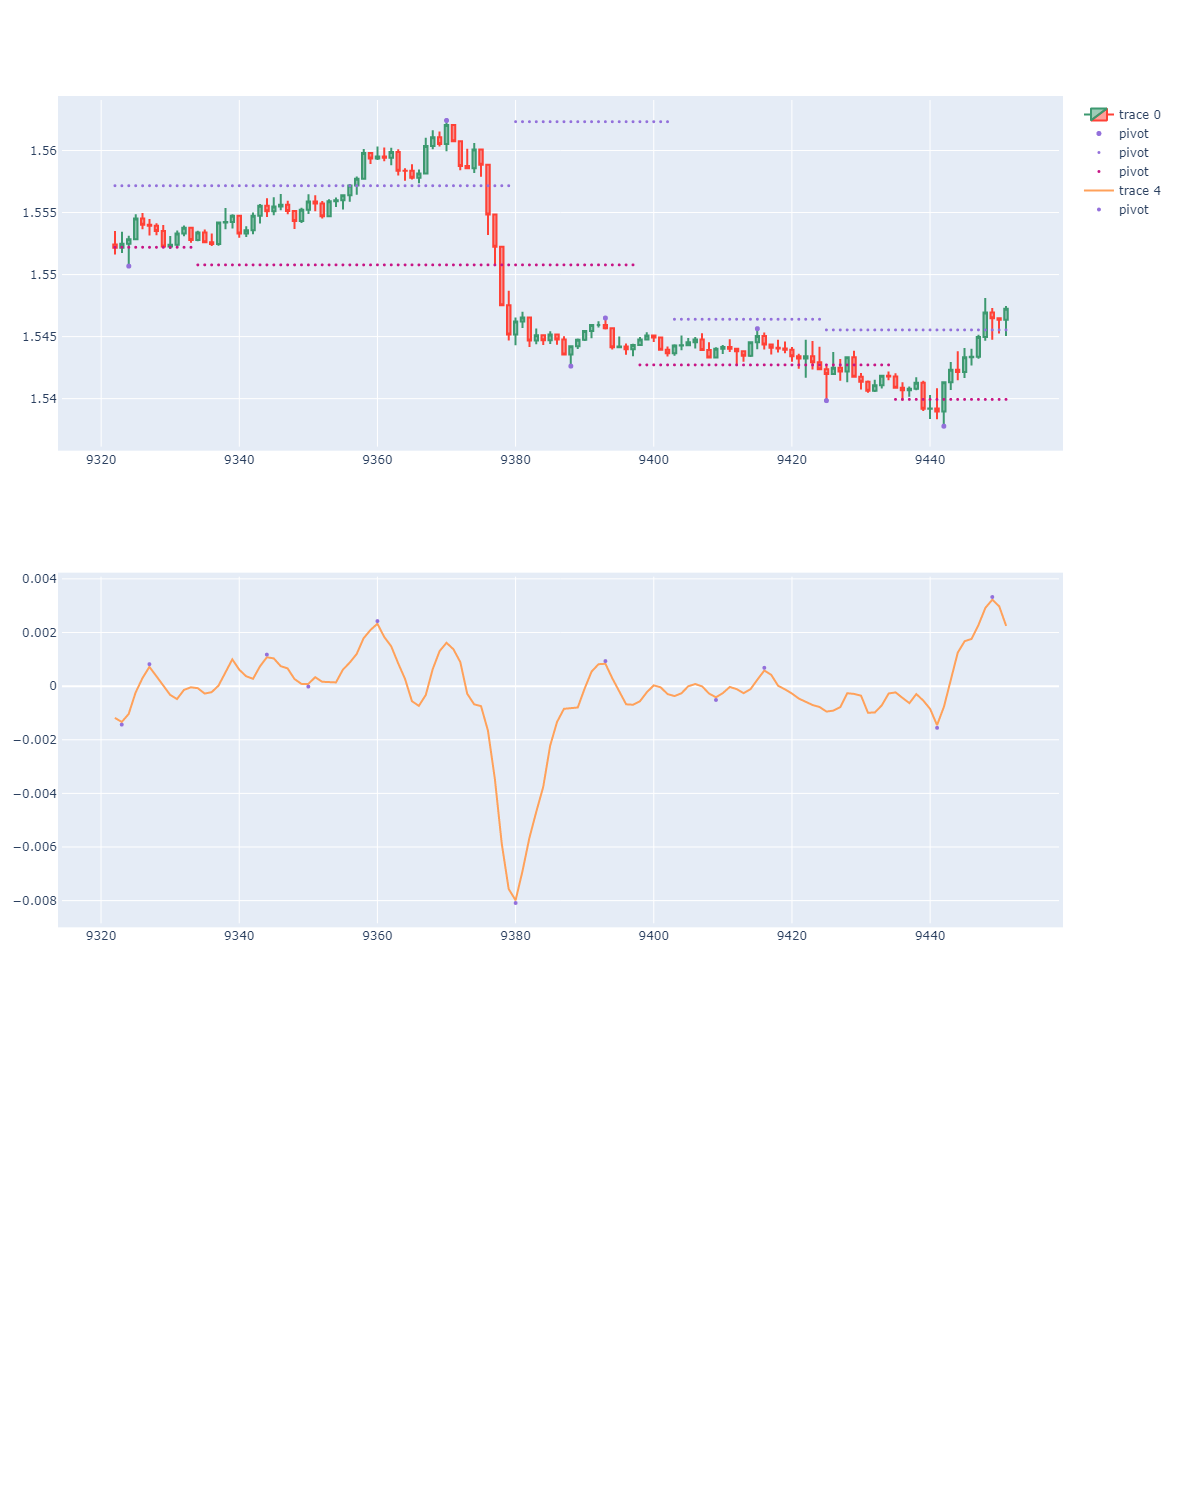

In [89]:
EURCHF_15M_test.graph_init_Sample(9322,9452, height = 1500)

## GBPCAD

### 15 Min


In [ ]:
print(os.listdir("D:Data/Forex/GBPCAD/OANDA_GBPCAD, 15, 0822_0223.csv))

In [92]:
GBPCAD_15M_df = pd.read_csv("D:Data/Forex/GBPCAD/OANDA_GBPCAD, 15, 0822_0223.csv")
GBPCAD_15M_test = TradingTest(GBPCAD_15M_df, pipRetMulti= 10000)

In [93]:
compare_range = 10

In [94]:
GBPCAD_15M_test.gen_pivot(compare_range,compare_range)

pivot point generated with comparative range of( 10, 10 ) candle


In [96]:
GBPCAD_15M_test.gen_divSignal2(compare_range*10,compare_range)

time   open   high    low  close  volume  \
0      2022-09-01T04:00:00+07:00 1.5264 1.5269 1.5253 1.5268      73   
1      2022-09-01T04:15:00+07:00 1.5268 1.5268 1.5246 1.5263     486   
2      2022-09-01T04:30:00+07:00 1.5263 1.5266 1.5258 1.5259     278   
3      2022-09-01T04:45:00+07:00 1.5259 1.5263 1.5246 1.5252    1385   
4      2022-09-01T05:00:00+07:00 1.5252 1.5260 1.5249 1.5259    1790   
...                          ...    ...    ...    ...    ...     ...   
10885  2023-02-08T15:15:00+07:00 1.6175 1.6175 1.6159 1.6169    4152   
10886  2023-02-08T15:30:00+07:00 1.6169 1.6181 1.6162 1.6177    3584   
10887  2023-02-08T15:45:00+07:00 1.6177 1.6180 1.6153 1.6156    2902   
10888  2023-02-08T16:00:00+07:00 1.6156 1.6178 1.6154 1.6176    3053   
10889  2023-02-08T16:15:00+07:00 1.6176 1.6177 1.6164 1.6168    1049   

       volume ma  upper  basis  lower  ...  UpperWick  LowerWick   MACD  \
0            NaN    NaN    NaN    NaN  ...     0.0000     0.0015    NaN   
1            NaN    NaN    NaN    NaN  ...     0.0006     0.0016    NaN   
2            NaN    NaN    NaN    NaN  ...     0.0007     0.0001    NaN   
3            NaN    NaN    NaN    NaN  ...     0.0012     0.0006    NaN   
4            NaN    NaN    NaN    NaN  ...     0.0001     0.0010    NaN   
...          ...    ...    ...    ...  ...        ...        ...    ...   
10885  2189.8500 1.6173 1.6149 1.6125  ...     0.0006     0.0010 0.0026   
10886  2295.0500 1.6177 1.6152 1.6127  ...     0.0004     0.0015 0.0021   
10887  2348.3500 1.6179 1.6152 1.6125  ...     0.0024     0.0003 0.0012   
10888  2427.0500 1.6183 1.6155 1.6126  ...     0.0001     0.0022 0.0011   
10889  2405.3500 1.6184 1.6156 1.6128  ...     0.0009     0.0004 0.0004   

          RSI    ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  
0         NaN    NaN      0          0       NaN           NaN          0.0000  
1         NaN    NaN      0          0       NaN           NaN          0.0000  
2         NaN    NaN      0          0       NaN           NaN          0.0000  
3         NaN    NaN      0          0       NaN           NaN             NaN  
4         NaN    NaN      0          0       NaN           NaN             NaN  
...       ...    ...    ...        ...       ...           ...             ...  
10885 57.9669 0.0011      0          0       NaN           NaN          0.0000  
10886 59.9479 0.0011      0          0       NaN           NaN          0.0000  
10887 52.9337 0.0012      0          0       NaN           NaN          0.0000  
10888 57.9083 0.0013      0          0       NaN           NaN          0.0000  
10889 55.5324 0.0013      0          0       NaN           NaN          0.0000  

[10890 rows x 40 columns]

In [97]:
GBPCAD_15M_test.df.divSignal2MACD.value_counts()

0.0000    7487
1.0000     650
2.0000     397
Name: divSignal2MACD, dtype: int64

In [98]:
GBPCAD_15M_resultS, GBPCAD_15M_statS = falsebreak_wDiv_test(GBPCAD_15M_test.df,
                                                                side = 'sell', elim_cons_trade = True,
                                                                falsebreak_bar= 0, ATR_surpass= 0,
                                                                ATR_commpare_range=0, fwdCandle=compare_range
                                                                )
GBPCAD_15M_resultB, GBPCAD_15M_statB = falsebreak_wDiv_test(GBPCAD_15M_test.df,
                                                                side = 'buy', elim_cons_trade = True , 
                                                                falsebreak_bar= 0, ATR_surpass= 0,
                                                                ATR_commpare_range=0,fwdCandle=compare_range
                                                                )

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\1229821896.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\1229821896.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\1229821896.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\1229821896.py:30: SettingWithCopyWarning:


A v

result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 
result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


In [99]:
GBPCAD_15M_resultS_copy = GBPCAD_15M_resultS.copy()
GBPCAD_15M_resultS_copy[pip_return_masking]  = GBPCAD_15M_resultS_copy[pip_return_masking]*-1
GBPCAD_15M_resultAll = pd.concat([GBPCAD_15M_resultB, GBPCAD_15M_resultS_copy])
GBPCAD_15M_resultAll['time'] = pd.to_datetime(GBPCAD_15M_resultAll['time'])
GBPCAD_15M_resultAll = GBPCAD_15M_resultAll.sort_values(by = "time")
GBPCAD_15M_resultAll = GBPCAD_15M_resultAll.reset_index().drop(columns = ['level_0'])
GBPCAD_15M_StatAll = GetStatAll(GBPCAD_15M_resultAll)

In [100]:
GBPCAD_15M_statS

count     mean  std      min      25%      50%      75%  \
PipReturn_1bar  1.0000  20.5000  NaN  20.5000  20.5000  20.5000  20.5000   
PipReturn_3bar  1.0000 -58.7000  NaN -58.7000 -58.7000 -58.7000 -58.7000   
PipReturn_5bar  1.0000 -61.9000  NaN -61.9000 -61.9000 -61.9000 -61.9000   
PipReturn_10bar 1.0000 -34.3000  NaN -34.3000 -34.3000 -34.3000 -34.3000   
PipReturn_15bar 1.0000 -61.3000  NaN -61.3000 -61.3000 -61.3000 -61.3000   
PipReturn_20bar 1.0000 -55.5000  NaN -55.5000 -55.5000 -55.5000 -55.5000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   20.5000           NaN             NaN  
PipReturn_3bar  -58.7000           NaN             NaN  
PipReturn_5bar  -61.9000           NaN             NaN  
PipReturn_10bar -34.3000           NaN             NaN  
PipReturn_15bar -61.3000           NaN             NaN  
PipReturn_20bar -55.5000           NaN             NaN

In [101]:
GBPCAD_15M_statB

count  mean  std  min  25%  50%  75%  max  Sharpe ratio  \
PipReturn_1bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_3bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_5bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_10bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_15bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_20bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   

                 Count x Sharpe  
PipReturn_1bar              NaN  
PipReturn_3bar              NaN  
PipReturn_5bar              NaN  
PipReturn_10bar             NaN  
PipReturn_15bar             NaN  
PipReturn_20bar             NaN

In [80]:
GBPCAD_15M_StatAll

count    mean     std      min      25%     50%     75%  \
PipReturn_1bar  11.0000  0.3364  9.1689 -17.7000  -3.9000  1.8000  6.7500   
PipReturn_3bar  11.0000 -0.8091 14.6840 -23.2000  -9.5500 -6.5000 11.5500   
PipReturn_5bar  11.0000 -0.5273 15.3308 -17.5000  -9.5500 -6.2000  3.7000   
PipReturn_10bar 11.0000  5.4727 25.9025 -35.0000 -11.5500  5.5000 27.2000   
PipReturn_15bar 11.0000 15.2273 37.0293 -35.5000 -13.4000 13.8000 47.4000   
PipReturn_20bar 11.0000  8.2273 36.1063 -42.8000 -24.3500 25.4000 28.2000   

                    max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar  12.9000        0.0367          0.4035  
PipReturn_3bar  21.6000       -0.0551         -0.6061  
PipReturn_5bar  30.2000       -0.0344         -0.3783  
PipReturn_10bar 46.3000        0.2113          2.3241  
PipReturn_15bar 65.6000        0.4112          4.5234  
PipReturn_20bar 63.4000        0.2279          2.5065

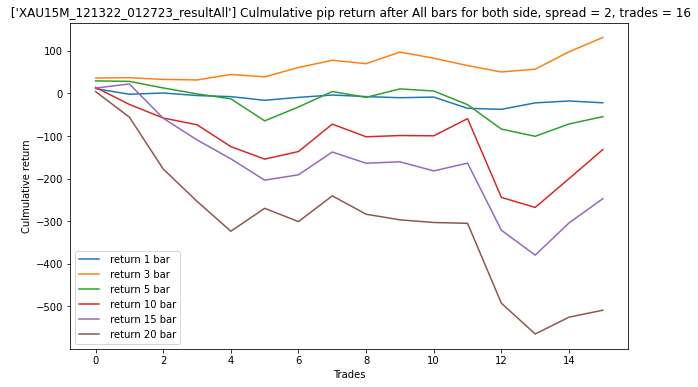

In [81]:
Plot_csPipReturn(XAU15M_121322_012723_resultAll,side='All',spread=2, return_bar='All')

In [83]:
GBPCAD_15M_resultB

index                       time   open   high    low  close  volume  \
0   9421  2023-01-18T09:15:00+07:00 1.5434 1.5436 1.5424 1.5432    1610   
1   9436  2023-01-18T13:00:00+07:00 1.5409 1.5413 1.5399 1.5407    2216   

   volume ma  upper  basis  ...    ATR  pivot  MACDpivot  pointpos  \
0  1149.5000 1.5469 1.5442  ... 0.0012      0          0       NaN   
1  2567.2500 1.5454 1.5422  ... 0.0014      0          0       NaN   

   MACDpointpos  divSignal2MACD  CurrLow  CurrHigh  maxHi10bar  maxLo10bar  
0           NaN          2.0000   1.5427    1.5464      1.5455      1.5424  
1           NaN          2.0000   1.5399    1.5455      1.5439      1.5399  

[2 rows x 45 columns]

In [69]:
GBPCAD_15M_test.df.iloc[6071]

time               2022-11-01T07:00:00+07:00
open                               1632.5150
high                               1632.6150
low                                1630.7950
close                              1632.0750
upper 2nd                                NaN
basis 2nd                                NaN
lower 2nd                                NaN
volume                                   231
volume ma                           360.1000
upper                              1638.5675
basis                              1633.6998
lower                              1628.8322
plot                                  0.0000
plot.1                                     0
atr                                   1.1828
atr %                                 0.0725
histogram                            -0.1109
macd                                 -0.6988
signal                               -0.5880
LogReturn_1bar                        0.0005
LogReturn_3bar                        0.0012
LogReturn_

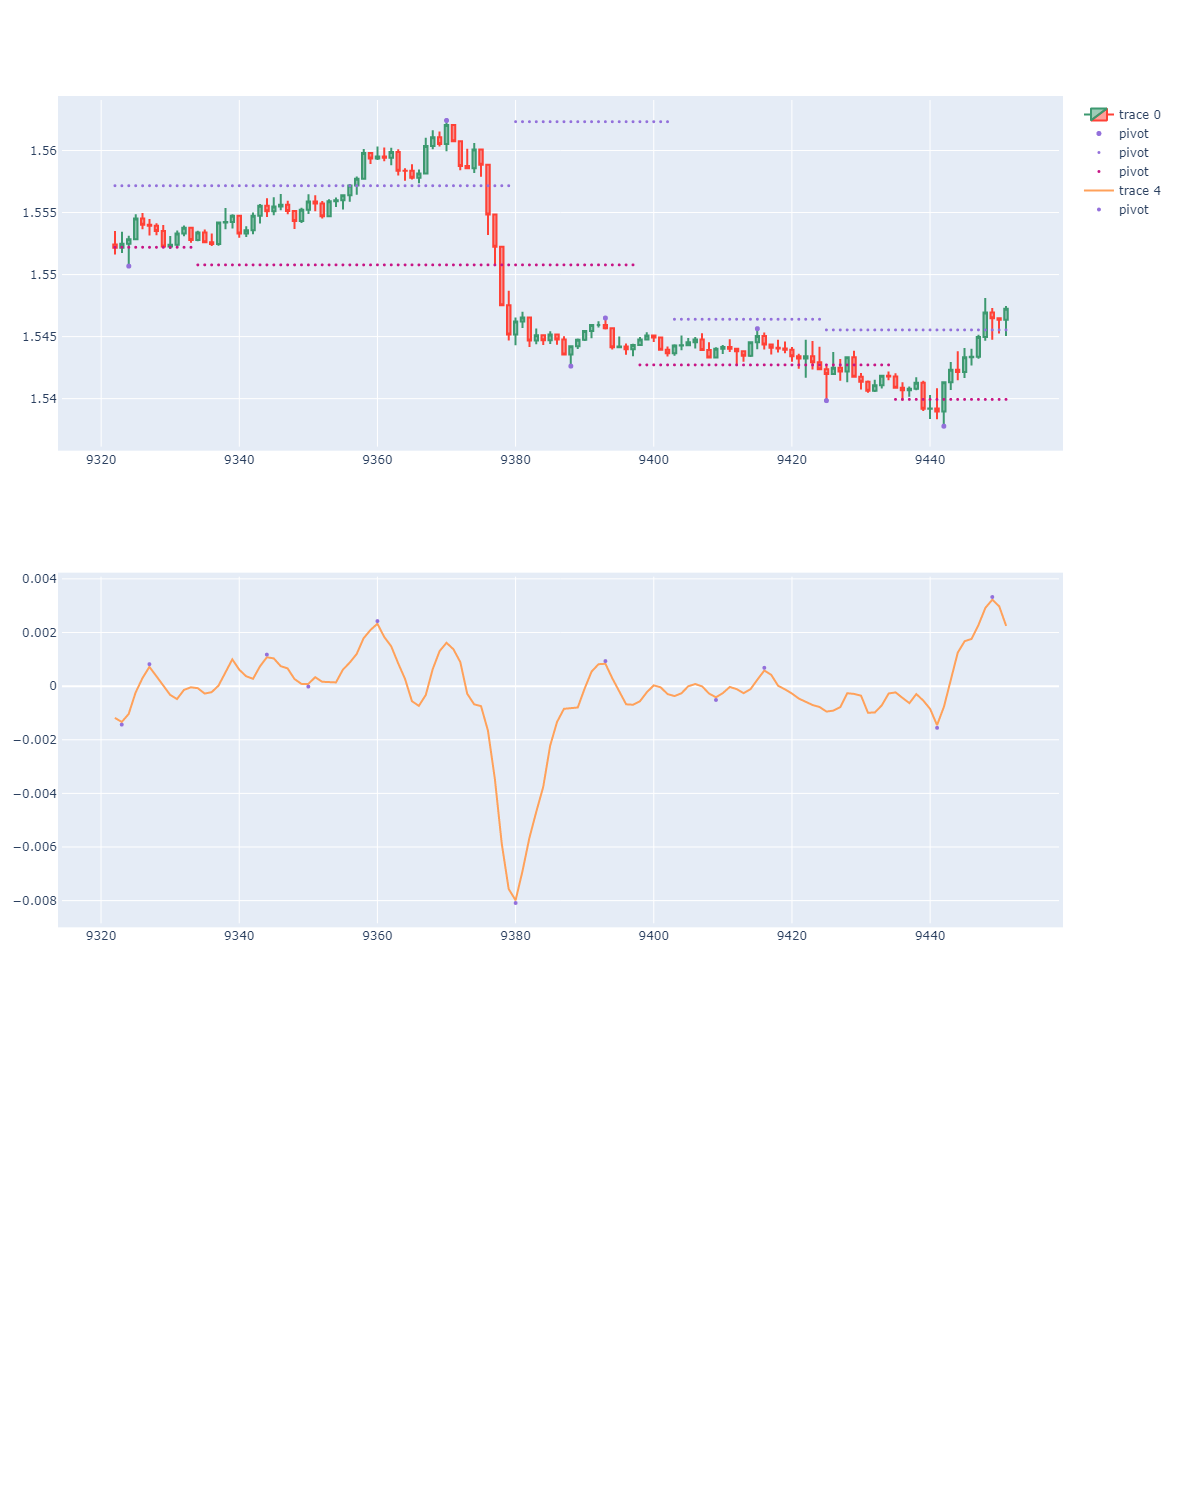

In [89]:
GBPCAD_15M_test.graph_init_Sample(9322,9452, height = 1500)

## EURUSD

#### EURUSD 5 min


In [ ]:
print(os.listdir("D:Data/Forex/EURUSD/FX_EURUSD, 15, 010922_080223.csv"))

In [269]:
EU15M_0922_0223 = pd.read_csv("D:Data/Forex/EURUSD/FX_EURUSD, 15, 010922_080223.csv")
EU15M_0922_0223_test = TradingTest(EU15M_0922_0223,pipRetMulti=10000)

In [270]:
compare_range = 10

In [273]:
EU15M_0922_0223_test.gen_pivot(compare_range,compare_range)

pivot point generated with comparative range of( 10, 10 ) candle


In [274]:
EU15M_0922_0223_test.gen_divSignal2(compare_range*10,compare_range)

time   open   high    low  close  volume  \
0      2022-09-01T04:00:00+07:00 1.0052 1.0052 1.0043 1.0049     952   
1      2022-09-01T04:15:00+07:00 1.0049 1.0050 1.0044 1.0049    1052   
2      2022-09-01T04:30:00+07:00 1.0049 1.0052 1.0049 1.0051     277   
3      2022-09-01T04:45:00+07:00 1.0051 1.0052 1.0049 1.0051     151   
4      2022-09-01T05:00:00+07:00 1.0051 1.0054 1.0050 1.0053     516   
...                          ...    ...    ...    ...    ...     ...   
10961  2023-02-08T19:15:00+07:00 1.0748 1.0749 1.0744 1.0746    2441   
10962  2023-02-08T19:30:00+07:00 1.0746 1.0749 1.0740 1.0744    2789   
10963  2023-02-08T19:45:00+07:00 1.0744 1.0744 1.0734 1.0734    3500   
10964  2023-02-08T20:00:00+07:00 1.0734 1.0737 1.0732 1.0735    4160   
10965  2023-02-08T20:15:00+07:00 1.0735 1.0736 1.0728 1.0729    2874   

       volume ma  upper  basis  lower  ...  UpperWick  LowerWick    MACD  \
0            NaN    NaN    NaN    NaN  ...     0.0003     0.0006     NaN   
1            NaN    NaN    NaN    NaN  ...     0.0001     0.0005     NaN   
2            NaN    NaN    NaN    NaN  ...     0.0001     0.0002     NaN   
3            NaN    NaN    NaN    NaN  ...     0.0001     0.0001     NaN   
4            NaN    NaN    NaN    NaN  ...     0.0001     0.0003     NaN   
...          ...    ...    ...    ...  ...        ...        ...     ...   
10961  3439.3500 1.0762 1.0744 1.0727  ...     0.0003     0.0002 -0.0001   
10962  3443.0500 1.0762 1.0744 1.0727  ...     0.0005     0.0004  0.0002   
10963  3384.4500 1.0761 1.0743 1.0725  ...     0.0011     0.0000 -0.0001   
10964  3249.8000 1.0760 1.0743 1.0725  ...     0.0002     0.0003 -0.0004   
10965  3130.2500 1.0759 1.0741 1.0723  ...     0.0006     0.0001 -0.0007   

          RSI    ATR  pivot  MACDpivot  pointpos  MACDpointpos  divSignal2MACD  
0         NaN    NaN      0          0       NaN           NaN          0.0000  
1         NaN    NaN      0          0       NaN           NaN          0.0000  
2         NaN    NaN      0          0       NaN           NaN          0.0000  
3         NaN    NaN      0          0       NaN           NaN             NaN  
4         NaN    NaN      0          0       NaN           NaN             NaN  
...       ...    ...    ...        ...       ...           ...             ...  
10961 53.9305 0.0008      0          0       NaN           NaN          0.0000  
10962 53.0229 0.0008      0          0       NaN           NaN          0.0000  
10963 48.6214 0.0008      0          0       NaN           NaN          0.0000  
10964 49.2085 0.0008      0          0       NaN           NaN          0.0000  
10965 46.8733 0.0008      0          0       NaN           NaN          0.0000  

[10966 rows x 40 columns]

In [275]:
EU15M_0922_0223_test.df.divSignal2MACD.value_counts()

0.0000    8794
1.0000     567
2.0000     327
Name: divSignal2MACD, dtype: int64

In [347]:
EU15M_0922_0223_resultS, EU15M_0922_0223_statS = falsebreak_wDiv_test(EU15M_0922_0223_test.df,
                                                                side = 'sell', elim_cons_trade = True,
                                                                falsebreak_bar= 0, ATR_surpass= 0.1,
                                                                ATR_commpare_range=0, fwdCandle=compare_range
                                                                )
EU15M_0922_0223_resultB, EU15M_0922_0223_statB = falsebreak_wDiv_test(EU15M_0922_0223_test.df,
                                                                side = 'buy', elim_cons_trade = True , 
                                                                falsebreak_bar= 0, ATR_surpass= 0.1,
                                                                ATR_commpare_range=0,fwdCandle=compare_range
                                                                )

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of sell falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.1, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_21408\311561226.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



result of buy falsebreak with falsebreak bar = 0,
, ATR_Surpass = 0.1, div_signal = divSignal2MACD, elim_cons_trade = True,return_type = ['PipReturn_1bar', 'PipReturn_3bar', 'PipReturn_5bar', 'PipReturn_10bar', 'PipReturn_15bar', 'PipReturn_20bar'] 


In [348]:
EU15M_0922_0223_statS

count     mean  std      min      25%      50%      75%  \
PipReturn_1bar  1.0000  -0.5000  NaN  -0.5000  -0.5000  -0.5000  -0.5000   
PipReturn_3bar  1.0000   0.0000  NaN   0.0000   0.0000   0.0000   0.0000   
PipReturn_5bar  1.0000  12.9000  NaN  12.9000  12.9000  12.9000  12.9000   
PipReturn_10bar 1.0000 -10.9000  NaN -10.9000 -10.9000 -10.9000 -10.9000   
PipReturn_15bar 1.0000 -61.6000  NaN -61.6000 -61.6000 -61.6000 -61.6000   
PipReturn_20bar 1.0000 -51.4000  NaN -51.4000 -51.4000 -51.4000 -51.4000   

                     max  Sharpe ratio  Count x Sharpe  
PipReturn_1bar   -0.5000           NaN             NaN  
PipReturn_3bar    0.0000           NaN             NaN  
PipReturn_5bar   12.9000           NaN             NaN  
PipReturn_10bar -10.9000           NaN             NaN  
PipReturn_15bar -61.6000           NaN             NaN  
PipReturn_20bar -51.4000           NaN             NaN

In [349]:
EU15M_0922_0223_statB

count  mean  std  min  25%  50%  75%  max  Sharpe ratio  \
PipReturn_1bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_3bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_5bar  0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_10bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_15bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   
PipReturn_20bar 0.0000   NaN  NaN  NaN  NaN  NaN  NaN  NaN           NaN   

                 Count x Sharpe  
PipReturn_1bar              NaN  
PipReturn_3bar              NaN  
PipReturn_5bar              NaN  
PipReturn_10bar             NaN  
PipReturn_15bar             NaN  
PipReturn_20bar             NaN

### VN30F1M

#### 5 min from 04/12/2022

In [ ]:
print(os.listdir("D:/Data/Stock/VN/Future/"))

In [ ]:
VN30F1M_5m_df = pd.read_csv("D:/Data/Stock/VN/Future/TDView_HNX_DLY_VN301!, 5.csv")

In [ ]:
VN30F1M_5m_df = VN30F1M_5m_df[['time', 'open', 'high', 'low', 'close','Volume']]

In [ ]:
VN30F1M_5m_tdtest = TradingTest(VN30F1M_5m_df, pipRetMulti= 1)

In [ ]:
VN30F1M_5m_tdtest.gen_pivot(5,5)
VN30F1M_5m_tdtest.gen_divSignal2(30)

##### Sell

In [ ]:
VN30_5m_sell_df, VN30_5m_sell_stats = falsebreak_wDiv_test(VN30F1M_5m_tdtest.df, side = 'sell', elim_cons_trade = True , falsebreak_bar = 1, ATR_surpass=0.1)
VN30_5m_sell_stats

In [ ]:
Plot_csPipReturn(VN30_5m_sell_df,'sell', 0.15, 3 )


##### Buy

In [ ]:
VN30_5m_buy_df, VN30_5m_buy_stats = falsebreak_wDiv_test(VN30F1M_5m_tdtest.df, side = 'buy', elim_cons_trade = True , falsebreak_bar= 1, ATR_surpass=0.1)
VN30_5m_buy_stats

In [ ]:
Plot_csPipReturn(VN30_5m_buy_df, 'buy', 0.15, 1)

In [ ]:
VN30_5m_buy_df['PipReturn_3bar_cumsum'] = (VN30_5m_buy_df['PipReturn_3bar'] - 0.15).cumsum()
plt.plot(VN30_5m_buy_df.index, VN30_5m_buy_df['PipReturn_3bar_cumsum'])

#### 15 min from 04/2020

In [ ]:
print(os.listdir("D:/Data/Stock/VN/Future/"))

In [ ]:
VN30F1M_15m_df = pd.read_csv("D:/Data/Stock/VN/Future/TDView_HNX_DLY_VN301!, 15.csv")

In [ ]:
VN30F1M_15m_test.df

In [ ]:
VN30F1M_15m_test = TradingTest(VN30F1M_15m_df, pipRetMulti=1)

In [ ]:
VN30F1M_15m_test.gen_pivot(5,5)
VN30F1M_15m_test.gen_divSignal2(30)

##### Sell

In [ ]:
VN30_15m_sell_df, VN30_15m_sell_stats = falsebreak_wDiv_test(VN30F1M_15m_test.df,
                                                             side = 'sell', elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass=0)
VN30_15m_sell_stats

In [ ]:
Plot_csPipReturn(VN30_15m_sell_df, side = 'sell', spread = 0.15, return_bar='All')

##### Buy

In [ ]:
VN30_15m_buy_df, VN30_15m_buy_stats = falsebreak_wDiv_test(VN30F1M_15m_test.df, side = 'buy', elim_cons_trade = True , falsebreak_bar= 0, ATR_surpass=0.)
VN30_15m_buy_stats

In [ ]:
VN30_15m_buy_df.tail(5)

In [ ]:
Plot_csPipReturn(VN30_15m_buy_df, side = 'buy', spread = 0.15, return_bar='All')

### AUDNZD

#### DUKAS_AUDNZD_Candlestick_5_M_BID_01.07.2022-14.01.2023

In [ ]:
print(os.listdir("D:/5.Data center/Forex/AUDNZD/"))

In [ ]:
AN_df = pd.read_csv("D:/5.Data center/Forex/AUDNZD/DUKAS_AUDNZD_Candlestick_5_M_BID_01.07.2022-14.01.2023.csv")
AN_df.columns = ['Gmt time', 'open', 'high', 'low', 'close', 'Volume']

In [ ]:
AN_tdtest = TradingTest(AN_df, pipRetMulti=10000)

In [ ]:
AN_tdtest.gen_pivot(5,5)
AN_tdtest.gen_divSignal2(30)

In [ ]:
AN_tdtest.df.divSignal2MACD.value_counts()

In [ ]:
AN_sell_df, AN_sell_stat = falsebreak_wDiv_test(AN_tdtest.df, side = 'sell', elim_cons_trade = True , falsebreak_bar=0, ATR_surpass=0)
AN_sell_stat

In [ ]:
AN_buy_df, AN_buy_stat = falsebreak_wDiv_test(AN_tdtest.df, side = 'buy', elim_cons_trade = True , falsebreak_bar=0, ATR_surpass=0)
AN_buy_stat

### EURGBP

#### DUKAS_EURGBP_Candlestick_5_M_BID_01.07.2022-14.01.2023

In [ ]:
EG_df = pd.read_csv("D:/5.Data center/Forex/EURGBP/DUKAS_EURGBP_Candlestick_5_M_BID_01.07.2022-14.01.2023.csv")

In [ ]:
EG_tdtest = TradingTest(EG_df, pipRetMulti=10000)

In [ ]:
EG_tdtest.gen_pivot(5,5)
EG_tdtest.gen_divSignal2(30)

In [ ]:
EG_tdtest.df.divSignal2MACD.value_counts()

In [ ]:
EG_sell_df,EG_sell_stat = falsebreak_wDiv_test(EG_tdtest.df, side = 'sell', elim_cons_trade = False , falsebreak_bar=1, ATR_surpass=0)
EG_sell_stat

In [ ]:
EG_buy_df,EG_buy_stat = falsebreak_wDiv_test(EG_tdtest.df, side = 'buy', elim_cons_trade = True , falsebreak_bar=1, ATR_surpass=0)
EG_buy_stat

In [ ]:
np.polyfit??

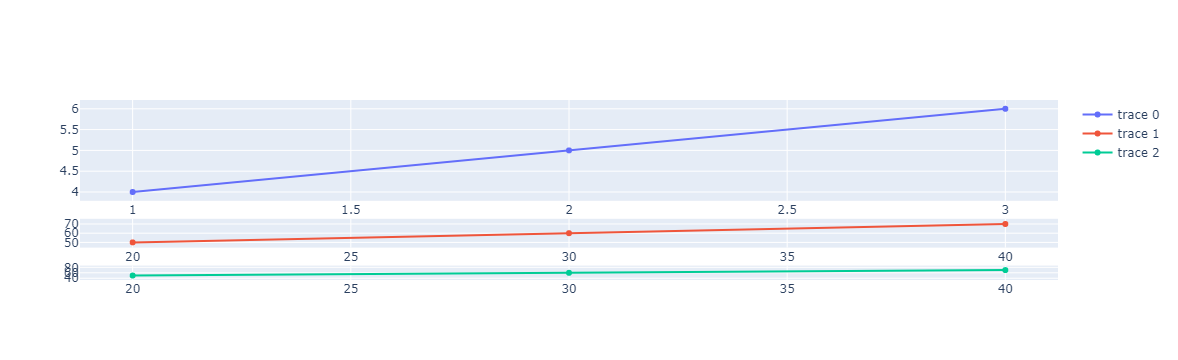

In [198]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1, row_heights=[0.7, 0.2,0.1])

fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
              row=1, col=1)

fig.add_trace(go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
              row=2, col=1)
fig.add_trace(go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
              row=3, col=1)

fig.show()